**MALL FOOTFALL PREDICTION**

In [ ]:
import pandas as pd # importing necessary Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
import math
from scipy.stats import kurtosis
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from numpy import mean
from numpy import std
import math
from math import pi,cos,sin,tan,atan
import datetime
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

import pmdarima as pm
from pmdarima.utils import array
from pmdarima.metrics import smape
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
import lightgbm as lgb
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, roc_curve
from xgboost.sklearn import XGBRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

## Functions

In [ ]:

DropCols = ['BRCWeek', 'NewDate', 'Day_yr', 'Month_yr', 'Week_yr', 'Hour_yr', 'week_no']
categoricalCols = ['LocationName', 'Hour', 'Weekday', 'Month', 'Year', 'Day', 'Holidays', 'abnormal_rain', 'high_temp','low_temp', 'high_wind']
NumericCols= ['mean_temp', 'rain', 'wind_speed', 'InCount']

def converttoDateTime(data, cols):
    d1 = data.copy()
    d1[cols] = pd.to_datetime(d1[cols])
    d1[cols] = d1[cols].dt.strftime('%d-%m-%Y')
    return d1

def dateRange(data, name):
    date_Range = str(data['Date'].dt.date.min()) + ' to ' +str(data['Date'].dt.date.max())
    print(name+"Date Range:"+date_Range)


def removeDuplicate(data, duplicateCol):
        print(f'Before Removing the duplicates:{len(data)}')
        data = data.drop_duplicates(duplicateCol, keep='last')
        data.reset_index(drop=True, inplace=True)
        print(f'After Removing the duplicates:{len(data)}')
        return data

def dropColumn( data, DropCols):
    d1 = data.copy()
    d1 = d1.drop(DropCols, axis=1)
    return d1


def getUniqueValues(data):
    print("\nUnique value in each column \n{}".format(data.nunique(axis=0)))
    data.select_dtypes(np.number).nunique().plot.bar(color='blue', figsize=(8, 6),edgecolor='k', linewidth=2)
    plt.xlabel('Number of Unique Values')
    plt.ylabel('Count')
    plt.title('Count of Unique Values in number Columns')

    plt.show()


def getMissingCount(data):
        missingCount = data.isnull().sum() * 100 / len(data)
        return missingCount


def convertColsCategorical(data, cols):
        d1 = data.copy()
        d1[cols] = d1[cols].astype('category')
        return d1


def getNumericCols( data):
        return data.select_dtypes(include=['float64', 'int64']).columns


def createBin(data, numericCols, binNumber):
        d1 = data.copy()
        for i in numericCols[0:len(numericCols)]:
            bins = np.linspace(d1[i].min(), d1[i].max(), binNumber)
            d1[i + "Bin"] = pd.cut(d1[i], bins, precision=1,include_lowest=True, right=True)
        return d1


In [ ]:
## Encoding
def labelEncoder(data, columns):
        d1 = data.copy()
        for i in columns:
            le = LabelEncoder()
            d1[i] = le.fit_transform(d1[i])
        return d1

In [ ]:
## Scaling
def minMaxScaler(data, cols):
        d1 = data.copy()
        scaler = MinMaxScaler()
        d1[cols] = scaler.fit_transform(d1[cols])
        #scaledData = pd.DataFrame(scaledData, columns=d1.columns)
        return d1

In [ ]:
# Visualization functions

def barPlot(data, barplotcols, hue, numCol):
        d1 = data.copy()
        for i in barplotcols:
            d1.sort_values(by=[i])
            for j in hue:
                plt.figure(figsize=(30, 10))
                plt.subplot(121)
                sns.barplot(data=d1, x=i, y=numCol, palette="cubehelix")
                plt.title("Distribution of " + i)
                plt.subplot(122)
                sns.barplot(data=d1, x=i, y=numCol, hue=j,palette="cubehelix")
                plt.ylabel("")
                plt.title("Distribution of " + i + " by " + j)
                plt.subplots_adjust(wspace=.4)
        plt.show()


def catPlots(data,xcol,ycol,hue,col,title, kind):
    g = sns.catplot(data=data, x=xcol, y=ycol, hue=hue, col=col, kind=kind,palette='cubehelix',col_wrap=3,height=2,ci=None,aspect=2)
    g.fig.suptitle(title, fontsize = 'x-large', fontweight = 'bold' )
    g.fig.subplots_adjust( top = 0.85 )


def pie_chart (data,colname):
    pd1=data.groupby([colname])['InCountTotal'].sum()
    pd1.plot.pie(figsize=(5,10),autopct="%.2f%%")
    plt.title(colname+'Wise Footfall %')
    plt.show()

In [ ]:
## Splitting train test data
def TrainTestSplit (data, response):
    predictor = data.drop(response, axis=1)
    target = data[response]
    X_Train, X_Test, y_Train, y_Test = train_test_split(predictor, target, test_size=0.05,random_state=0, shuffle=False)
    return X_Train, X_Test, y_Train, y_Test

In [ ]:
model_results=pd.DataFrame(columns= ['Model', 'Techniques', 'MapeMean', 'R2', 'R2Score', 'MSE', 'MAE', 'sMAPE'])

In [ ]:
## Model functions

### Model Regressors
lgbm=LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.05, n_estimators=100, subsample_for_bin=200000, objective='regression', class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0)
gb= GradientBoostingRegressor(n_estimators=100, random_state=30)
rf = RandomForestRegressor(n_estimators=500, max_depth=5, max_features='auto', max_leaf_nodes=50, random_state=30,
                    min_samples_split=10, bootstrap=True, criterion='squared_error')
xgb = XGBRegressor(max_depth = 5, learning_rate=0.05, n_estimators=150, objective='reg:squarederror',
                    booster = 'gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,
                    subsample=0.8, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                    base_score=0.5, random_state=30, seed=None, missing=1)
knn = KNeighborsRegressor(n_neighbors=3, leaf_size=30, p=2, weights='uniform',
                                       algorithm='auto', n_jobs=-1, metric='minkowski')
ada = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')
bagging = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=1.0,
                                        max_features=1.0, bootstrap=True, bootstrap_features=False,
                                        oob_score=False, warm_start=False, n_jobs=None)


model={'Light GBM':lgbm,'gbm':gb,'random forest': rf,'xgb':xgb,'knn':knn,'ada':ada,'bagging':bagging}


### Model Parameters

rf_parameters={"max_features": ["auto", "sqrt", "log2"],
            "max_depth" : [3, 4, 5, 6, 7, 8],
            "min_samples_split": [0.005, 0.01, 0.05, 0.10],
            "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
            "criterion" :["squared_error", "absolute_error"]}

lgb_parameters={'num_leaves': [7, 14, 21, 28, 31, 50],
                'learning_rate': [0.1, 0.03, 0.003],
                'max_depth': [-1, 3, 5],
                'n_estimators': [50, 100, 200, 500]}
gb_parameters={"learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001],
               "max_depth": [2,3,4,5,6],
               "min_samples_split": [0.005, 0.01, 0.05, 0.10],
               "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
               "max_features": ["auto", "sqrt", "log2"],
               "subsample": [0.8, 0.9, 1]}
xgb_parameters={"max_depth":range(3,10,2), "min_child_weight":range(1,6,2),
               "gamma":[i/10.0 for i in range(0,5)],
               "subsample":[i/10.0 for i in range(6,10)],
               "colsample_bytree":[i/10.0 for i in range(6,10)],
               "reg_alpha": [1e-5, 1e-2, 0.1, 1, 100],
               "booster": ['gbtree', 'gblinear', 'dart'],
               "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3]}
knn_parameters= {"n_neighbors": [3,5,11,19],
                   "p": [1, 2, 3, 4, 5],
                   "leaf_size": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                   "n_jobs": [-1],
                   "weights" : ['uniform', 'distance'],
                   "metric" : ['euclidean', 'manhattan']}
ada_parameters= {"learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]}


In [ ]:
def getMetrics(actual, predicted):
    #actual.reset_index(drop=True, inplace=True)
    #predicted.reset_index(drop=True, inplace=True)
        yActual, yPredicted = np.array(actual), np.array(predicted)
        MAPE = (np.abs((yActual - yPredicted) / yActual)) * 100
        mapeMean = np.mean(np.abs((yActual - yPredicted) / yActual)) * 100
        sMAPE = 100*(np.abs(yPredicted - yActual)/((np.abs(yActual) + np.abs(yPredicted))/2))

        sMAPEMean = smape(yActual, yPredicted)

        actualDF = pd.DataFrame({'Actual': actual, 'Predicted': predicted, 'MAPE': MAPE, 'sMAPE': sMAPE})
        maxMAPE = actualDF['MAPE'].max()
        actualDF['bins'] = pd.cut(x=actualDF['MAPE'], bins=[0, 5, 10, 15, 20, 25, maxMAPE],
                        labels=['Less or Equal to 5%', '5 to 10%', '10 to 15%', '15 to 20%', '20 to 25%', 'Greater than 25%'])
        df1 = actualDF.head(20)
        print(df1)
        item_counts = actualDF['bins'].value_counts()
        print(item_counts)
        sns.countplot(y=actualDF['bins'], palette="Set2" )

        fig, ax = plt.subplots()
        ax = sns.scatterplot(x="Actual", y="Predicted", data=actualDF)
        ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4)
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title("Actual vs Predicted")

        plt.show()


        from sklearn.metrics import mean_squared_error, r2_score

        mse = mean_squared_error(actual, predicted)
        r2Score = r2_score(actual, predicted)
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        return mapeMean, r2, r2Score, mse, mae, sMAPEMean



#The “step” parameter indicates the number of features to remove at each iteration.
#Here, we will drop one feature in each iteration to identify the right set of features which have maximum influences on the dependent variable.
#To split data into train/test sets and calculate the feature importance we have mentioned five-fold cross-validation.

def RFECVmodel(model1):

    global model_results
    model2 = model[model1]
    print(model2)
    rfecv = RFECV(estimator=model2, step=1, cv=5, scoring='r2')
    rfecv.fit(X_Train, np.ravel(y_Train))

    print('Optimal number of features: {}'.format(rfecv.n_features_))

    min_features_to_select=1
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(10, 4))
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.show()

    rfeCols = list(X_Train.columns[rfecv.support_])
    print(rfeCols)

    X_Train_RFE=X_Train[rfeCols]
    rfecv.fit(X_Train_RFE,y_Train)
    y_Pred_rfecv=rfecv.predict(X_Test[rfeCols])
    r2 = metrics.r2_score(y_Test, y_Pred_rfecv)
    mapeMean, r2, r2Score, mse, mae, sMAPEMean = getMetrics(y_Test, y_Pred_rfecv)
    model_results = model_results.append({'Model' : model1, 'Techniques' : 'RFE with CV',
                                      'MapeMean' : mapeMean, 'R2' : r2, 'R2Score' : r2Score,
                                     'MSE' : mse, 'MAE' : mae, 'sMAPE' : sMAPEMean}, ignore_index = True)

    print("Results of sklearn.metrics:")
    print("R-Squared:", r2)

#Randomized Search with Cross-Validation is a hyperparameter optimization technique used
#in machine learning to search for the best hyperparameters of a model
def Hyperparameter(model1, parameter):
    global model_results
    model2 = model[model1]
    print(model2)
    rscv = RandomizedSearchCV(estimator = model2, param_distributions = parameter,
                               n_iter = 50, cv = 3, verbose = 2, random_state = 42)
    rscv.fit(X_Train, y_Train)
    rscv.best_params_
    rscv.best_estimator_.fit(X_Train, y_Train)
    y_pred = rscv.best_estimator_.predict(X_Test) # Predictions
    y_true = y_Test # True values
    #mae = metrics.mean_absolute_error(y_true, y_pred)
    #mse = metrics.mean_squared_error(y_true, y_pred)
    #mape= metrics.mean_absolute_percentage_error(y_true, y_pred)
    #rmse = np.sqrt(mse) # or mse**(0.5)
    r2 = metrics.r2_score(y_true, y_pred)
    mapeMean, r2, r2Score, mse, mae, sMAPEMean = getMetrics(y_true, y_pred)
    model_results =model_results.append({'Model' : model1, 'Techniques' : 'Randomized Search with CV',
                                          'MapeMean' : mapeMean, 'R2' : r2, 'R2Score' : r2Score,
                                         'MSE' : mse, 'MAE' : mae, 'sMAPE' : sMAPEMean},
                                         ignore_index = True)

    print("Results of sklearn.metrics:")
    #print("MAE:",mae)
    #print("MSE:", mse)
    #print("MAPE:", mape)
    #print("RMSE:", rmse)
    print("R-Squared:", r2)



def visualizeScoreComparison(model_results):
        f, ax = plt.subplots(figsize=(12, 9))
        sns.barplot(x="MapeMean", y="Model", hue="Techniques", palette = 'Set2',data=model_results)
        plt.tight_layout()
        plt.show()



In [ ]:
## Time series analysis functions

def decomposeTS(data, freq): # data is 1d series
        plt.rcParams.update({'figure.figsize': (10,10)})
        # Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series.
        resultAdditive = seasonal_decompose(data, model='additive', period=freq, extrapolate_trend='freq')
        resultMultiplicative = seasonal_decompose(data, model='multiplicative', period=freq, extrapolate_trend='freq')
        resultAdditive.plot().suptitle('Additive Decompose', fontsize=12)
        resultMultiplicative.plot().suptitle('Multiplicative Decompose', fontsize=12)
        plt.show()
        return resultMultiplicative, resultAdditive


def adf_test(data): # Augmented Dickey-Fuller Test
        print('Augmented Dickey-Fuller Test:')
        result = adfuller(data.dropna(),autolag='AIC') # .dropna() handles differenced data
        labels = ['ADF test statistic','p-value','# lags used','# observations']
        out = pd.Series(result[0:4],index=labels)
        for key, value in result[4].items():
            out[f'critical value ({key})']=value
        print(out.to_string())          # .to_string() removes the line "dtype: float64"
        if result[1] <= 0.05:
            print("Data has no unit root and is stationary")
        else:
            print("Data has a unit root and is non-stationary")


def kpss_test(data):
        print('Kwiatkowski-Phillips-Schmidt-Shin Test:')
        result = kpss(data.values, regression='c')
        print('\nKPSS Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        for key, value in result[3].items():
            print('Critial Values:')
            print(f'   {key}, {value}')

        labels = ['KPSS test statistic','p-value','# lags used','# observations']
        out = pd.Series(result[0:4],index=labels)

        for key,val in result[3].items():
            out[f'critical value ({key})']=val

        print(out.to_string())          # .to_string() removes the line "dtype: float64"

        if result[1] <= 0.05:
            print("Data has no unit root and is stationary")
        else:
            print("Data has a unit root and is non-stationary")


def autocorrelationplots(data):
    plt.rc("figure", figsize=(11,5))
    plot_acf(data, lags=48)
    plt.ylim(0,1)
    plt.xlabel('Lags', fontsize=18)
    plt.ylabel('Correlation', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title('Autocorrelation Plot', fontsize=20)
    plt.tight_layout()
    plt.show()


def meanstdplot(data):
    plt.figure(figsize=(10, 4))
    data.plot()
    data.rolling(12).mean().plot(label='12 Month Rolling Mean')
    data.rolling(12).std().plot(label='12 Month Rolling Std')
    plt.legend()

def checkAcfPacf(data, lag):
        fig, axes = plt.subplots(1,2,figsize=(16,7), dpi= 100)
        plot_acf(data, lags=lag, ax=axes[0])
        plot_pacf(data, lags=lag, ax=axes[1])

        plt.show()

### Loading footfall data

In [ ]:
footfall_data=pd.read_csv('/Users/bharathchelimela/Desktop/BITS_AIML/Capstone/Data/footfall.csv')

In [ ]:
footfall_data.head(2)

Date  InCount  BRCWeek LocationName  Hour   Weekday    NewDate  \
0  01-01-2009      268       53     Briggate     0  Thursday  01-Jan-09   
1  01-01-2009      366       53     Briggate     1  Thursday  01-Jan-09   

   Month  Year  Day                Day_yr Month_yr  Week_yr          Hour_yr  \
0      1  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009   
1      1  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009   

   week_no  
0        1  
1        1

In [ ]:
footfall_data['Date']=pd.to_datetime(footfall_data['NewDate'],format='%d-%b-%y')
footfall_data.head(2)

Date  InCount  BRCWeek LocationName  Hour   Weekday    NewDate  Month  \
0 2009-01-01      268       53     Briggate     0  Thursday  01-Jan-09      1   
1 2009-01-01      366       53     Briggate     1  Thursday  01-Jan-09      1   

   Year  Day                Day_yr Month_yr  Week_yr          Hour_yr  week_no  
0  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009        1  
1  2009    1  Thursday/01-Jan-2009   Jan-09  00-2009  00, 01-Jan-2009        1

In [ ]:
dateRange(footfall_data, 'Footfall data ')

Footfall data Date Range:2009-01-01 to 2016-12-31


In [ ]:
footfall_data=dropColumn(footfall_data,DropCols)

In [ ]:
footfall_data.head(2)

Date  InCount LocationName  Hour   Weekday  Month  Year  Day
0 2009-01-01      268     Briggate     0  Thursday      1  2009    1
1 2009-01-01      366     Briggate     1  Thursday      1  2009    1

### Loading Holidays data

In [ ]:
uk_bank_holiday_data= pd.read_csv('/Users/bharathchelimela/Desktop/BITS_AIML/Capstone/Data/UKbankholidays.csv')
uni_holiday = pd.read_csv('/Users/bharathchelimela/Desktop/BITS_AIML/Capstone/Data/uni_hols_long.csv')
school_holiday = pd.read_csv('/Users/bharathchelimela/Desktop/BITS_AIML/Capstone/Data/school_hols_long.csv')
easter_sunday_holiday=pd.read_csv('/Users/bharathchelimela/Desktop/BITS_AIML/Capstone/Data/Easter-Sundays.csv')

In [ ]:
uk_bank_holiday_data=converttoDateTime(uk_bank_holiday_data,'Date')
uk_bank_holiday_data['HolidayName'] = 'Bank Holiday'
uni_holiday=converttoDateTime(uni_holiday,'Date')
uni_holiday['HolidayName'] = 'Uni Holiday'
school_holiday=converttoDateTime(school_holiday,'Date')
school_holiday['HolidayName'] = 'School Holiday'
easter_sunday_holiday=converttoDateTime(easter_sunday_holiday,'Date')
easter_sunday_holiday['HolidayName'] = 'Eastern Sunday Holiday'

In [ ]:
holiday_data=[uk_bank_holiday_data,uni_holiday,school_holiday,easter_sunday_holiday]
df_holidays = pd.concat(holiday_data)
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])

In [ ]:
df_holidays.sort_values('Date', inplace=True)
df_holidays.reset_index(drop=True,inplace=True)

In [ ]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4090 entries, 0 to 4089
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4090 non-null   datetime64[ns]
 1   Holidays     4090 non-null   object        
 2   HolidayName  4090 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 96.0+ KB


In [ ]:
df_holidays= removeDuplicate(df_holidays,'Date')

Before Removing the duplicates:4090
After Removing the duplicates:3022


In [ ]:
dateRange(df_holidays, 'Holiday data ')

Holiday data Date Range:1973-01-05 to 2072-12-27


### Load Weather Data

In [ ]:
weather_data= pd.read_csv('/Users/bharathchelimela/Desktop/BITS_AIML/Capstone/Data/overall_weather.csv')

In [ ]:
weather_data['Date']=pd.to_datetime(weather_data['Date'])
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2282 non-null   datetime64[ns]
 1   mean_temp      2282 non-null   float64       
 2   rain           2282 non-null   float64       
 3   wind_speed     2282 non-null   float64       
 4   abnormal_rain  2282 non-null   int64         
 5   high_temp      2282 non-null   int64         
 6   low_temp       2282 non-null   int64         
 7   high_wind      2282 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 142.8 KB


In [ ]:
dateRange(weather_data, 'Weather data ')

Weather data Date Range:2011-01-01 to 2017-12-03


### Merge all three datasets

In [ ]:
df_merged=pd.merge(footfall_data,df_holidays,on='Date',how='left')
df_merged=pd.merge(df_merged,weather_data,on='Date',how='left')

In [ ]:
df_merged.columns

Index(['Date', 'InCount', 'LocationName', 'Hour', 'Weekday', 'Month', 'Year',
       'Day', 'Holidays', 'HolidayName', 'mean_temp', 'rain', 'wind_speed',
       'abnormal_rain', 'high_temp', 'low_temp', 'high_wind'],
      dtype='object')

In [ ]:
data_range1 = (df_merged['Date'] > '2011-01-01') & (df_merged['Date'] <= '2016-12-31')
df_final_hr=df_merged.loc[data_range1]
df_final_hr['Holidays']=df_final_hr['Holidays'].fillna('N')

In [ ]:
# Hourly dataset
df_final_hr.head(2)

Date  InCount LocationName  Hour Weekday  Month  Year  Day  \
135624 2011-01-02      140     Briggate     0  Sunday      1  2011    2   
135625 2011-01-02       76     Briggate     1  Sunday      1  2011    2   

       Holidays HolidayName  mean_temp  rain  wind_speed  abnormal_rain  \
135624        N         NaN        7.4   0.0         0.5            0.0   
135625        N         NaN        7.4   0.0         0.5            0.0   

        high_temp  low_temp  high_wind  
135624        0.0       0.0        0.0  
135625        0.0       0.0        0.0

In [ ]:
# Drop hour column and groupby Date to make the dataset daywise dataset
df_merged2 = df_merged.drop('Hour',axis=1)
df_merged2['InCountTotal'] = df_merged2.groupby(['Date','LocationName'])['InCount'].transform('sum')

In [ ]:
#Removing duplicate rows of Date column
df_merged2.drop('InCount',axis=1,inplace=True)
df_merged2 = df_merged2.drop_duplicates().reset_index(drop=True)
print(df_merged2.shape)
df_merged2.head(2)

(23075, 16)


Date    LocationName   Weekday  Month  Year  Day Holidays  \
0 2009-01-01        Briggate  Thursday      1  2009    1        Y   
1 2009-01-01  BriggateAtMcDs  Thursday      1  2009    1        Y   

      HolidayName  mean_temp  rain  wind_speed  abnormal_rain  high_temp  \
0  School Holiday        NaN   NaN         NaN            NaN        NaN   
1  School Holiday        NaN   NaN         NaN            NaN        NaN   

   low_temp  high_wind  InCountTotal  
0       NaN        NaN          5634  
1       NaN        NaN          4416

In [ ]:
#Fill No holiday days as "N" in Holidays column
df_merged2['Holidays']=df_merged2['Holidays'].fillna('N')

##### Selecting rows from 2011-01-01 to 2016-12-31 since weather data starts from Jan 1st 2011 and footfall data is only upto 31st Dec 2016.

In [ ]:
data_range = (df_merged2['Date'] >= '2011-01-01') & (df_merged2['Date'] <= '2016-12-31')

In [ ]:
df_final=df_merged2.loc[data_range].reset_index(drop=True)

In [ ]:
df_final.head(2)

Date    LocationName   Weekday  Month  Year  Day Holidays  \
0 2011-01-01        Briggate  Saturday      1  2011    1        Y   
1 2011-01-01  BriggateAtMcDs  Saturday      1  2011    1        Y   

      HolidayName  mean_temp  rain  wind_speed  abnormal_rain  high_temp  \
0  School Holiday        0.0   0.0         0.0            0.0        0.0   
1  School Holiday        0.0   0.0         0.0            0.0        0.0   

   low_temp  high_wind  InCountTotal  
0       1.0        0.0          9467  
1       1.0        0.0          7102

In [ ]:
dateRange(df_final, 'Final Dataset ')

Final Dataset Date Range:2011-01-01 to 2016-12-31


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17432 entries, 0 to 17431
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           17432 non-null  datetime64[ns]
 1   LocationName   17432 non-null  object        
 2   Weekday        17432 non-null  object        
 3   Month          17432 non-null  int64         
 4   Year           17432 non-null  int64         
 5   Day            17432 non-null  int64         
 6   Holidays       17432 non-null  object        
 7   HolidayName    8432 non-null   object        
 8   mean_temp      17432 non-null  float64       
 9   rain           17432 non-null  float64       
 10  wind_speed     17432 non-null  float64       
 11  abnormal_rain  17432 non-null  float64       
 12  high_temp      17432 non-null  float64       
 13  low_temp       17432 non-null  float64       
 14  high_wind      17432 non-null  float64       
 15  InCountTotal   1743

In [ ]:
# Identifying missing values in the final daywise dataset
df_missing=getMissingCount(df_final)
df_missing

Date              0.000000
LocationName      0.000000
Weekday           0.000000
Month             0.000000
Year              0.000000
Day               0.000000
Holidays          0.000000
HolidayName      51.629188
mean_temp         0.000000
rain              0.000000
wind_speed        0.000000
abnormal_rain     0.000000
high_temp         0.000000
low_temp          0.000000
high_wind         0.000000
InCountTotal      0.000000
dtype: float64

In [ ]:
#Dataset for Visualization
df_final_viz=df_final.copy()

#Dataset - Mall level daywise

df_mall_day = df_final.groupby(['Date'])['InCountTotal'].sum().reset_index()
df_mall_day['Date']=pd.to_datetime(df_mall_day['Date'])
df_mall_day['Month']=df_mall_day['Date'].dt.month
df_mall_day['Year']=df_mall_day['Date'].dt.year
df_mall_day['Day']=df_mall_day['Date'].dt.day
df_mall_day['Weekday']=df_mall_day['Date'].dt.day_name()

df_mall_day = pd.merge(df_mall_day, df_holidays, on = "Date", how = "left")
df_mall_day = pd.merge(df_mall_day, weather_data, on = "Date", how = "left")
df_mall_day['Holidays'] = df_mall_day['Holidays'].fillna('N')
df_mall_day = df_mall_day.reset_index(drop=True)

#Dataset - LocationName level daywise data

df_loc_day = df_final.groupby(['LocationName','Date'])['InCountTotal'].sum().reset_index()
df_loc_day['Date']=pd.to_datetime(df_loc_day['Date'])
df_loc_day['Month']=df_loc_day['Date'].dt.month
df_loc_day['Year']=df_loc_day['Date'].dt.year
df_loc_day['Day']=df_loc_day['Date'].dt.day
df_loc_day['Weekday']=df_loc_day['Date'].dt.day_name()

df_loc_day = pd.merge(df_loc_day, df_holidays, on = "Date", how = "left")
df_loc_day = pd.merge(df_loc_day, weather_data, on = "Date", how = "left")
df_loc_day['Holidays'] = df_loc_day['Holidays'].fillna('N')
df_loc_day = df_loc_day.reset_index(drop=True)

#Dataset - LocationName level daywise data in pivoted format
dataDayLong = pd.pivot_table(df_final, index=['Date', 'high_wind','abnormal_rain','high_temp','low_temp', 'mean_temp', 'wind_speed','rain', 'Holidays','HolidayName'], values='InCountTotal',columns=["LocationName"])
dataDayLong = dataDayLong.reset_index(drop=False)
dataDayLong['Month']=dataDayLong['Date'].dt.month
dataDayLong['Year']=dataDayLong['Date'].dt.year
dataDayLong['Day']=dataDayLong['Date'].dt.day
dataDayLong['Weekday']=dataDayLong['Date'].dt.day_name()
dataDayLong = dataDayLong.reset_index(drop=True)

In [ ]:
print(df_mall_day.shape)
df_mall_day.head(5)

(2179, 15)


Date  InCountTotal  Month  Year  Day    Weekday Holidays  \
0 2011-01-01         47767      1  2011    1   Saturday        Y   
1 2011-01-02        115685      1  2011    2     Sunday        N   
2 2011-01-03        160658      1  2011    3     Monday        N   
3 2011-01-04        165334      1  2011    4    Tuesday        Y   
4 2011-01-05        135127      1  2011    5  Wednesday        Y   

      HolidayName  mean_temp  rain  wind_speed  abnormal_rain  high_temp  \
0  School Holiday        0.0   0.0         0.0              0          0   
1             NaN        7.4   0.0         0.5              0          0   
2             NaN        5.1   0.0         1.3              0          0   
3  School Holiday       14.1   0.0         3.9              0          0   
4     Uni Holiday       11.8   0.0         3.0              0          0   

   low_temp  high_wind  
0         1          0  
1         0          0  
2         1          0  
3         0          1  
4         0          1

In [ ]:
dataDayLong.head()

LocationName       Date  high_wind  abnormal_rain  high_temp  low_temp  \
0            2011-01-01        0.0            0.0        0.0       1.0   
1            2011-01-04        1.0            0.0        0.0       0.0   
2            2011-01-05        1.0            0.0        0.0       0.0   
3            2011-01-06        0.0            0.0        0.0       0.0   
4            2011-01-07        0.0            0.0        0.0       0.0   

LocationName  mean_temp  wind_speed  rain Holidays     HolidayName  \
0                   0.0         0.0   0.0        Y  School Holiday   
1                  14.1         3.9   0.0        Y  School Holiday   
2                  11.8         3.0   0.0        Y     Uni Holiday   
3                  14.9         2.6   0.0        Y  School Holiday   
4                  14.6         1.6   0.0        Y     Uni Holiday   

LocationName  AlbionStNorth  AlbionStSouth  Briggate  BriggateAtMcDs  \
0                      5231           5714      9467            7102   
1                     23219          28132     18480           13543   
2                     17875          24001     15260           11583   
3                     19191          26414     16508           14334   
4                     16182          19743     13705            8514   

LocationName  CommercialStBarratts  CommercialStLush  DortmundSq  Headrow  \
0                             4905              5725        6052     3571   
1                            18224             32171       21466    10099   
2                            14650             25012       19050     7696   
3                            15296             27400       20987     8123   
4                            11002             22606       15807     6187   

LocationName  Month  Year  Day    Weekday  
0                 1  2011    1   Saturday  
1                 1  2011    4    Tuesday  
2                 1  2011    5  Wednesday  
3                 1  2011    6   Thursday  
4                 1  2011    7     Friday

In [ ]:
dataDayLong.shape

(1054, 22)

## Visualization

In [ ]:
df_final_viz.head(2)

Date    LocationName   Weekday  Month  Year  Day Holidays  \
0 2011-01-01        Briggate  Saturday      1  2011    1        Y   
1 2011-01-01  BriggateAtMcDs  Saturday      1  2011    1        Y   

      HolidayName  mean_temp  rain  wind_speed  abnormal_rain  high_temp  \
0  School Holiday        0.0   0.0         0.0            0.0        0.0   
1  School Holiday        0.0   0.0         0.0            0.0        0.0   

   low_temp  high_wind  InCountTotal  
0       1.0        0.0          9467  
1       1.0        0.0          7102

### Bar Plots

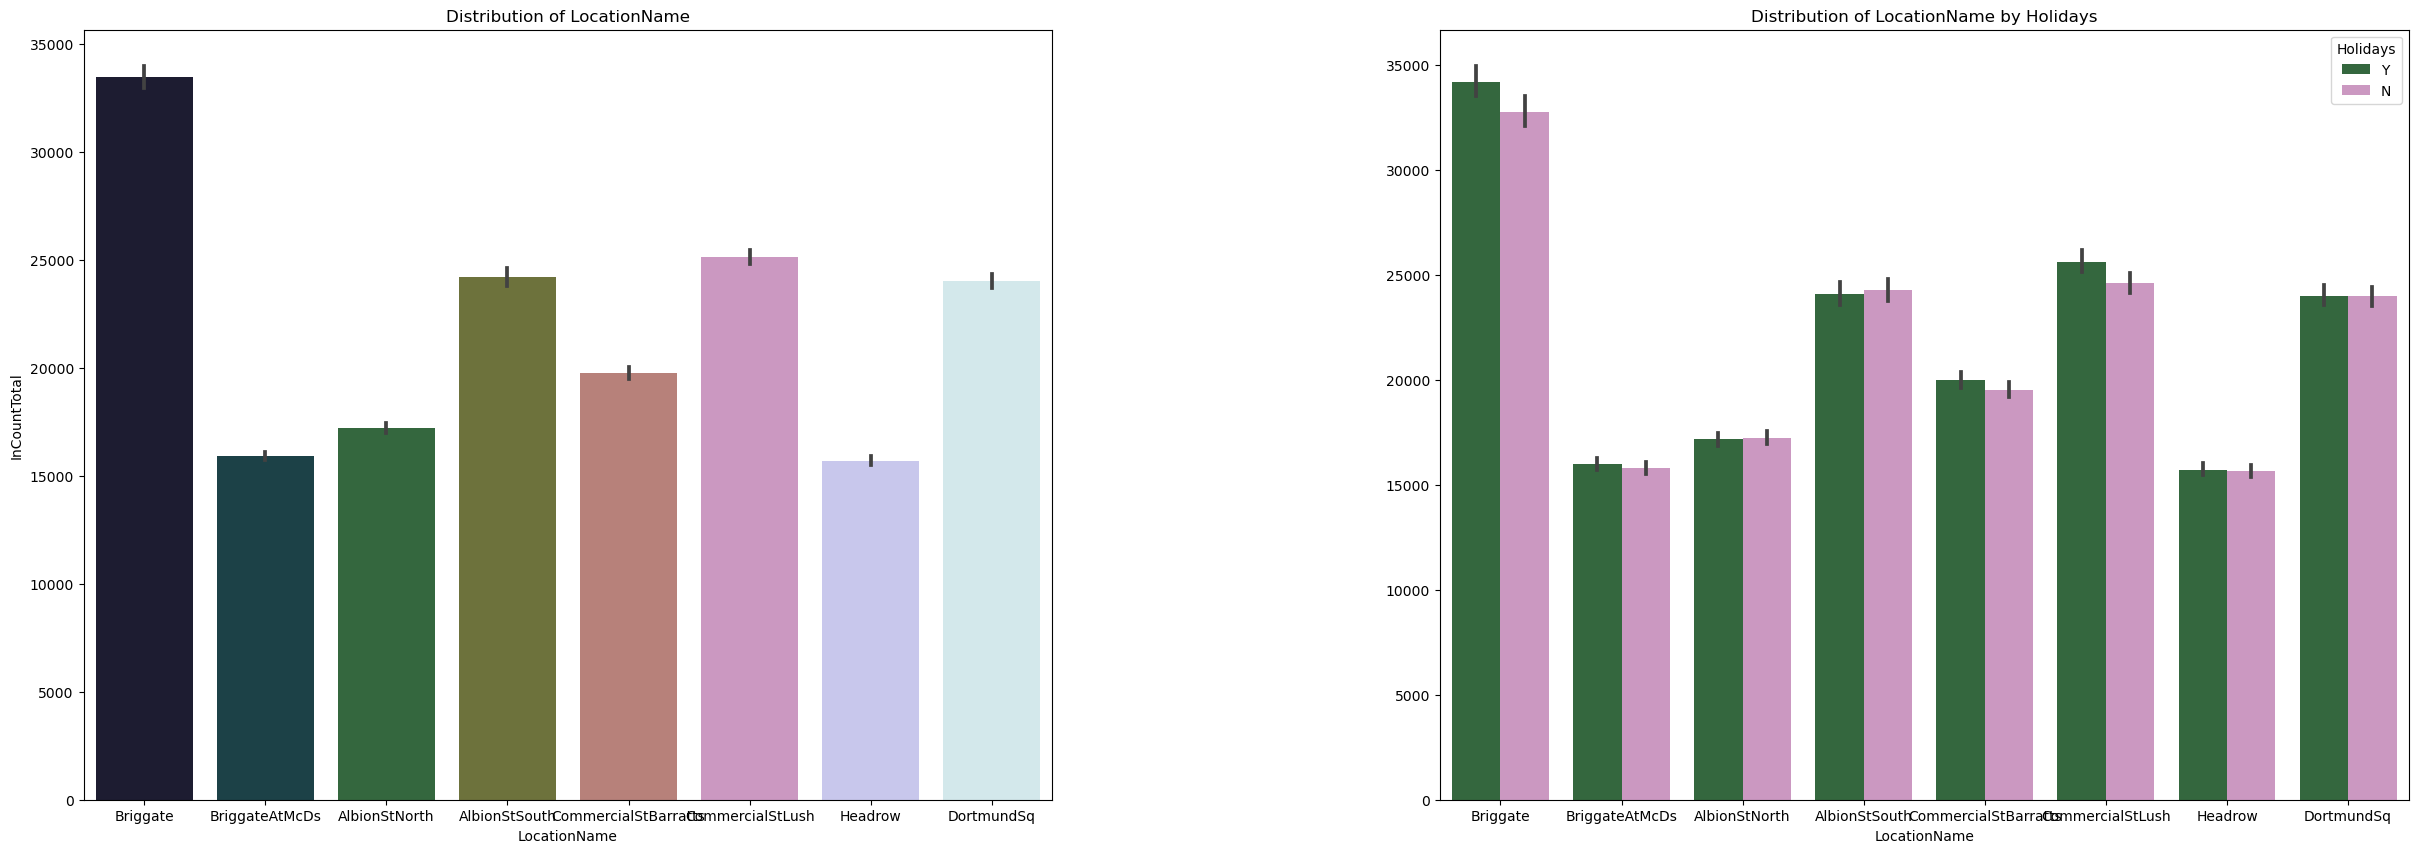

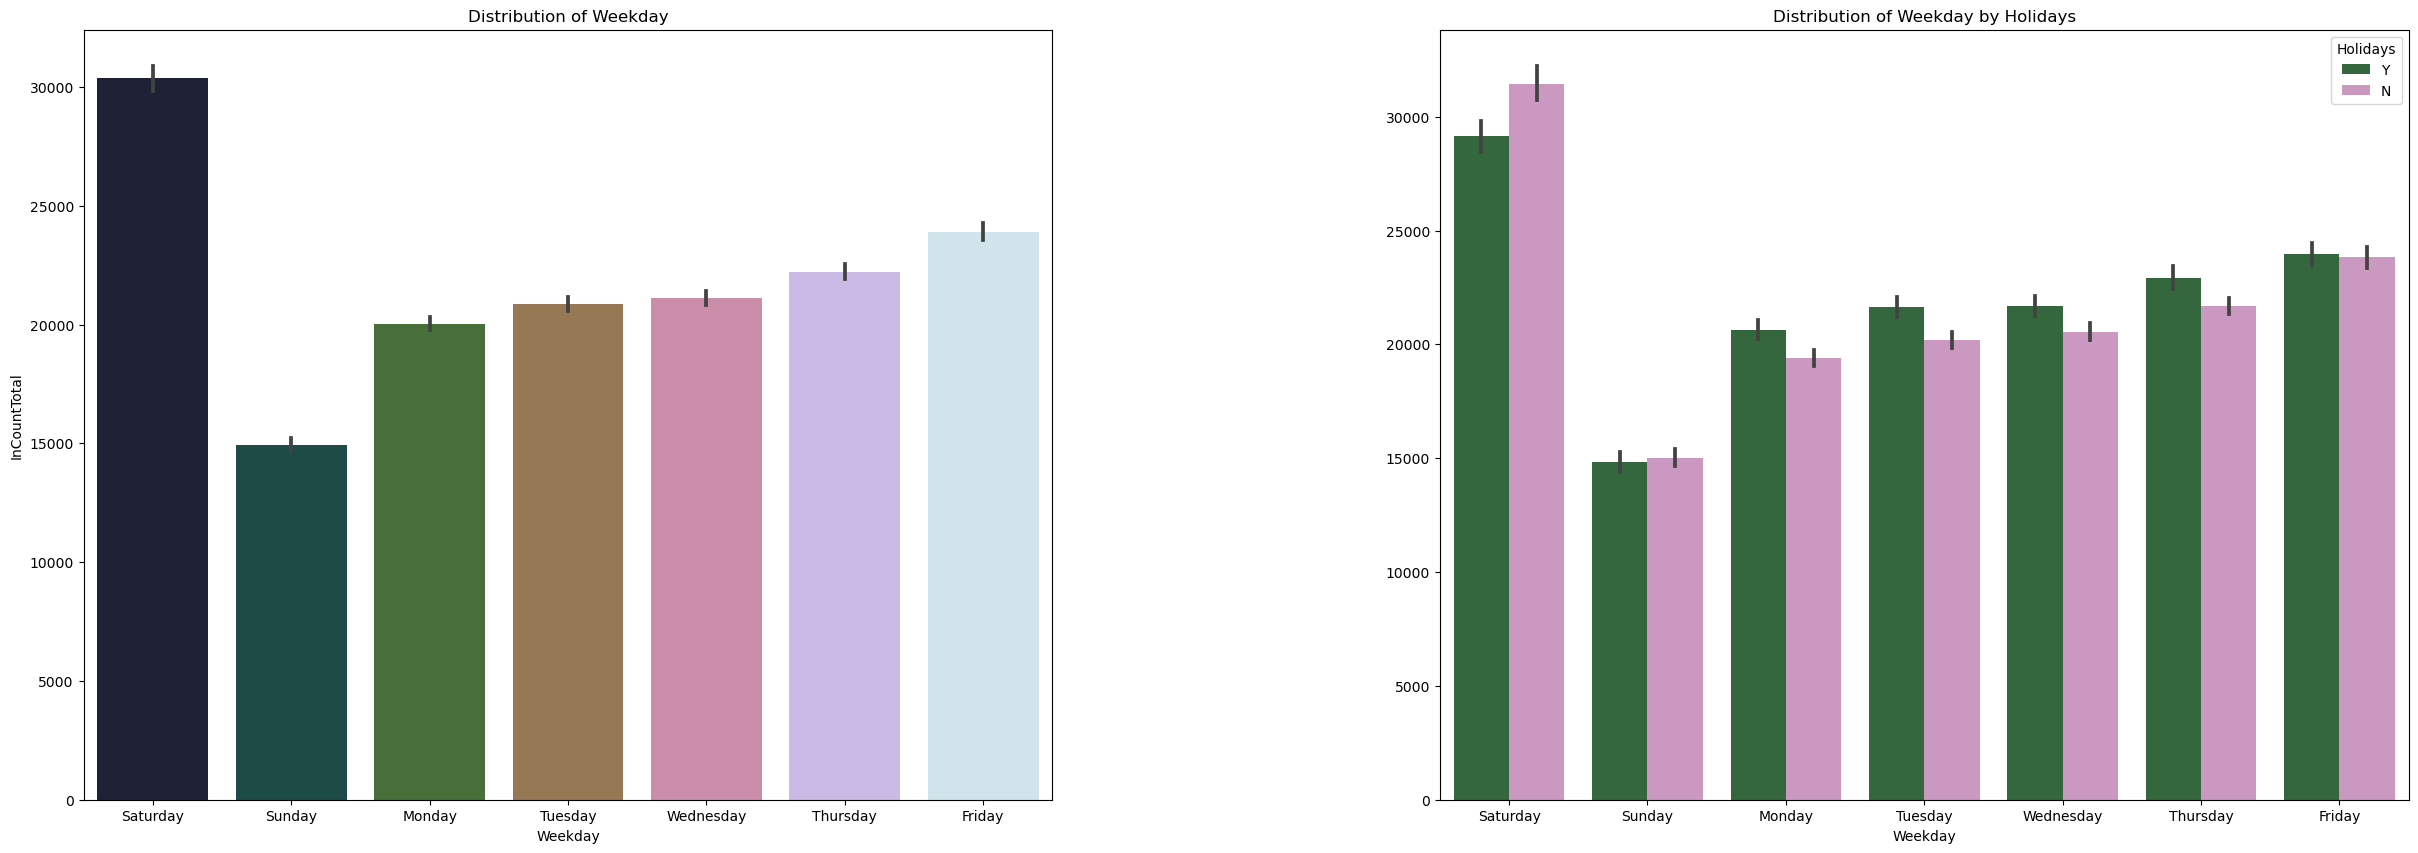

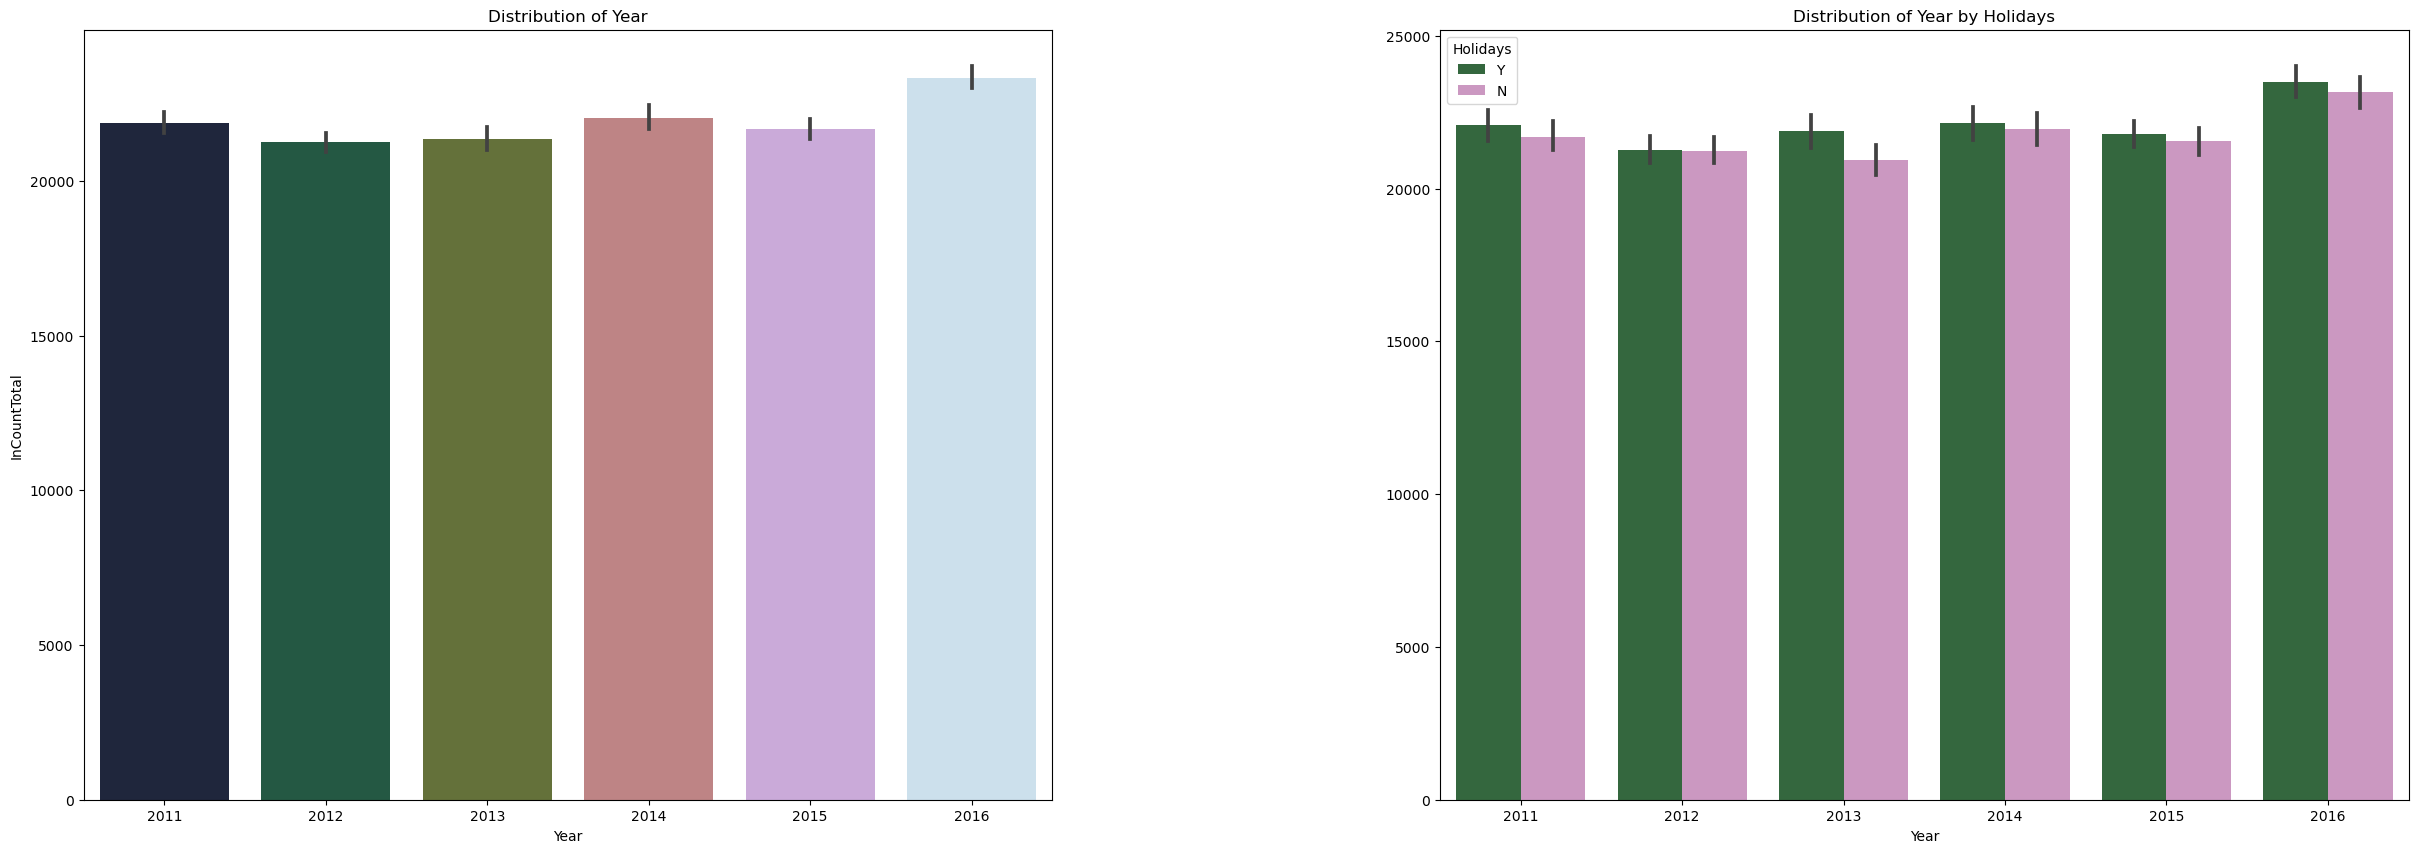

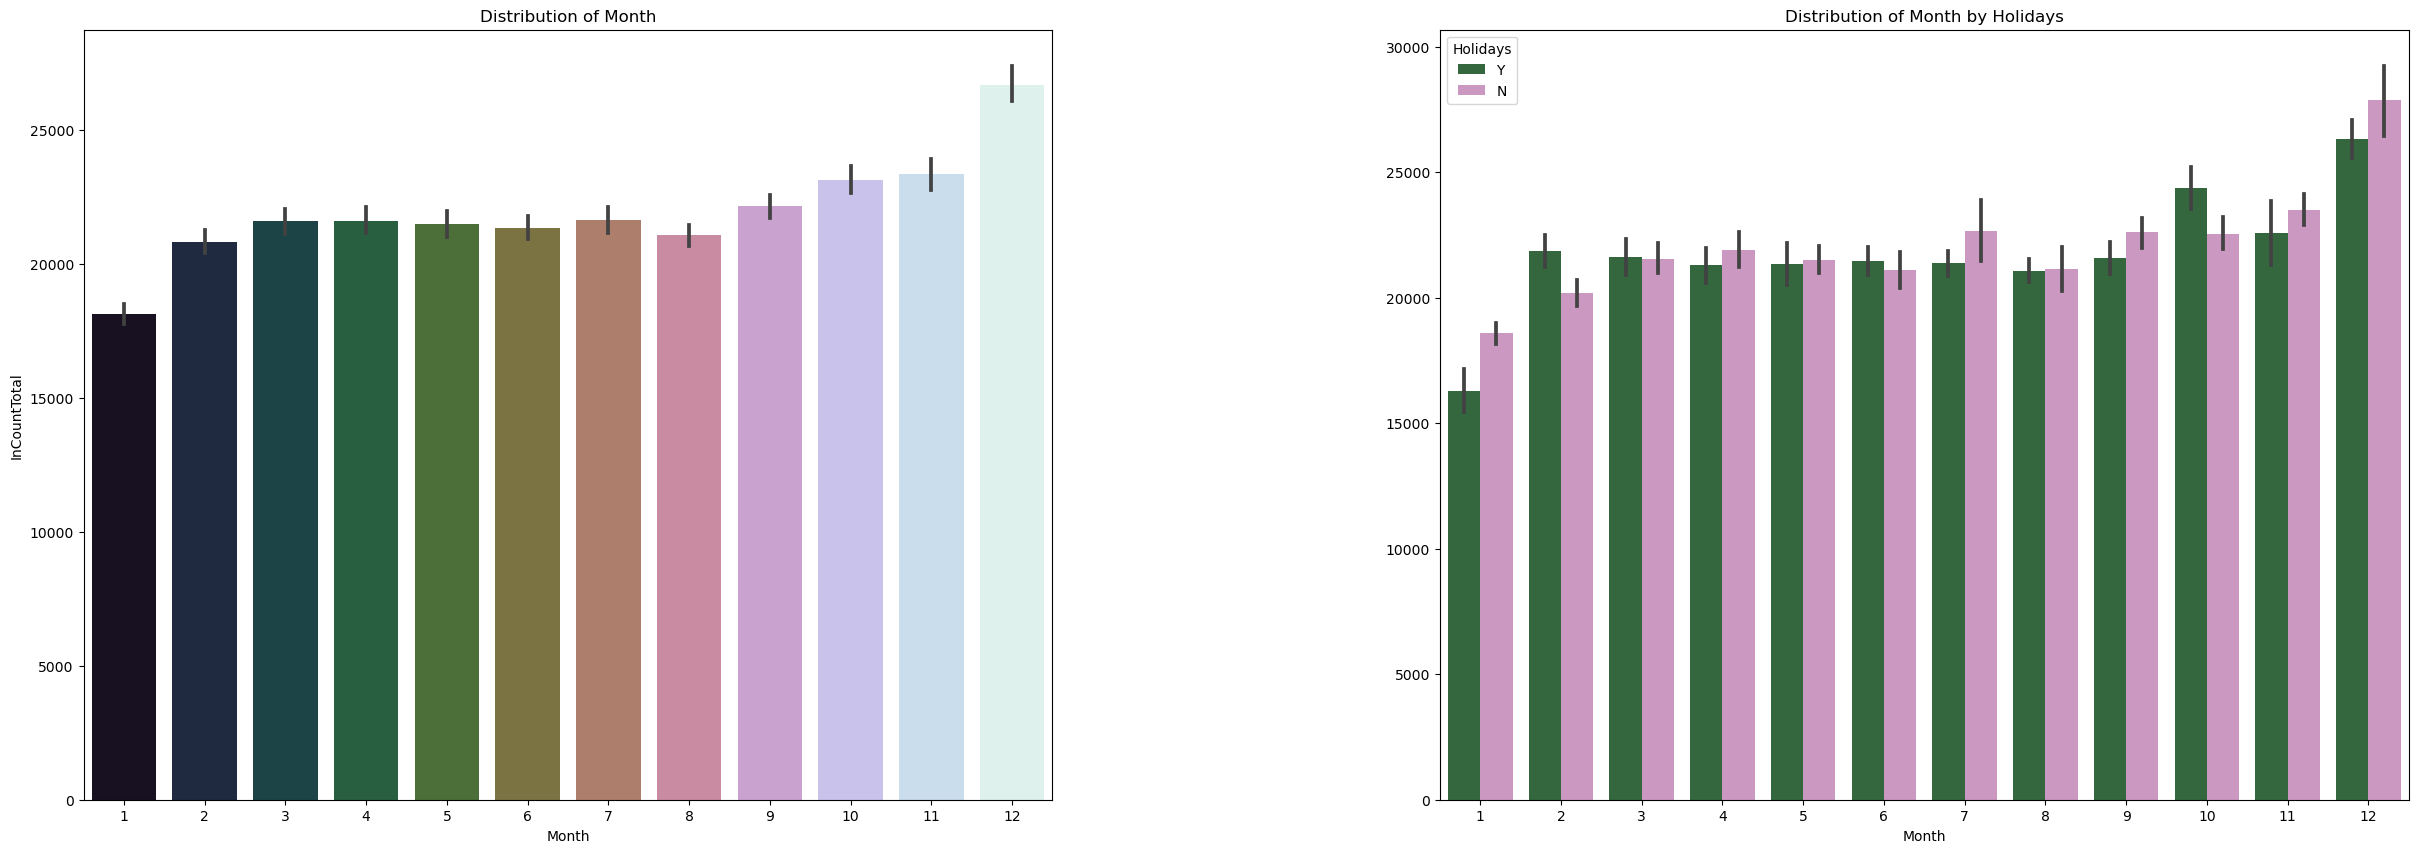

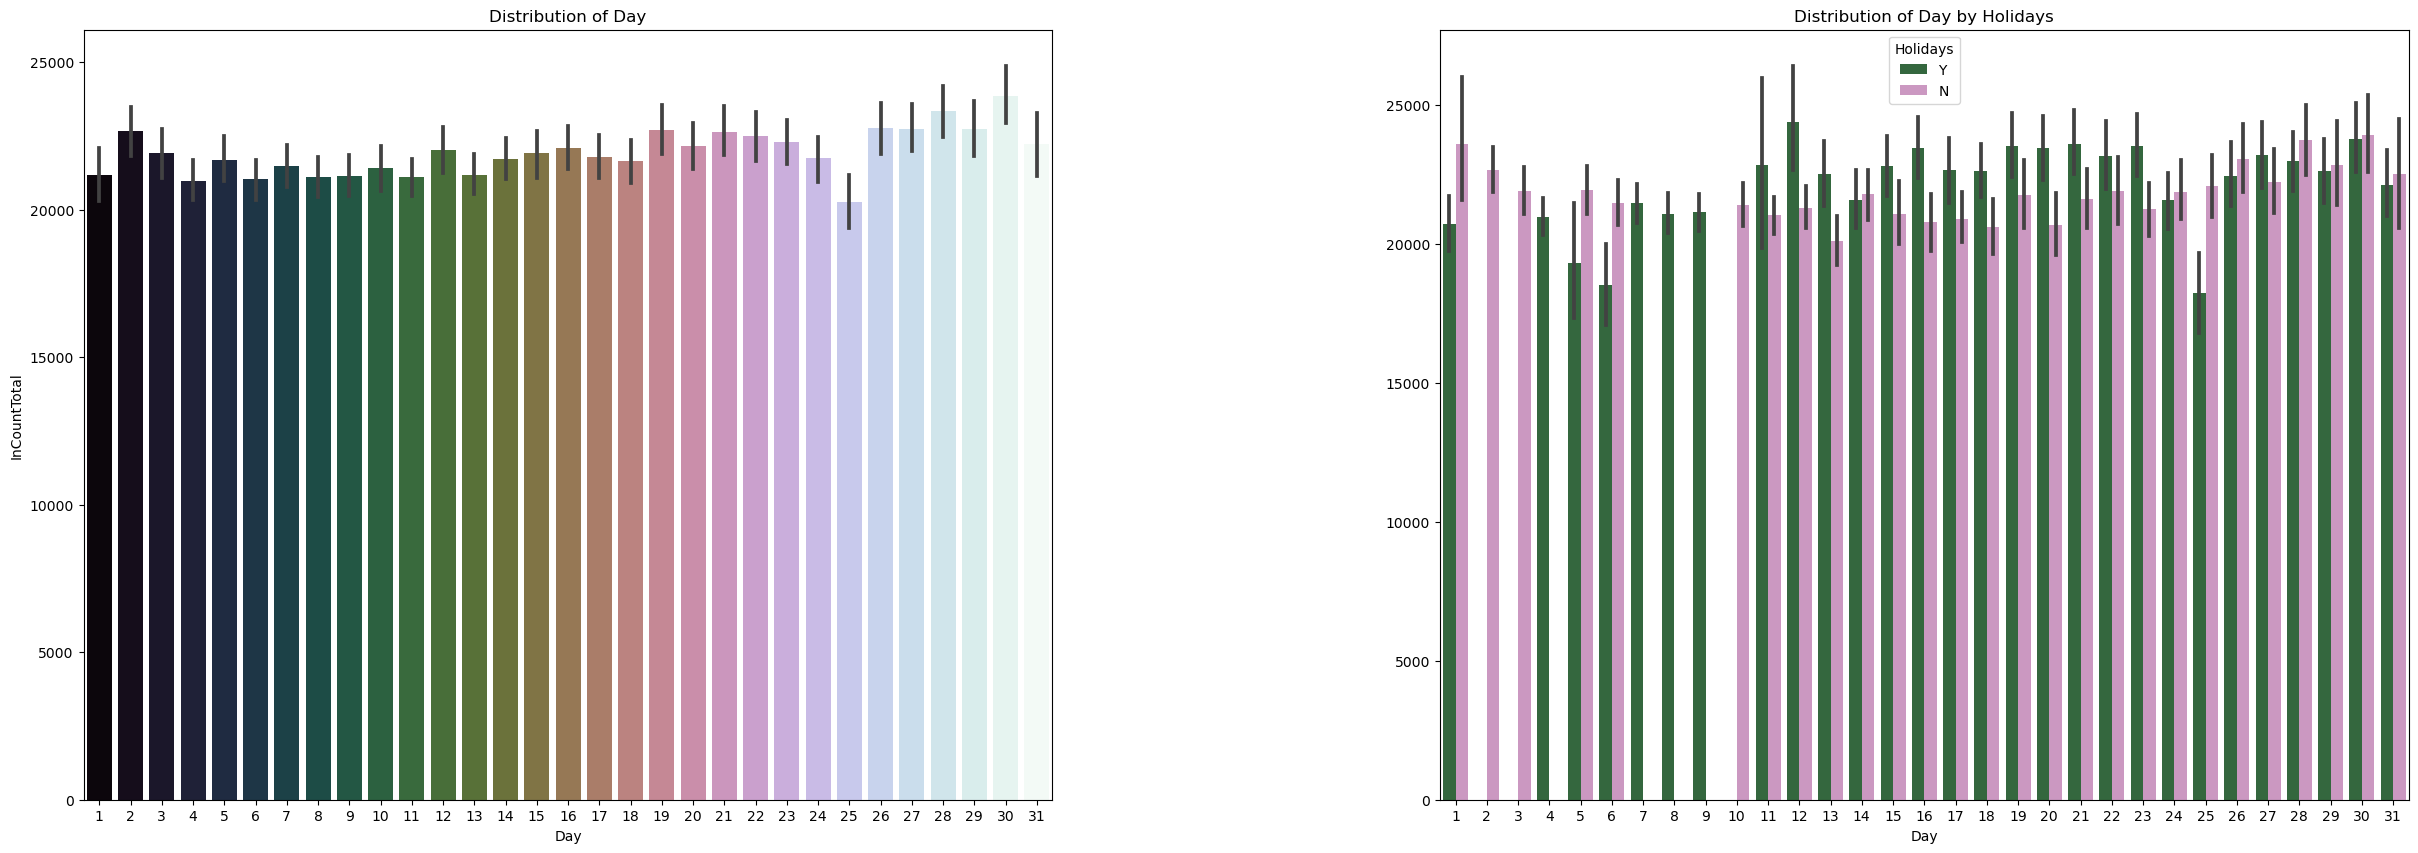

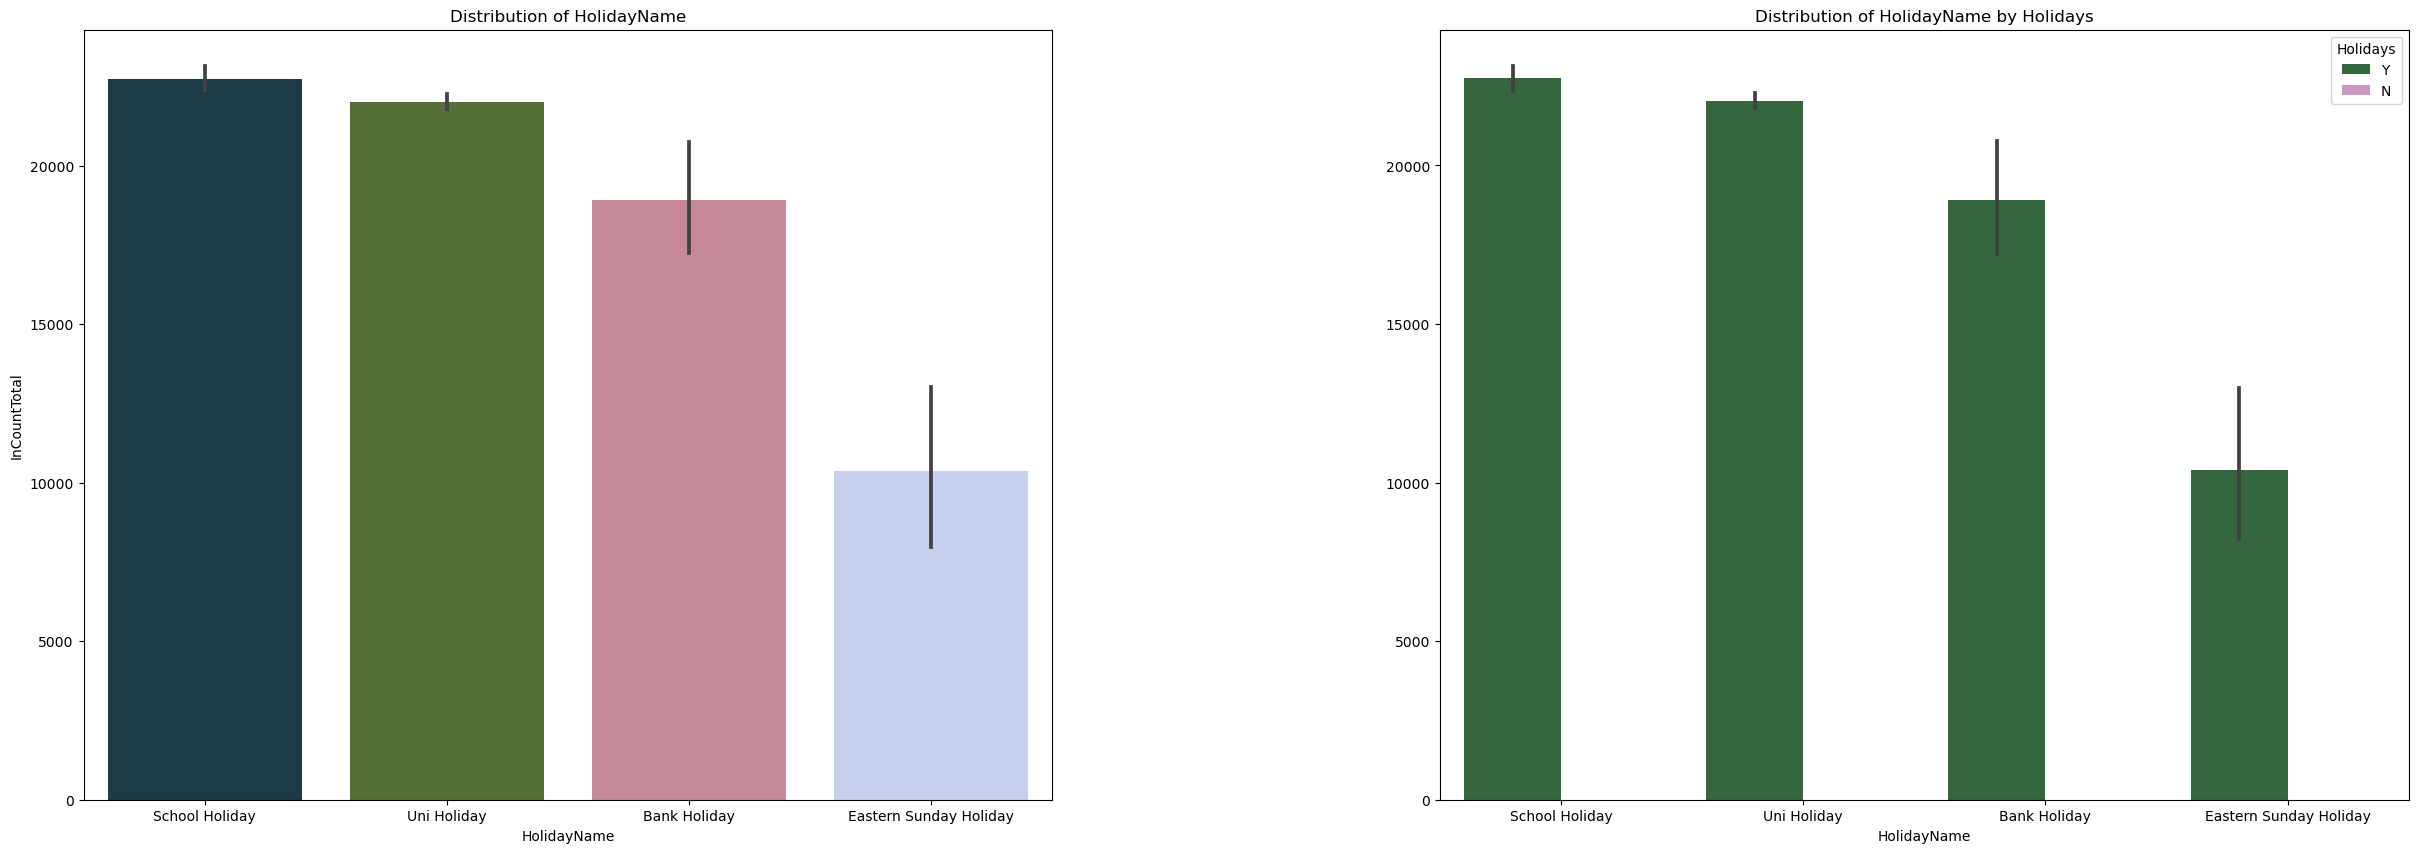

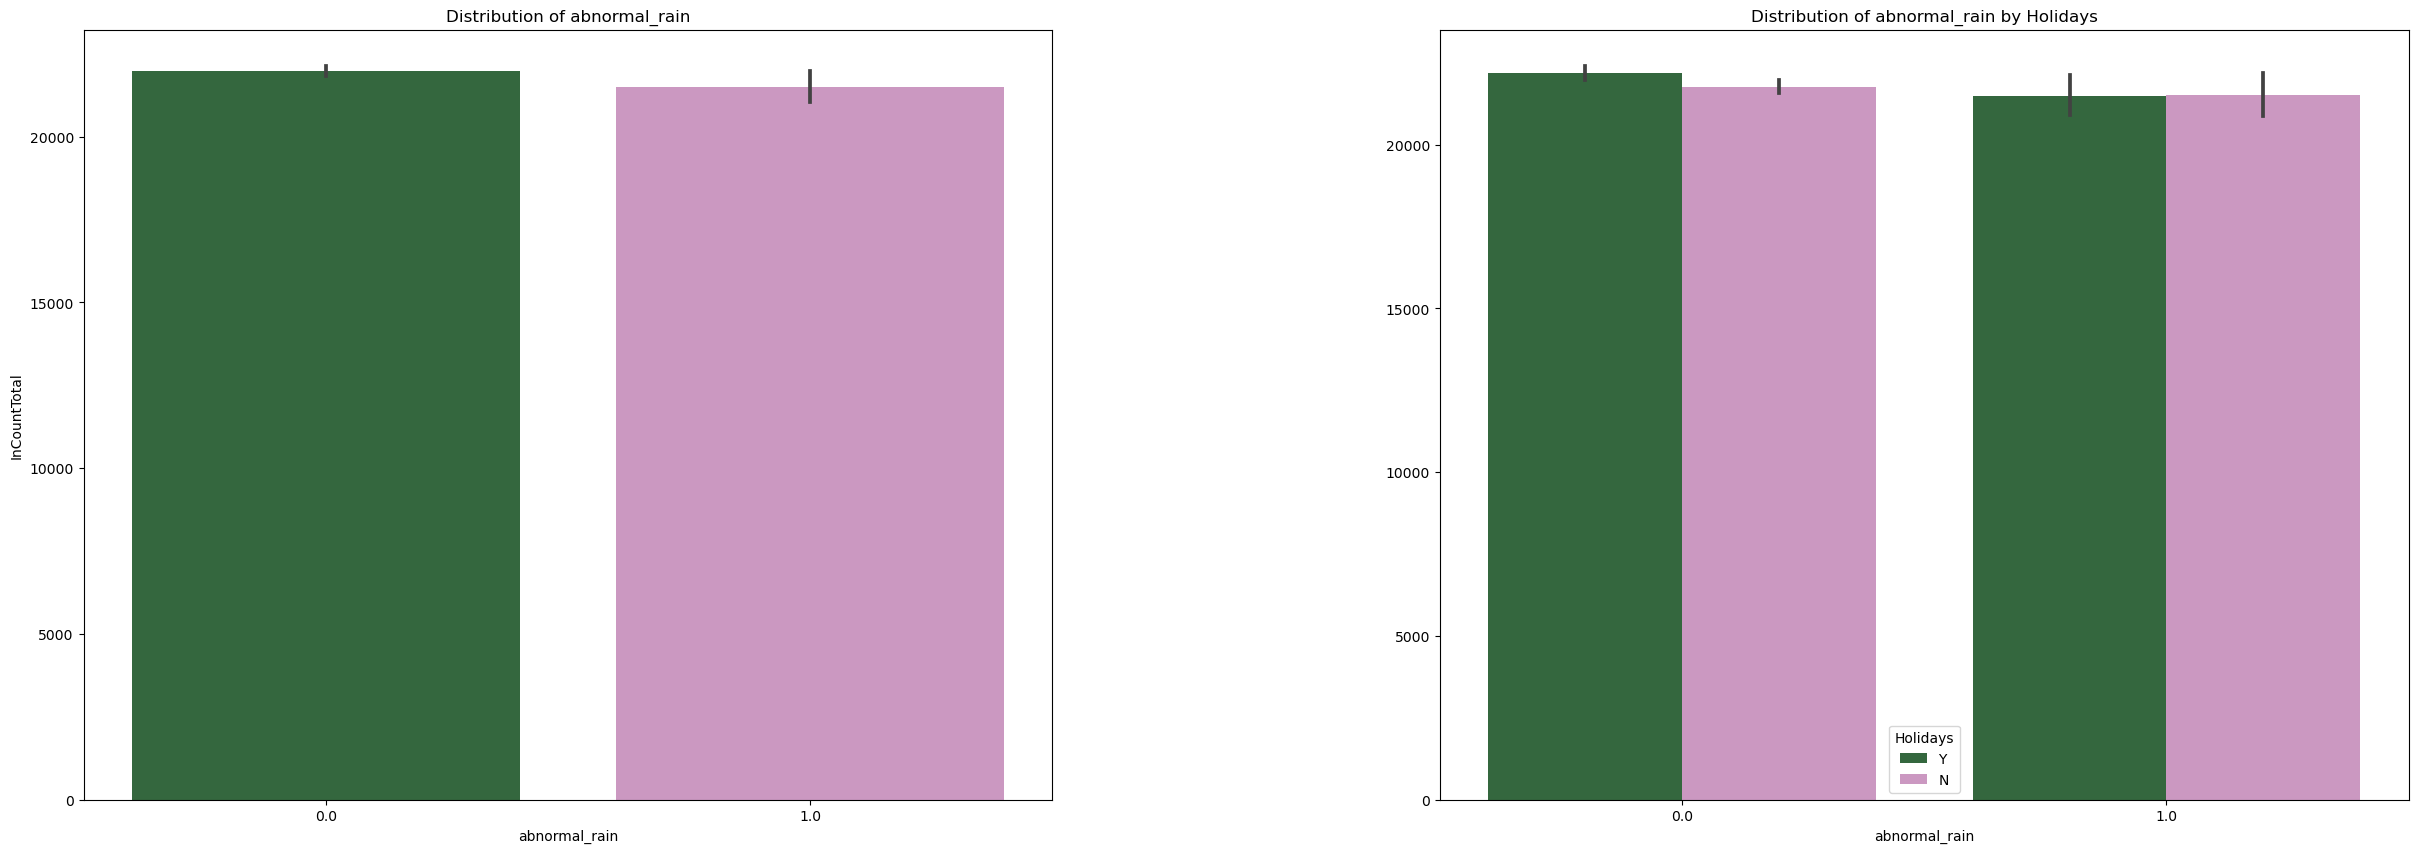

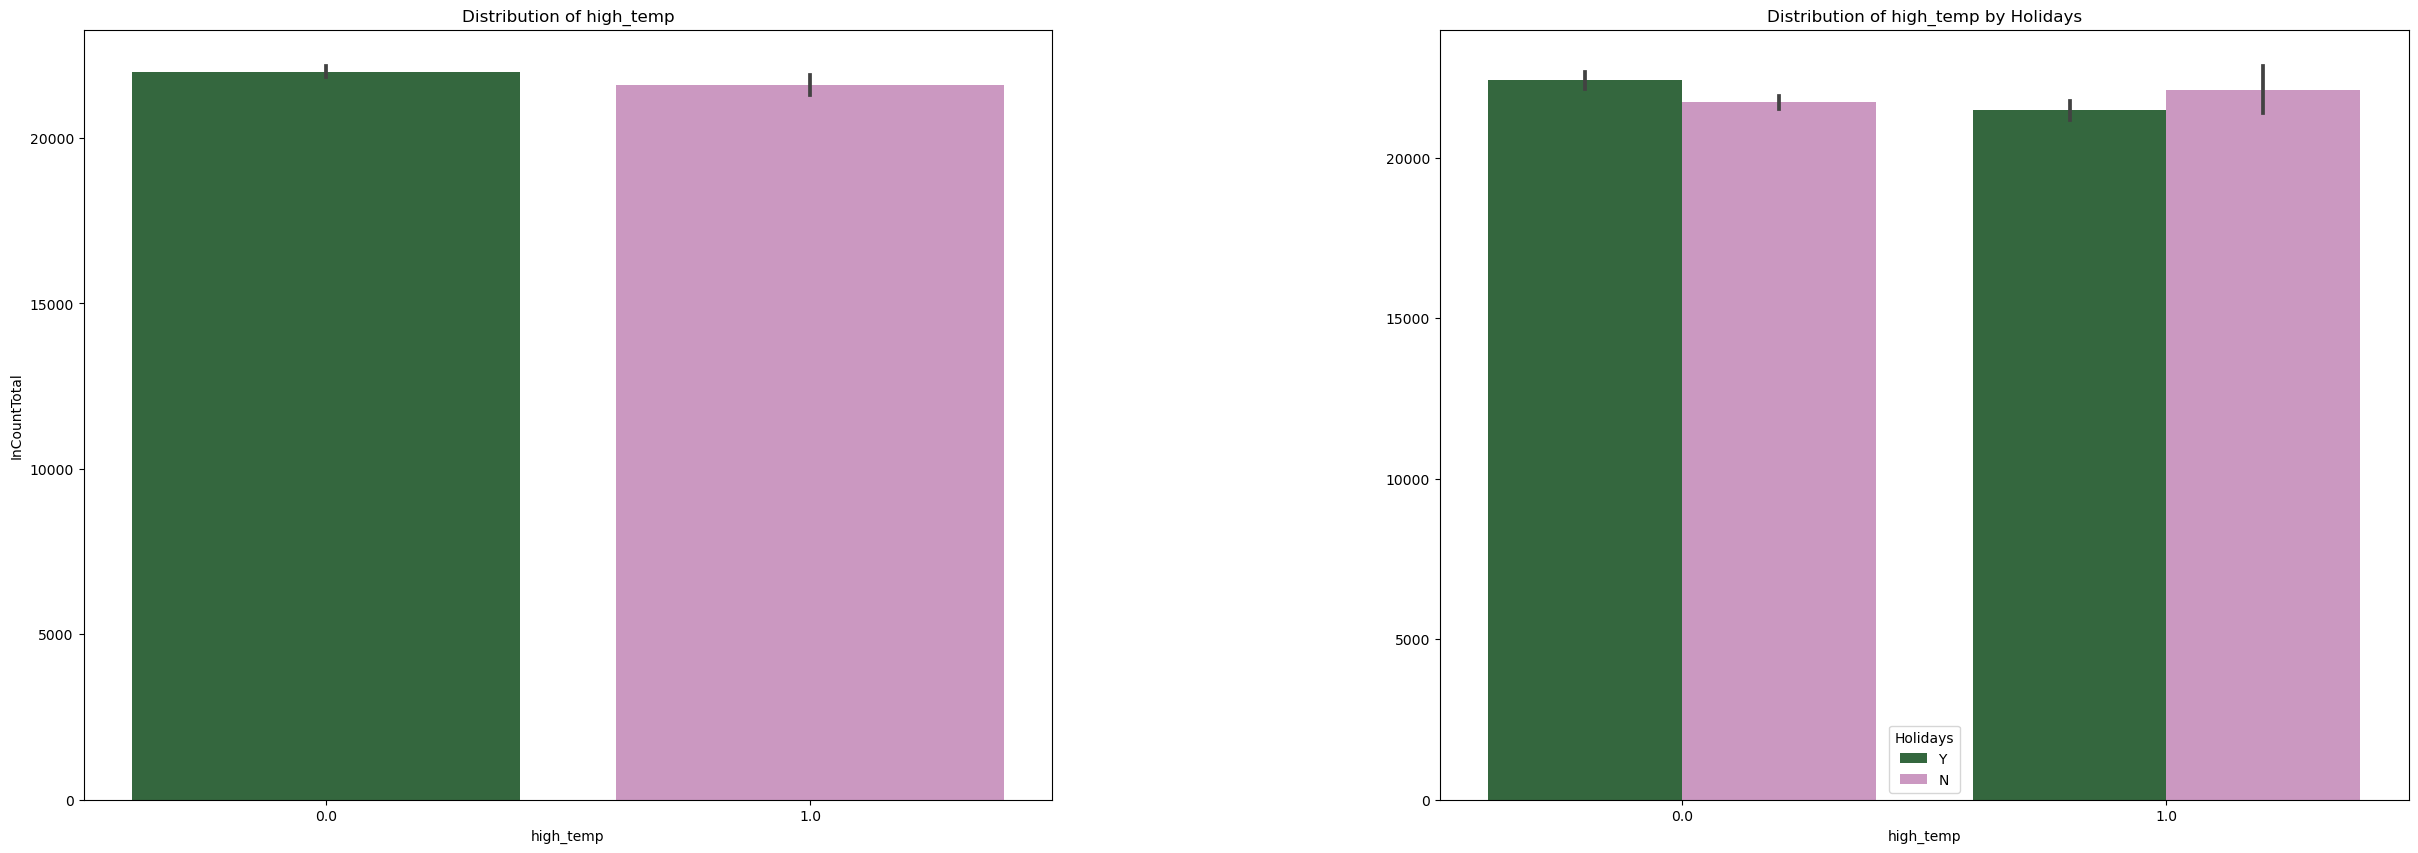

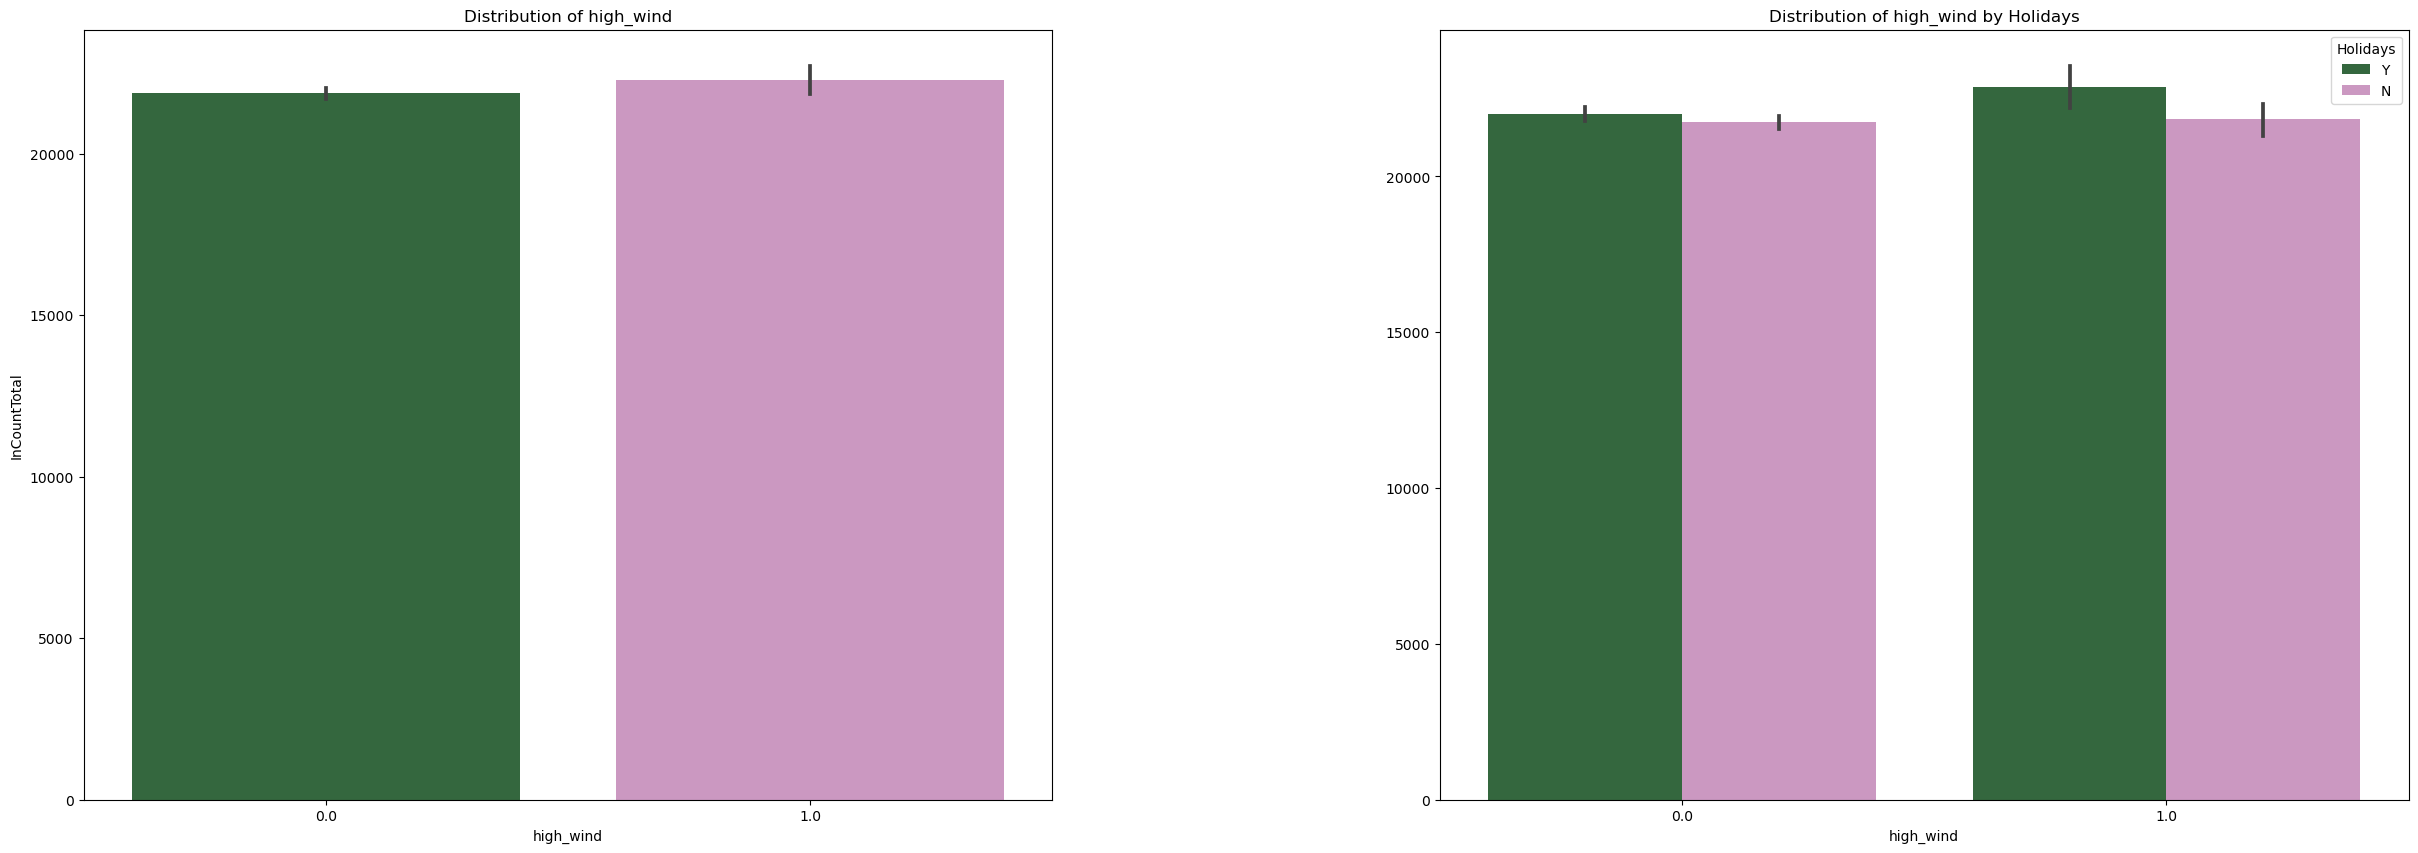

In [ ]:
hue=['Holidays']
barPlot(df_final_viz,['LocationName','Weekday','Year','Month','Day','HolidayName','abnormal_rain','high_temp','high_wind'],hue,'InCountTotal')

### Catplots

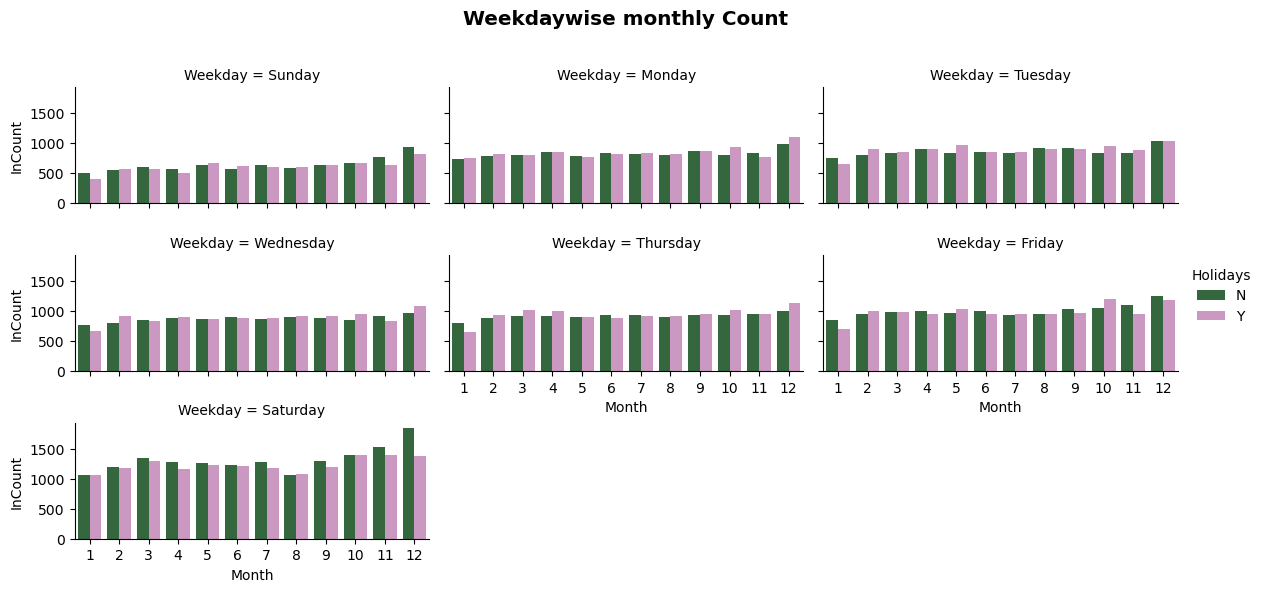

In [ ]:
catPlots(df_final_hr,'Month','InCount','Holidays','Weekday','Weekdaywise monthly Count','bar')

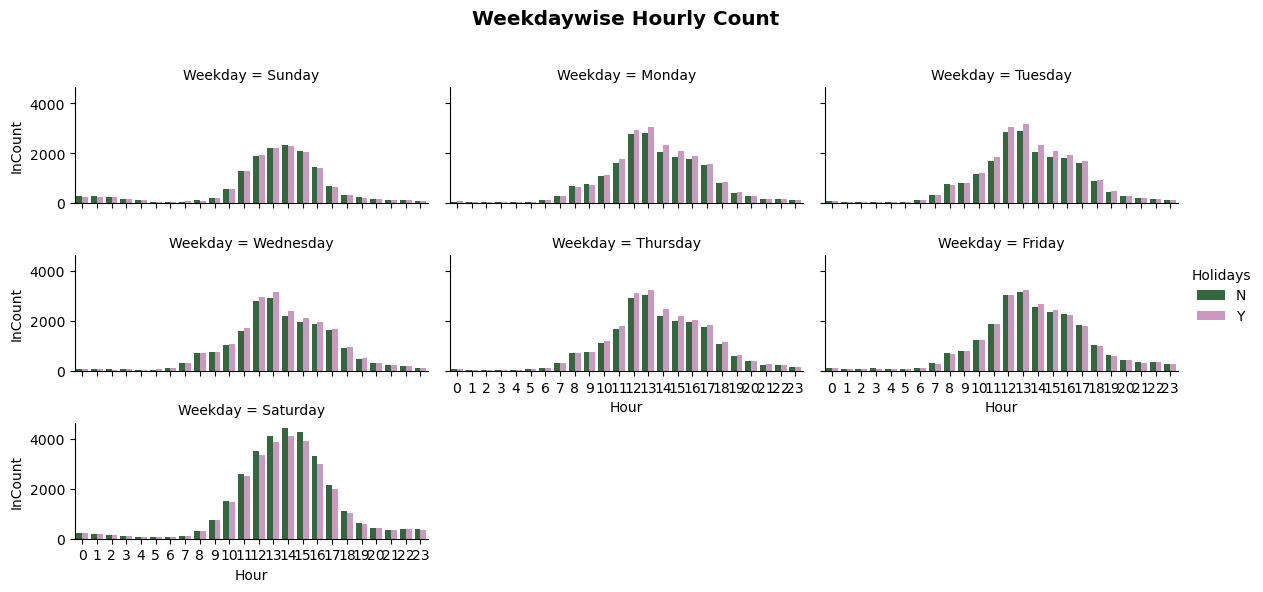

In [ ]:
catPlots(df_final_hr,'Hour','InCount','Holidays','Weekday','Weekdaywise Hourly Count','bar')

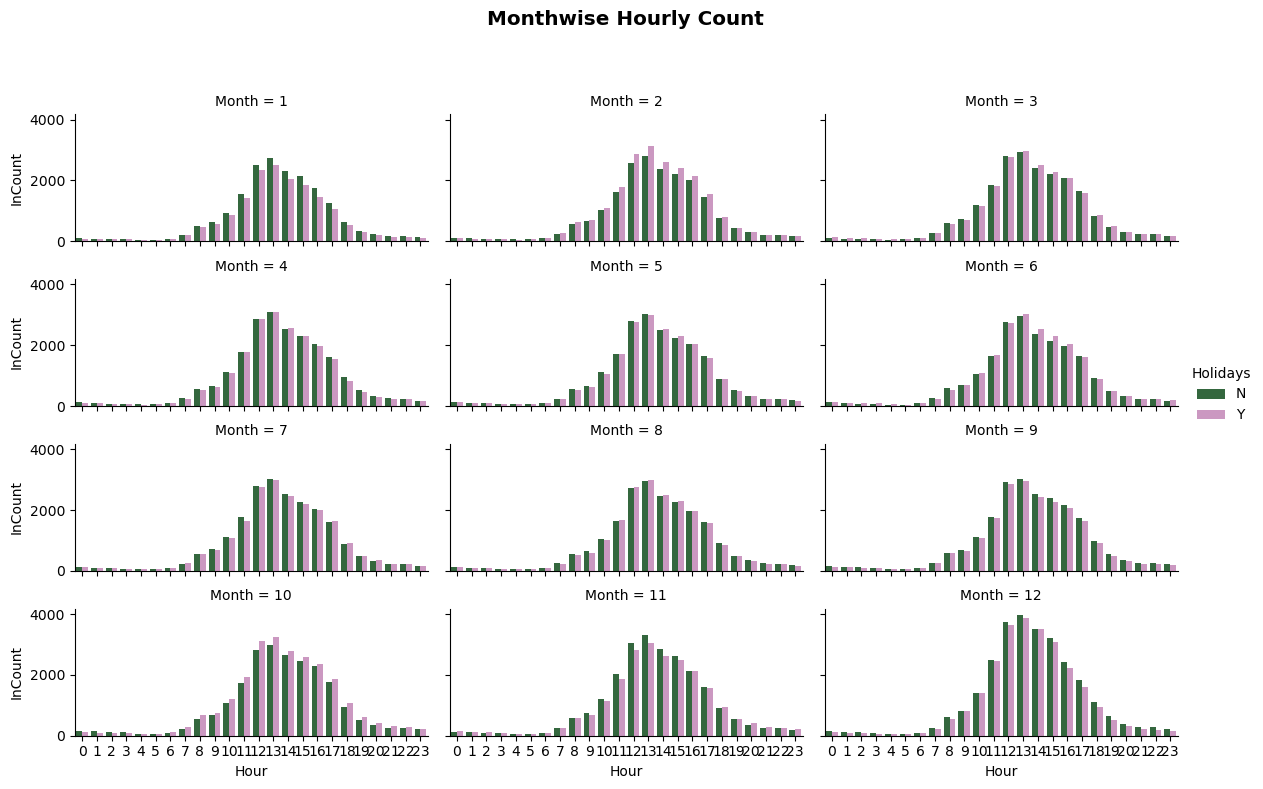

In [ ]:
catPlots(df_final_hr,'Hour','InCount','Holidays','Month','Monthwise Hourly Count','bar')

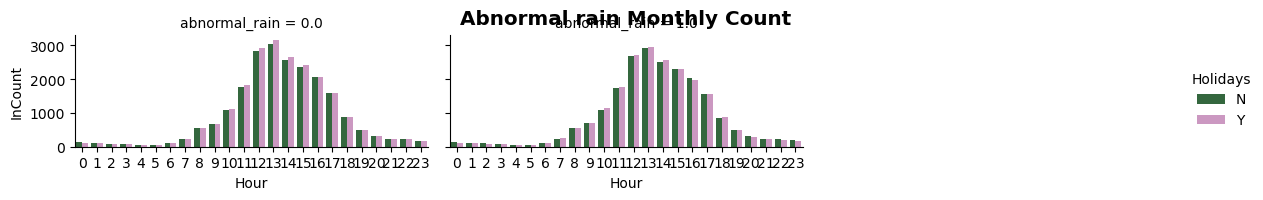

In [ ]:
catPlots(df_final_hr,'Hour','InCount','Holidays','abnormal_rain','Abnormal rain Monthly Count','bar')

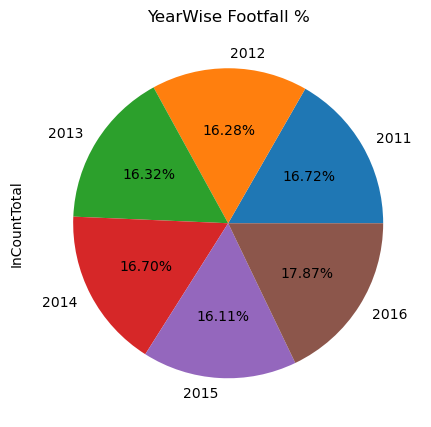

In [ ]:
pie_chart(df_final_viz,'Year')

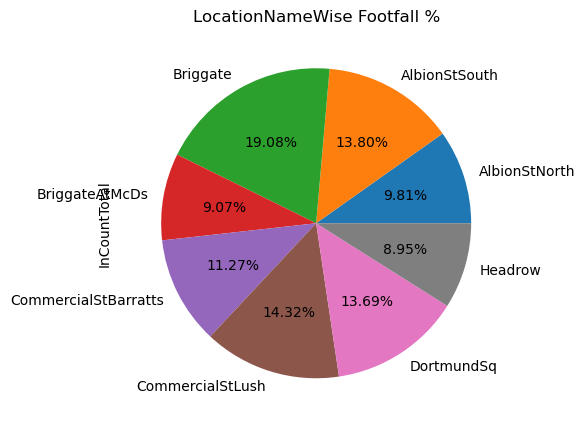

In [ ]:
pie_chart(df_final_viz,'LocationName')

### Pair Plot

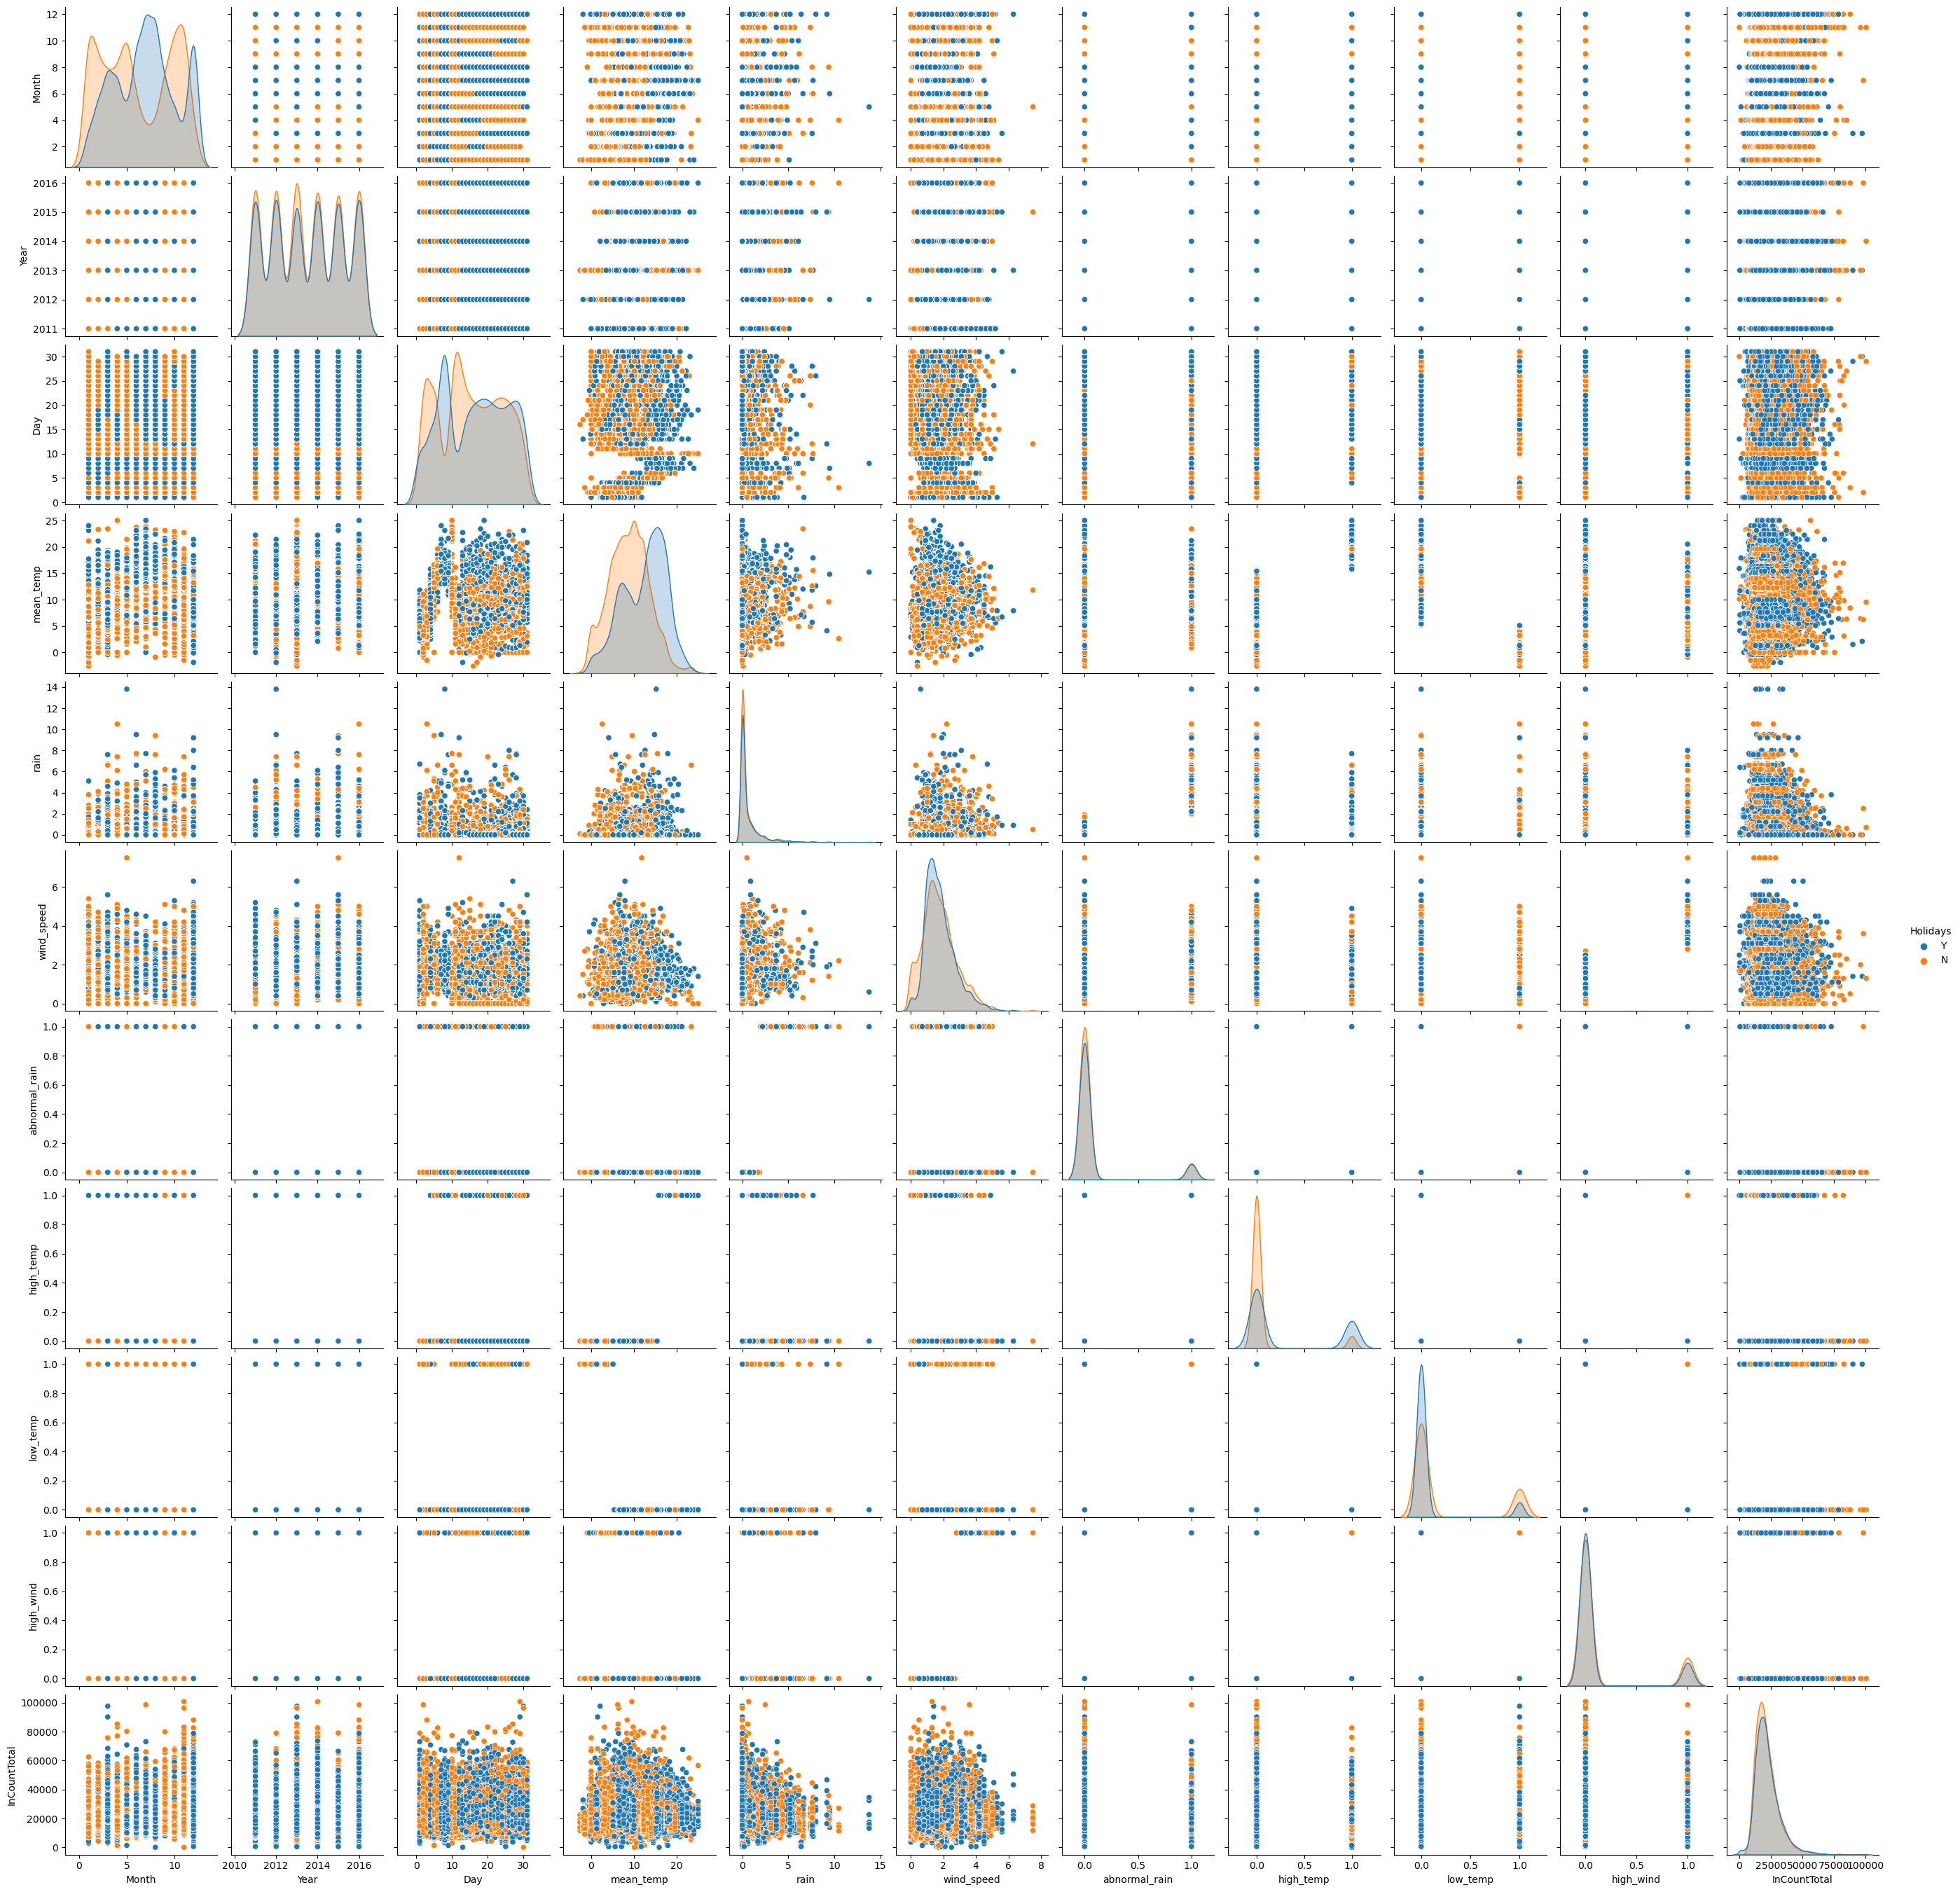

In [ ]:
sns.pairplot(df_final_viz, hue='Holidays')
plt.show()

### Box Plots

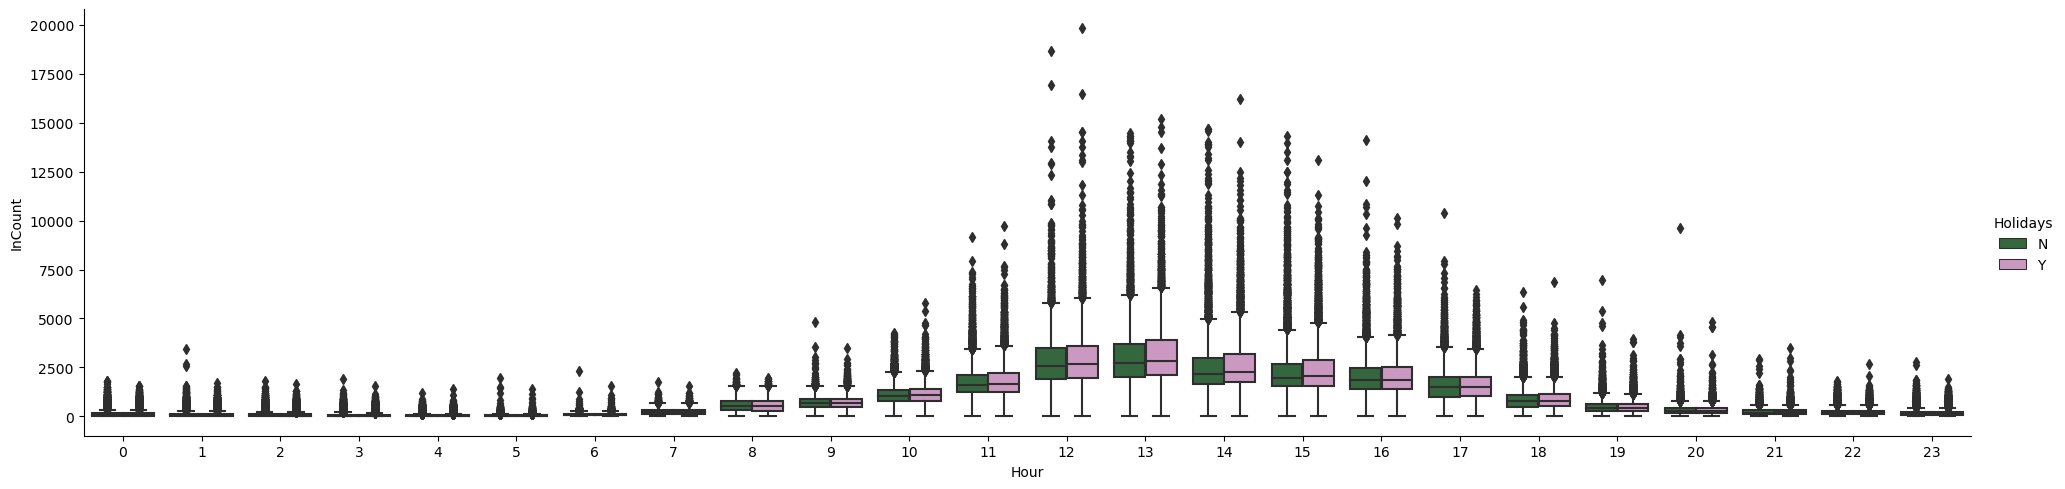

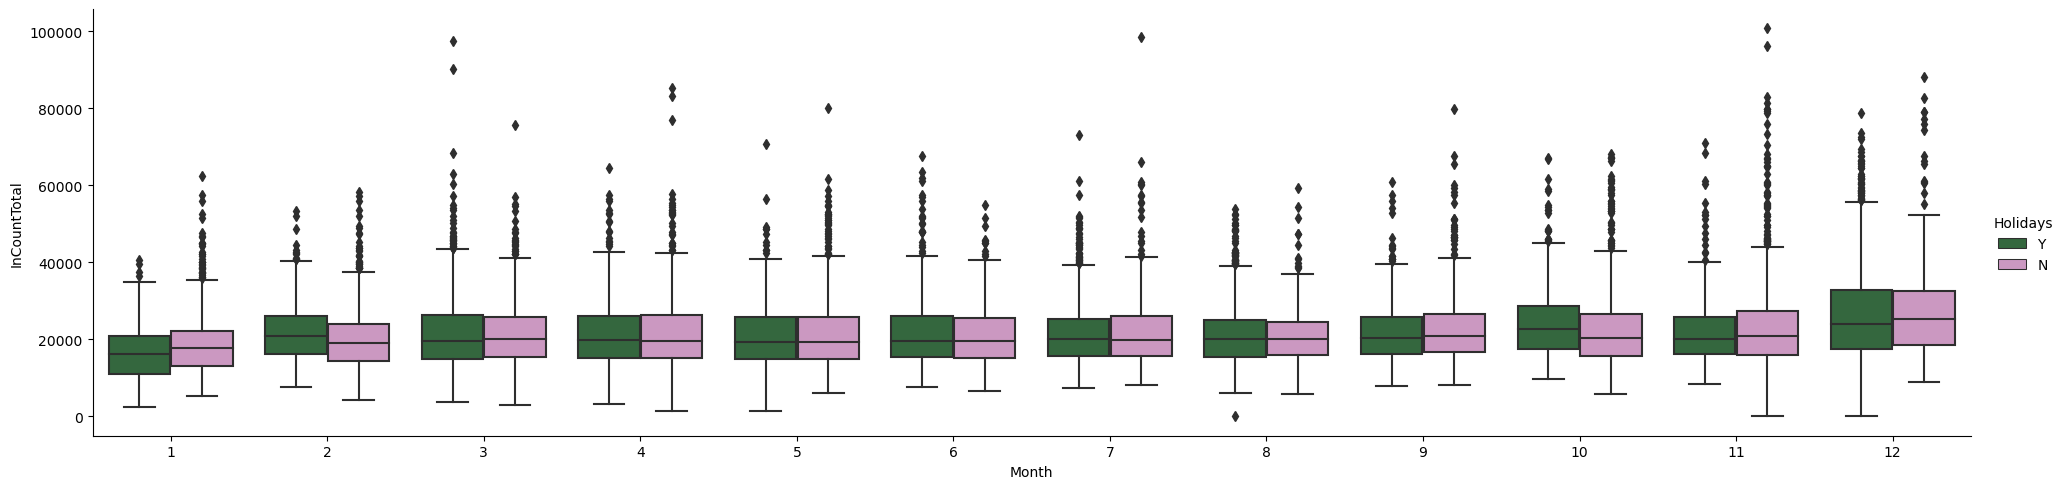

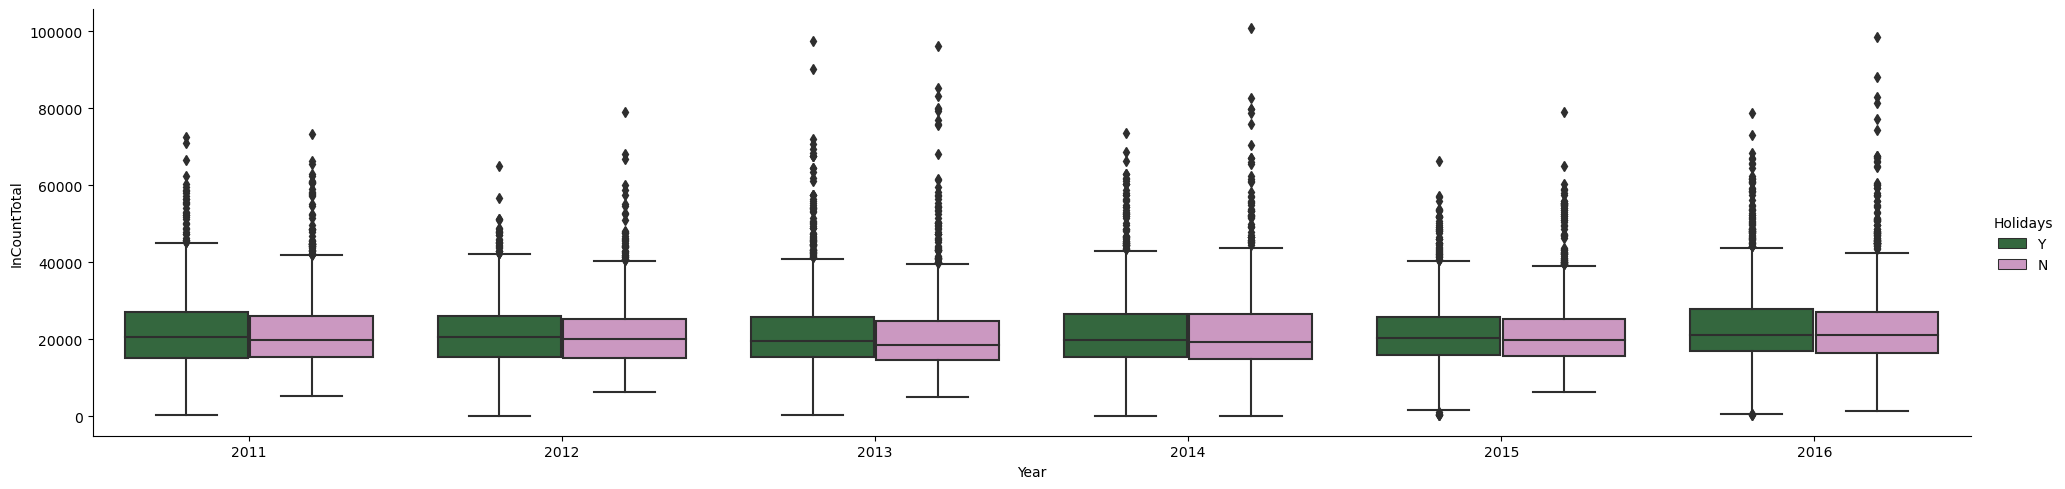

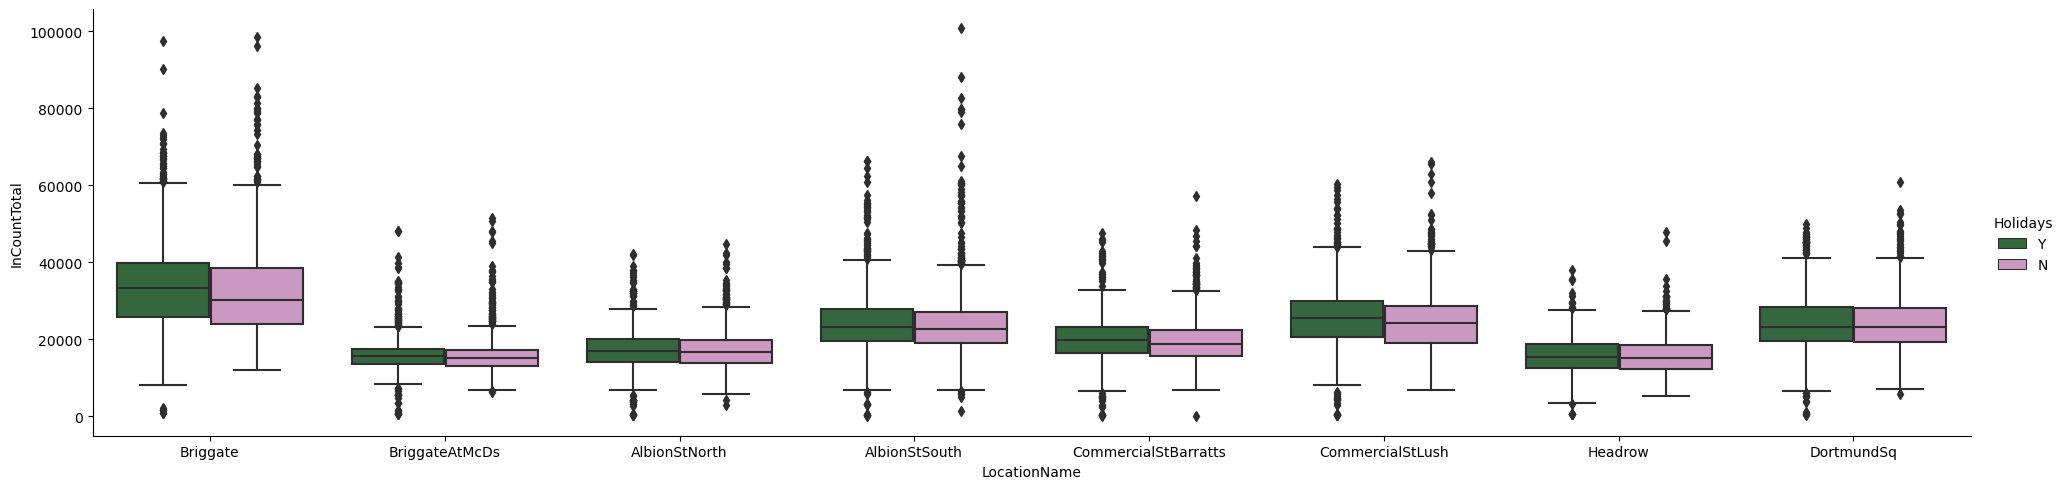

In [ ]:
sns.catplot(data=df_final_hr, x='Hour', y='InCount', hue='Holidays',kind='box',palette='cubehelix',height=5,ci=None,aspect=4)
sns.catplot(data=df_final_viz, x='Month', y='InCountTotal', hue='Holidays',kind='box',palette='cubehelix',height=5,ci=None,aspect=4)
sns.catplot(data=df_final_viz, x='Year', y='InCountTotal', hue='Holidays',kind='box',palette='cubehelix',height=5,ci=None,aspect=4)
sns.catplot(data=df_final_viz, x='LocationName', y='InCountTotal', hue='Holidays',kind='box',palette='cubehelix',height=5,ci=None,aspect=4)



## Time Series plots

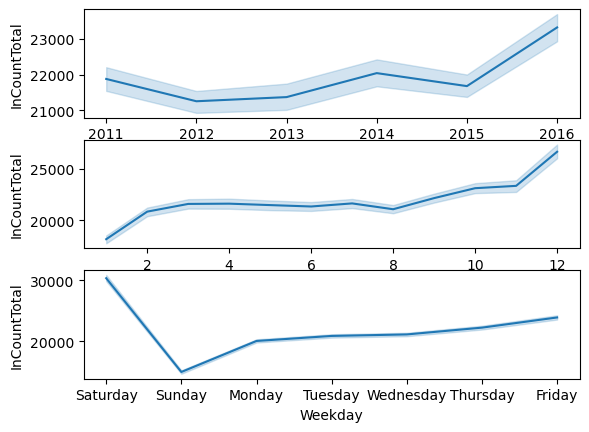

In [ ]:
f, axes = plt.subplots(3, 1)
#plt.figure(figsize=(5,2))
sns.lineplot(data=df_final_viz, x='Year',y='InCountTotal',palette='tab10',ax=axes[0],legend='full')
sns.lineplot(data=df_final_viz, x='Month',y='InCountTotal',palette='crest',ax=axes[1],legend='full')
sns.lineplot(data=df_final_viz, x='Weekday',y='InCountTotal',palette='light:b',ax=axes[2],legend='full')
plt.show()

**Observations:**

1.There is an upward trend in the footfall year on year.

2.There is an upward trend in the footfall from August till december. December month has the highest footfall

3.There is a gradual increase in footfall from Sunday to Saturday , saturday being the highest

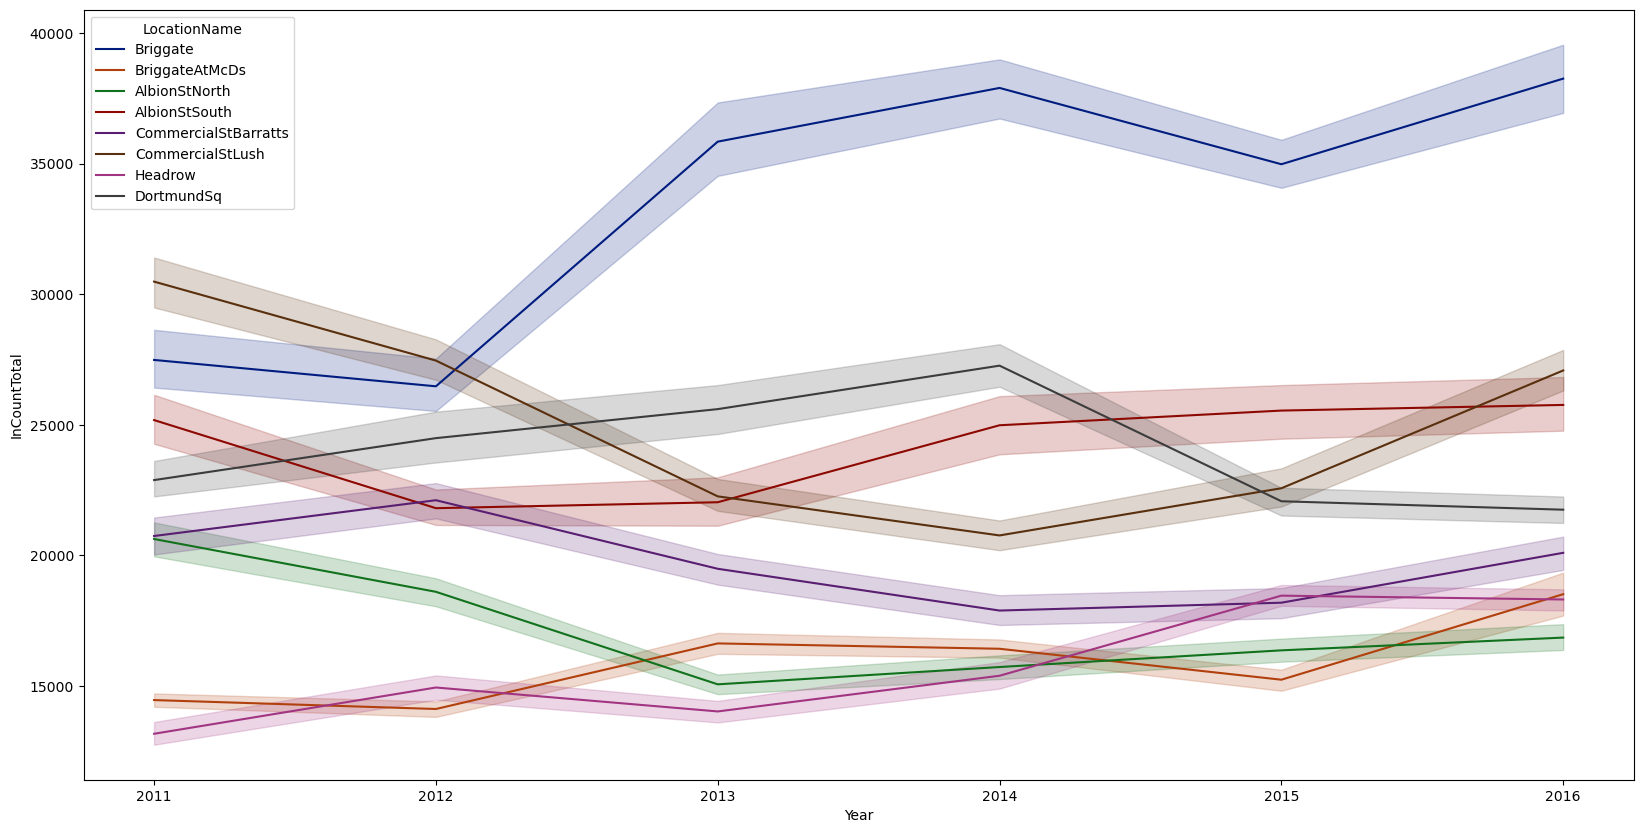

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_final_viz, x='Year',y='InCountTotal',hue='LocationName',palette='dark',legend='full')
plt.show()

<AxesSubplot:xlabel='Year', ylabel='InCountTotal'>

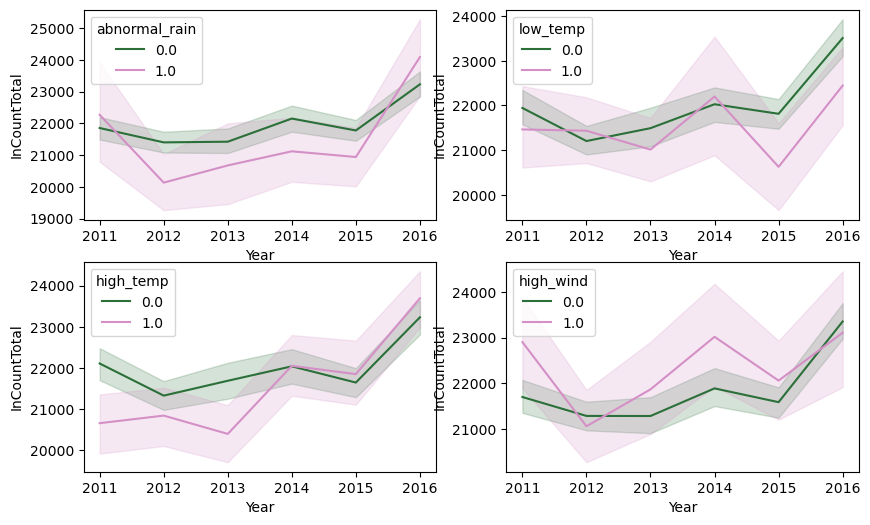

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(10,6))
sns.lineplot(data=df_final_viz,x='Year', y="InCountTotal",hue='abnormal_rain',ax=axes[0,0],palette='cubehelix')
sns.lineplot(data=df_final_viz,x='Year', y="InCountTotal",hue='low_temp',ax=axes[0,1],palette='cubehelix')
sns.lineplot(data=df_final_viz,x='Year', y="InCountTotal",hue='high_temp',ax=axes[1,0],palette='cubehelix')
sns.lineplot(data=df_final_viz,x='Year', y="InCountTotal",hue='high_wind',ax=axes[1,1],palette='cubehelix')

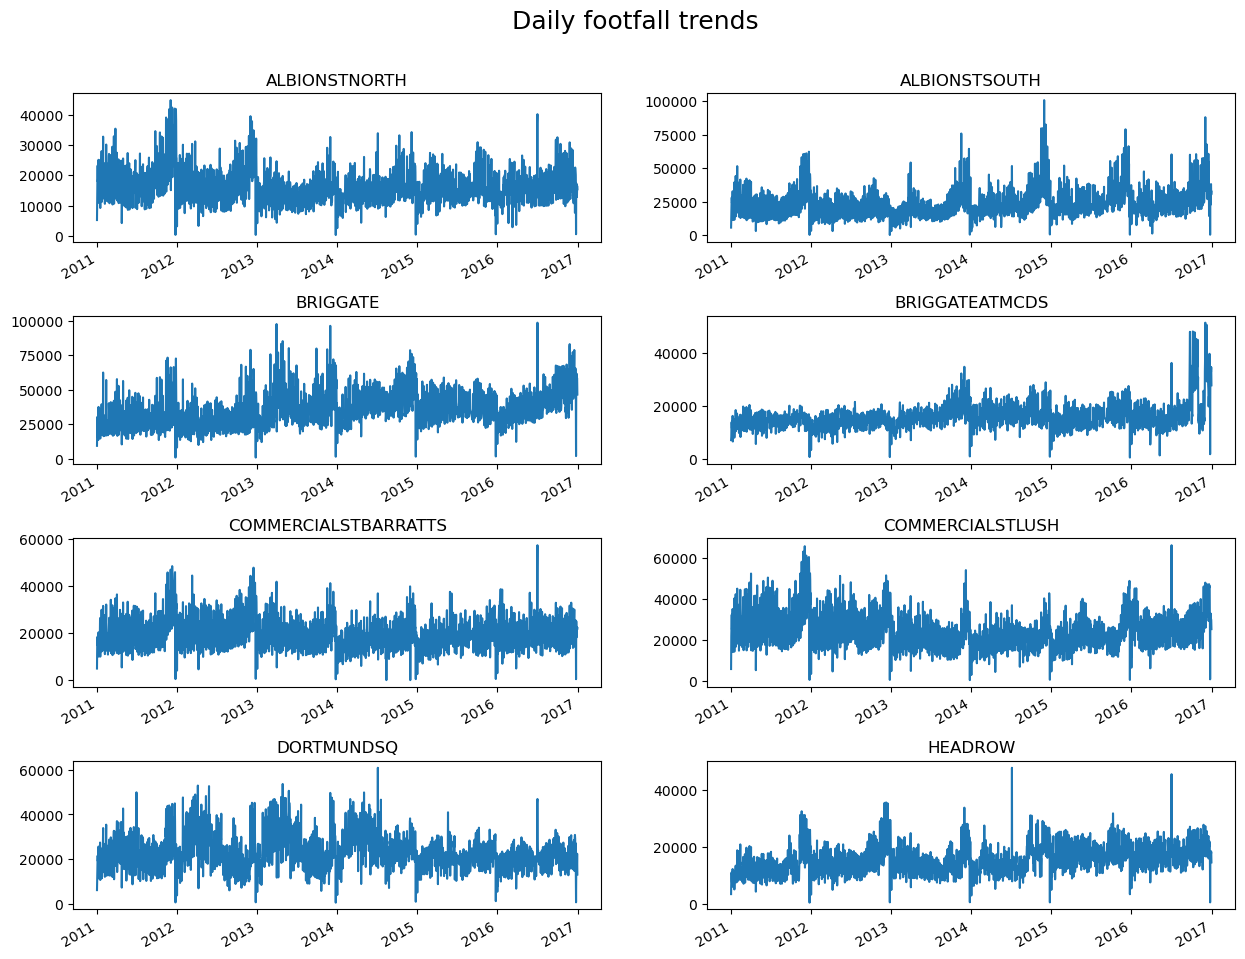

In [ ]:
Gates=['AlbionStNorth', 'AlbionStSouth', 'Briggate', 'BriggateAtMcDs',
       'CommercialStBarratts', 'CommercialStLush', 'DortmundSq',
       'Headrow']
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Daily footfall trends", fontsize=18, y=0.95)

# loop through the length of gates and keep track of index
for n, gates in enumerate(Gates):
    # add a new subplot iteratively
    ax = plt.subplot(4, 2, n + 1)

    # filter df and plot footfall on the new subplot axis
    df_final_viz[df_final_viz["LocationName"] == gates].plot(x='Date',y='InCountTotal',ax=ax)

    # chart formatting
    ax.set_title(gates.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")

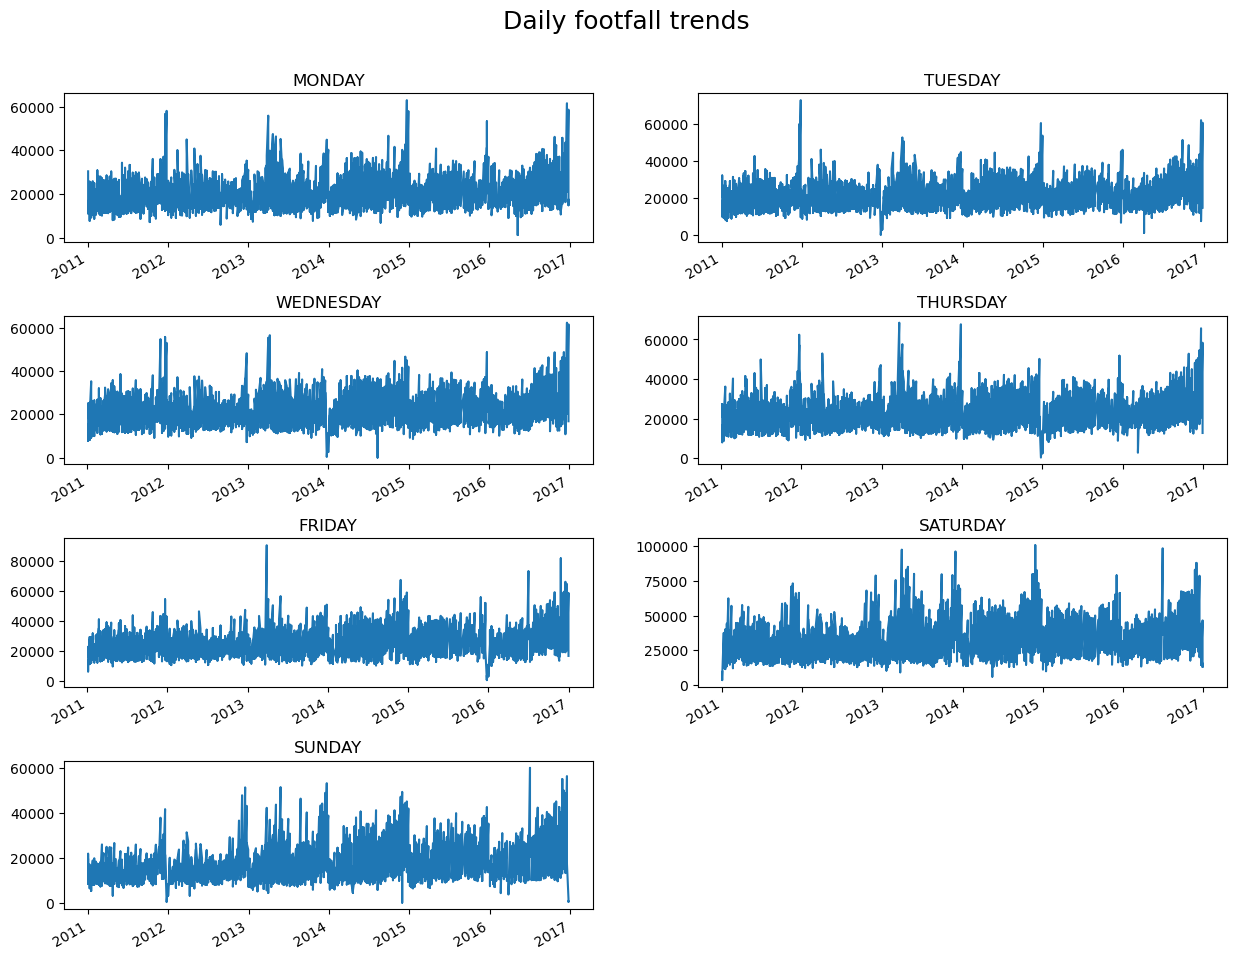

In [ ]:
day_week=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Daily footfall trends", fontsize=18, y=0.95)

# loop through the length of gates and keep track of index
for n, dw in enumerate(day_week):
    # add a new subplot iteratively
    ax = plt.subplot(4, 2, n + 1)

    # filter df and plot footfall on the new subplot axis
    df_final_viz[df_final_viz["Weekday"] == dw].plot(x='Date',y='InCountTotal',ax=ax)

    # chart formatting
    ax.set_title(dw.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")

### Feature Engineering

In [ ]:
df_mall_day['HolidayName']=df_mall_day['HolidayName'].fillna('No Holiday')

In [ ]:
# Create dummy columns for categories in Holiday names
# dummies = pd.get_dummies(df_mall_day_binned['HolidayName'])
# df_mall_day_binned2=pd.concat([df_mall_day_binned,dummies],axis=1)
# df_mall_day_binned2.drop('HolidayName',axis=1, inplace=True)

In [ ]:
df_mall_day.head(2)

Date  InCountTotal  Month  Year  Day   Weekday Holidays  \
0 2011-01-01         47767      1  2011    1  Saturday        Y   
1 2011-01-02        115685      1  2011    2    Sunday        N   

      HolidayName  mean_temp  rain  wind_speed  abnormal_rain  high_temp  \
0  School Holiday        0.0   0.0         0.0              0          0   
1      No Holiday        7.4   0.0         0.5              0          0   

   low_temp  high_wind  
0         1          0  
1         0          0

### Encoding

In [ ]:
#Label encoding of categorical columns
df_mall_day =labelEncoder(df_mall_day, ['Year','Weekday','Holidays','HolidayName'])

In [ ]:
df_mall_day.head(2)

Date  InCountTotal  Month  Year  Day  Weekday  Holidays  HolidayName  \
0 2011-01-01         47767      1     0    1        2         1            3   
1 2011-01-02        115685      1     0    2        3         0            2   

   mean_temp  rain  wind_speed  abnormal_rain  high_temp  low_temp  high_wind  
0        0.0   0.0         0.0              0          0         1          0  
1        7.4   0.0         0.5              0          0         0          0

### Scaling

In [ ]:
#scaling numerical columns except target column "IncountTotal"
ScaledData=minMaxScaler(df_mall_day,['mean_temp', 'rain', 'wind_speed'])

In [ ]:
ScaledData.head(5)

Date  InCountTotal  Month  Year  Day  Weekday  Holidays  HolidayName  \
0 2011-01-01         47767      1     0    1        2         1            3   
1 2011-01-02        115685      1     0    2        3         0            2   
2 2011-01-03        160658      1     0    3        1         0            2   
3 2011-01-04        165334      1     0    4        5         1            3   
4 2011-01-05        135127      1     0    5        6         1            4   

   mean_temp  rain  wind_speed  abnormal_rain  high_temp  low_temp  high_wind  
0   0.094203   0.0    0.000000              0          0         1          0  
1   0.362319   0.0    0.066667              0          0         0          0  
2   0.278986   0.0    0.173333              0          0         1          0  
3   0.605072   0.0    0.520000              0          0         0          1  
4   0.521739   0.0    0.400000              0          0         0          1

### Time Series analysis

Stationarity refers to the property of a time series where the statistical properties of the series remain constant over time.It is important to check for stationarity when analyzing a time series as stationarity is a fundamental assumption in many time series models.If the data is not stationary, the model assumptions may not hold, and the resulting model may not provide an accurate representation of the data.

A time series is considered stationary when the statistical properties of the series, such as the mean, variance, and autocorrelation, remain constant over time.

Formally, a time series is said to be stationary if it satisfies the following conditions:

Constant mean: The mean of the series remains constant over time. This means that the average value of the series does not increase or decrease over time.

Constant variance: The variance of the series remains constant over time. This means that the spread of the data around the mean does not change over time.

Constant autocorrelation: The correlation between observations at different time lags remains constant over time. This means that the relationship between past and future values of the series does not change over time.

**Rolling mean and rolling standard deviation to check stationarity of data**:
By plotting the rolling mean and rolling standard deviation of a time series and observing their behavior over time, one can determine whether the time series is stationary or not. If the rolling mean and standard deviation are constant over time, it suggests that the time series is stationary, and statistical tests can be used to confirm stationarity. If the rolling mean and standard deviation are not constant, it suggests that the time series is non-stationary, and additional analysis, such as differencing or modeling, may be necessary to make the time series stationary.

**Additive and Multiplicative time series decomposition**:
Additive and multiplicative time series decomposition are two common methods for decomposing a time series into its underlying components.

Additive decomposition assumes that the time series can be represented as the sum of its components, which include the trend, seasonality, and residuals. Mathematically, an additive time series can be represented as:

Y(t) = Trend(t) + Seasonality(t) + Residual(t)

where Y(t) is the time series value at time t, Trend(t) represents the underlying trend component, Seasonality(t) represents the seasonal variation component, and Residual(t) represents the random noise or error component.

Multiplicative decomposition, on the other hand, assumes that the time series can be represented as the product of its components, which include the trend, seasonality, and residuals. Mathematically, a multiplicative time series can be represented as:

Y(t) = Trend(t) * Seasonality(t) * Residual(t)

where * represents multiplication.

The choice of additive or multiplicative decomposition depends on the nature of the time series. An additive decomposition is typically used when the magnitude of the seasonal fluctuations in the time series is constant over time, whereas a multiplicative decomposition is used when the magnitude of the seasonal fluctuations is proportional to the level of the time series.

Once the time series has been decomposed into its underlying components, it can be easier to analyze and model each component separately. For example, the trend component can be modeled using regression techniques, the seasonal component can be modeled using seasonal regression or time series models, and the residuals can be analyzed for any remaining patterns or anomalies. Overall, time series decomposition is a useful technique for understanding the underlying structure of a time series and can help in making predictions and forecasts.

In [ ]:
## Time series analysis on data grouped by year month

In [ ]:
df_year_footfall = df_mall_day.groupby(['Year','Month'])['InCountTotal'].sum().reset_index()
df_year_footfall['yr_month'] = df_year_footfall['Year'].map(str) + '_' + df_year_footfall['Month'].map(str)

In [ ]:
df_year_footfall.head(5)

Year  Month  InCountTotal yr_month
0     0      1       4771544      0_1
1     0      2       4652047      0_2
2     0      3       5245117      0_3
3     0      4       5285813      0_4
4     0      5       4905932      0_5

In [ ]:
df_year_footfall = df_year_footfall.sort_values('yr_month',ascending=True).reset_index(drop=True)

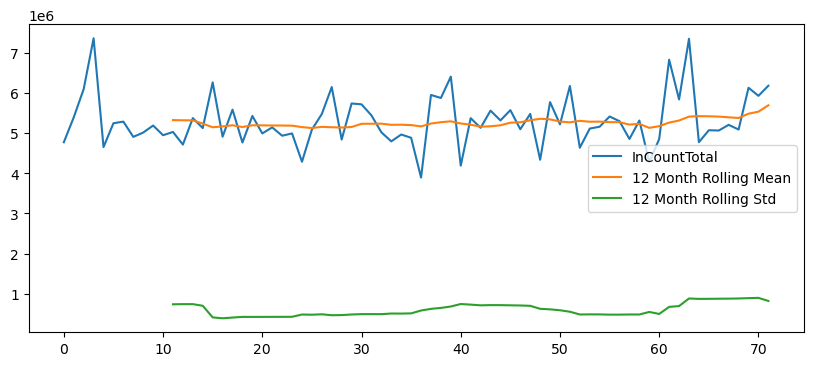

In [ ]:
meanstdplot(df_year_footfall['InCountTotal'])

The rolling mean and standard deviation is pretty constant over time. Thus a visual inspection concludes that the data is stationary.

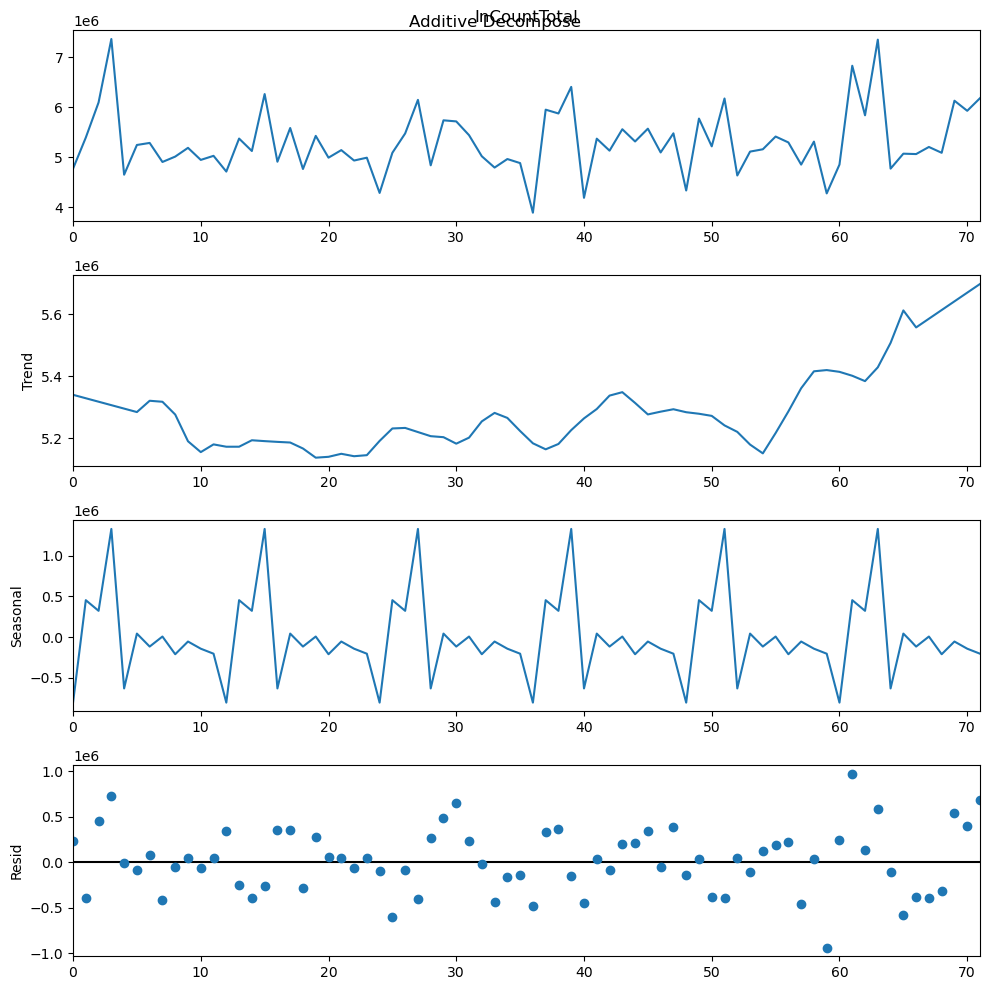

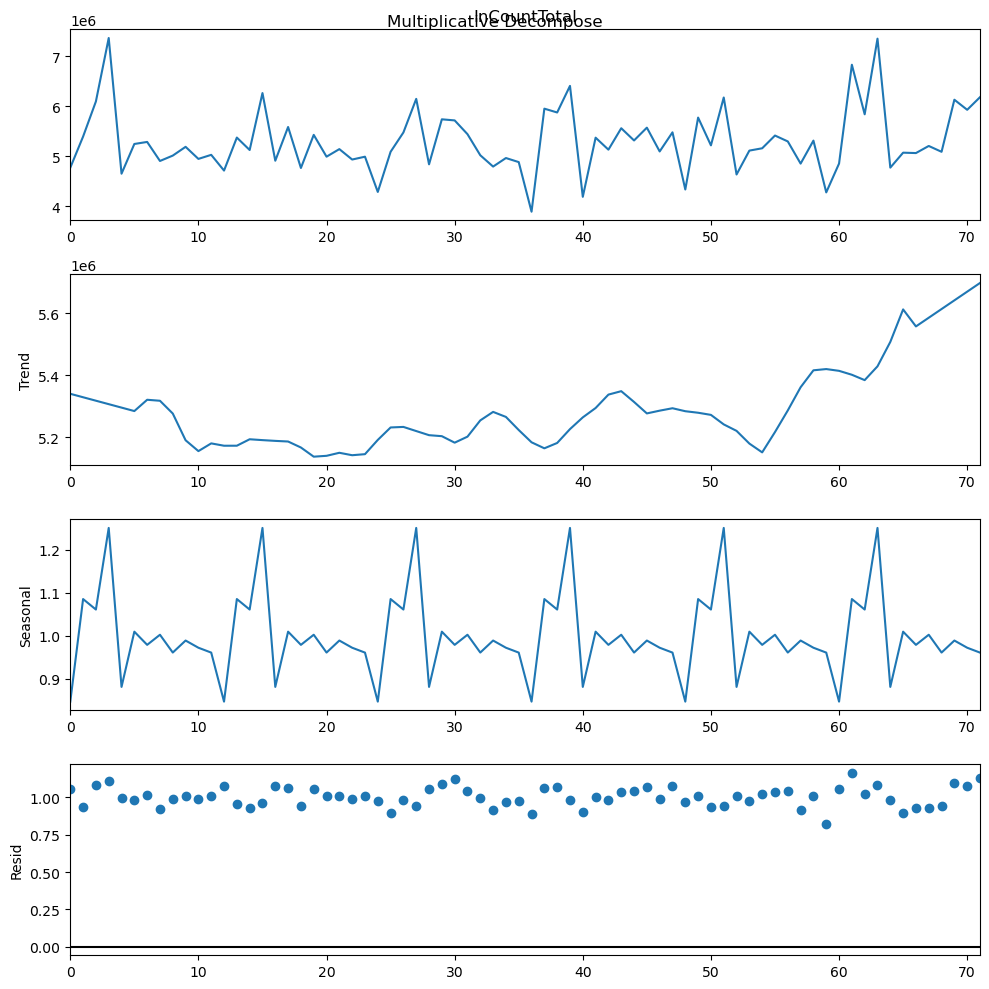

In [ ]:
tsMultiplicative, tsAdditive = decomposeTS(df_year_footfall['InCountTotal'],freq=12)

We can clearly see from the graph that the trend and seasonality from the series have some pattern and hence it looks that the data is not stationary.

In [ ]:
adf_test(df_year_footfall['InCountTotal'])

Augmented Dickey-Fuller Test:
ADF test statistic      -0.116286
p-value                  0.947792
# lags used             11.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
Data has a unit root and is non-stationary


Since the p-value is greater than the significance level ( 0.05 ), the null hypothesis cannot be rejected, indicating that the time series is non-stationary.

In [ ]:
kpss_test(df_year_footfall['InCountTotal'])

Kwiatkowski-Phillips-Schmidt-Shin Test:

KPSS Statistic: 0.154818
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
KPSS test statistic                                               0.154818
p-value                                                                0.1
# lags used                                                              2
# observations           {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
critical value (10%)                                                 0.347
critical value (5%)                                                  0.463
critical value (2.5%)                                                0.574
critical value (1%)                                                  0.739
Data has a unit root and is non-stationary


/Users/bharathchelimela/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Since the p-value is greater than the significance level ( 0.05 ), the null hypothesis cannot be rejected, indicating that the time series is non-stationary.

In [ ]:
pm.arima.nsdiffs(df_year_footfall['InCountTotal'], 12)

0

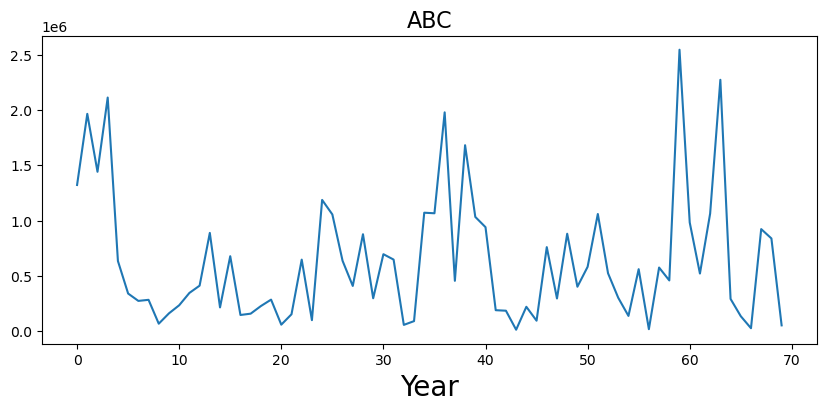

In [ ]:
diffDF = abs(df_year_footfall['InCountTotal'].diff(2))
diffDF = diffDF.dropna(how='any',axis=0)
diffDF.reset_index(drop=True, inplace=True)
plt.figure(figsize=(10, 4))
plt.plot(diffDF)
plt.title('ABC', fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.show()

In [ ]:
adf_test(diffDF)

Augmented Dickey-Fuller Test:
ADF test statistic      -4.340646
p-value                  0.000377
# lags used              5.000000
# observations          64.000000
critical value (1%)     -3.536928
critical value (5%)     -2.907887
critical value (10%)    -2.591493
Data has no unit root and is stationary


In [ ]:
##Time series analysis on df_mall_day

In [ ]:
d2=df_mall_day.copy()
d2 = d2.sort_values('Date',ascending=True).reset_index(drop=True)
d2=d2.set_index('Date')

In [ ]:
d2.head()

InCountTotal  Month  Year  Day  Weekday  Holidays  HolidayName  \
Date                                                                         
2011-01-01         47767      1     0    1        2         1            3   
2011-01-02        115685      1     0    2        3         0            2   
2011-01-03        160658      1     0    3        1         0            2   
2011-01-04        165334      1     0    4        5         1            3   
2011-01-05        135127      1     0    5        6         1            4   

            mean_temp  rain  wind_speed  abnormal_rain  high_temp  low_temp  \
Date                                                                          
2011-01-01        0.0   0.0         0.0              0          0         1   
2011-01-02        7.4   0.0         0.5              0          0         0   
2011-01-03        5.1   0.0         1.3              0          0         1   
2011-01-04       14.1   0.0         3.9              0          0         0   
2011-01-05       11.8   0.0         3.0              0          0         0   

            high_wind  
Date                   
2011-01-01          0  
2011-01-02          0  
2011-01-03          0  
2011-01-04          1  
2011-01-05          1

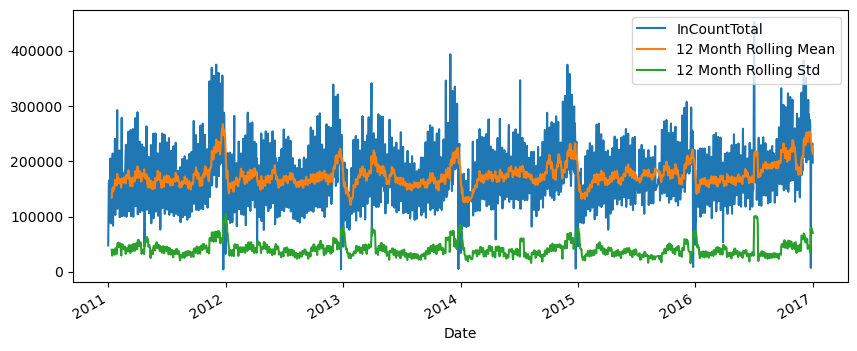

In [ ]:
meanstdplot(d2['InCountTotal'])

As we see, the mean (average) of InCountTotal is almost constant without any increasing/ decreasing trend.

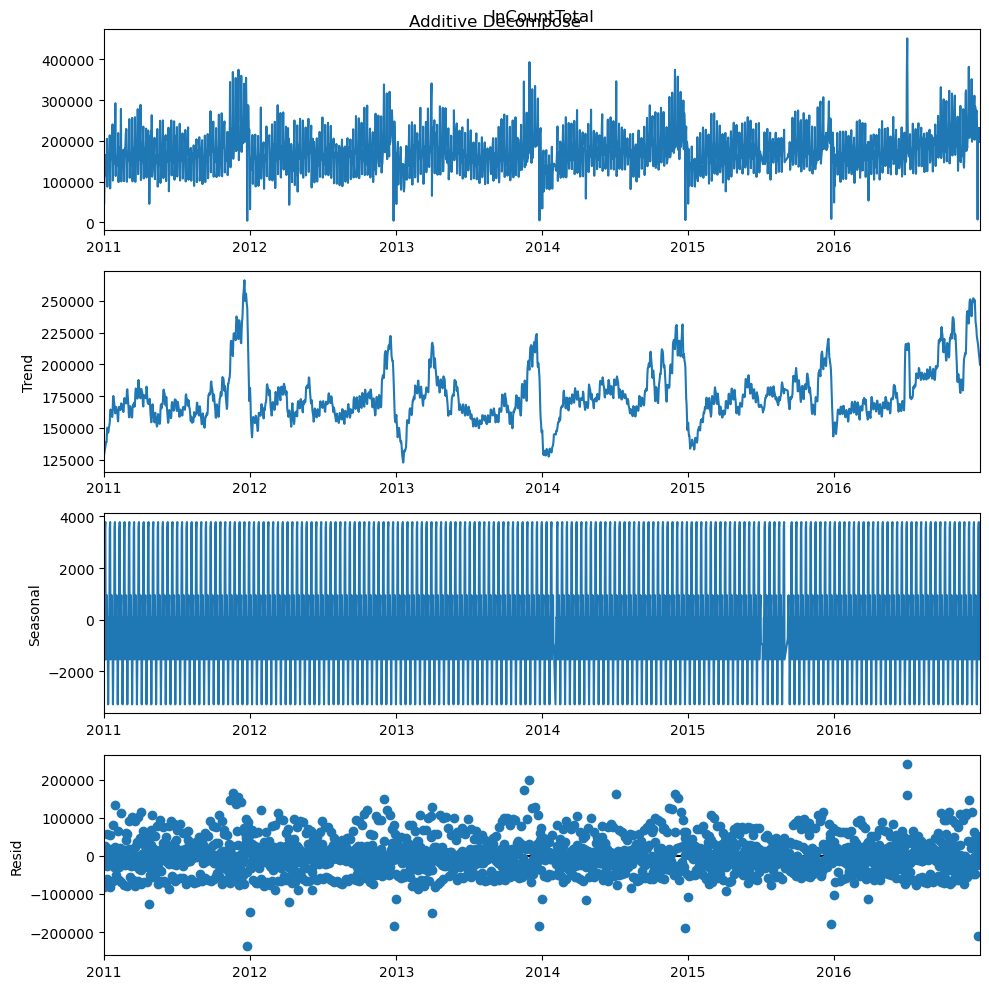

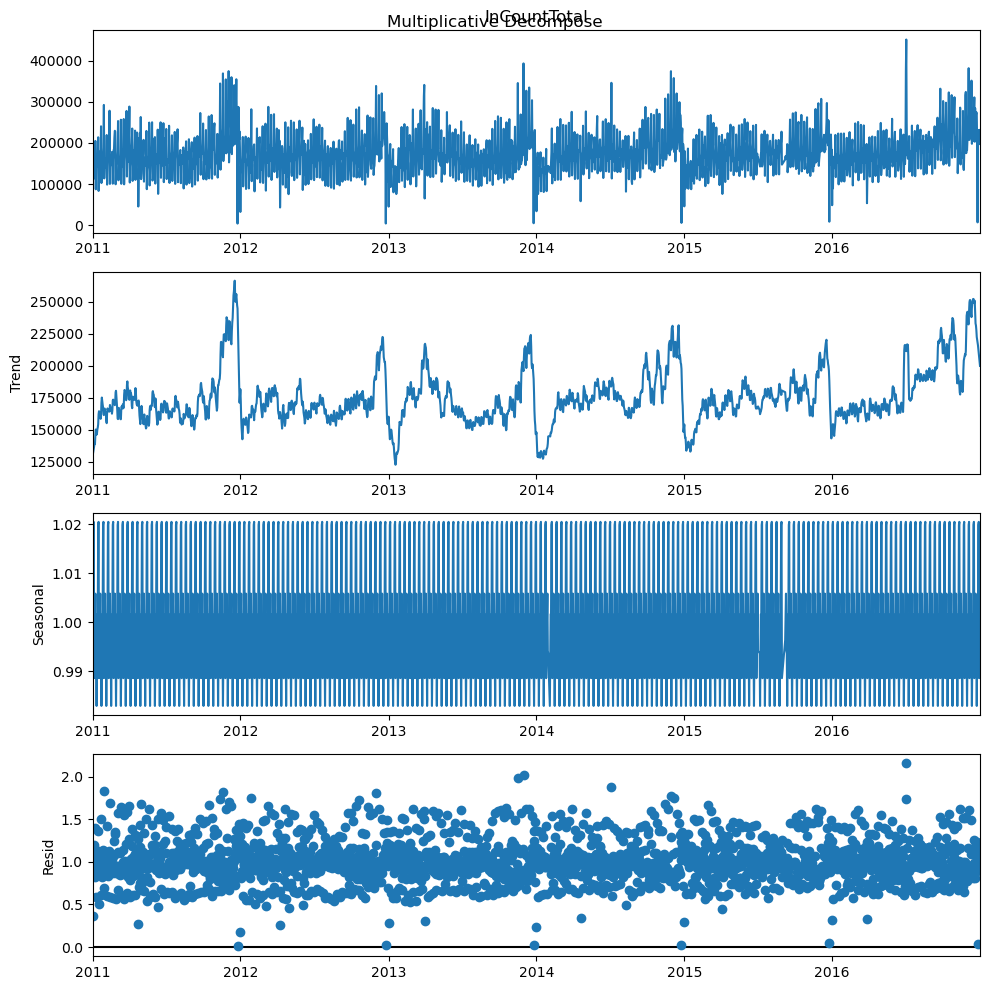

In [ ]:
tsMultiplicative, tsAdditive = decomposeTS(d2['InCountTotal'],freq=12)

### ADF and KPSS tests to check stationarity of time series data

Stationarity of time series data can be checked using below two tests

Augmented Dickey-Fuller (ADF) test: The ADF test is a statistical test that tests for stationarity in a time series. The null hypothesis of the test is that the time series is non-stationary, and the alternative hypothesis is that the time series is stationary. If the p-value of the test is less than the significance level (usually 0.05), then we reject the null hypothesis and conclude that the time series is stationary.

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test: The KPSS test is another statistical test that tests for stationarity in a time series. The null hypothesis of the test is that the time series is stationary, and the alternative hypothesis is that the time series is non-stationary. If the p-value of the test is greater than the significance level, then we reject the alternative hypothesis and conclude that the time series is stationary.

In [ ]:
adf_test(df_mall_day['InCountTotal'])

Augmented Dickey-Fuller Test:
ADF test statistic     -6.137666e+00
p-value                 8.113010e-08
# lags used             2.100000e+01
# observations          2.157000e+03
critical value (1%)    -3.433385e+00
critical value (5%)    -2.862881e+00
critical value (10%)   -2.567484e+00
Data has no unit root and is stationary


In [ ]:
kpss_test(df_mall_day['InCountTotal'])

Kwiatkowski-Phillips-Schmidt-Shin Test:

KPSS Statistic: 1.057823
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
KPSS test statistic                                               1.057823
p-value                                                               0.01
# lags used                                                             16
# observations           {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
critical value (10%)                                                 0.347
critical value (5%)                                                  0.463
critical value (2.5%)                                                0.574
critical value (1%)                                                  0.739
Data has no unit root and is stationary


/Users/bharathchelimela/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:
##Time series analysis on dataDayLong

In [ ]:
d3=dataDayLong.copy()
d3 = d3.sort_values('Date',ascending=True).reset_index(drop=True)
d3=d3.set_index('Date')

In [ ]:
d3.head()

LocationName  high_wind  abnormal_rain  high_temp  low_temp  mean_temp  \
Date                                                                     
2011-01-01          0.0            0.0        0.0       1.0        0.0   
2011-01-04          1.0            0.0        0.0       0.0       14.1   
2011-01-05          1.0            0.0        0.0       0.0       11.8   
2011-01-06          0.0            0.0        0.0       0.0       14.9   
2011-01-07          0.0            0.0        0.0       0.0       14.6   

LocationName  wind_speed  rain Holidays     HolidayName  AlbionStNorth  \
Date                                                                     
2011-01-01           0.0   0.0        Y  School Holiday           5231   
2011-01-04           3.9   0.0        Y  School Holiday          23219   
2011-01-05           3.0   0.0        Y     Uni Holiday          17875   
2011-01-06           2.6   0.0        Y  School Holiday          19191   
2011-01-07           1.6   0.0        Y     Uni Holiday          16182   

LocationName  AlbionStSouth  Briggate  BriggateAtMcDs  CommercialStBarratts  \
Date                                                                          
2011-01-01             5714      9467            7102                  4905   
2011-01-04            28132     18480           13543                 18224   
2011-01-05            24001     15260           11583                 14650   
2011-01-06            26414     16508           14334                 15296   
2011-01-07            19743     13705            8514                 11002   

LocationName  CommercialStLush  DortmundSq  Headrow  Month  Year  Day  \
Date                                                                    
2011-01-01                5725        6052     3571      1  2011    1   
2011-01-04               32171       21466    10099      1  2011    4   
2011-01-05               25012       19050     7696      1  2011    5   
2011-01-06               27400       20987     8123      1  2011    6   
2011-01-07               22606       15807     6187      1  2011    7   

LocationName    Weekday  
Date                     
2011-01-01     Saturday  
2011-01-04      Tuesday  
2011-01-05    Wednesday  
2011-01-06     Thursday  
2011-01-07       Friday

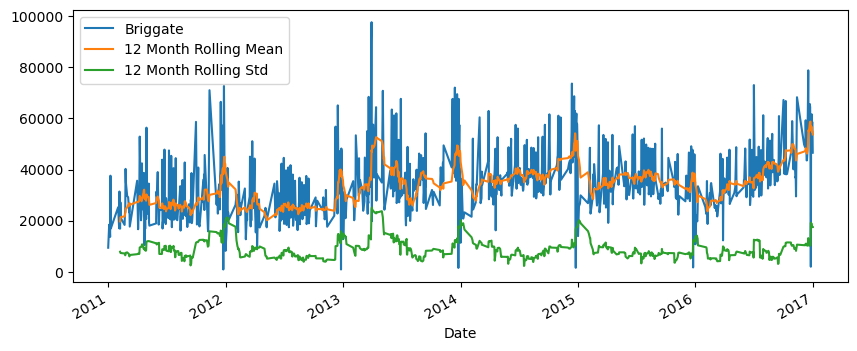

In [ ]:
meanstdplot(d3['Briggate'])

In [ ]:
adf_test(d3['Briggate'])

Augmented Dickey-Fuller Test:
ADF test statistic        -2.552472
p-value                    0.103223
# lags used               20.000000
# observations          1033.000000
critical value (1%)       -3.436696
critical value (5%)       -2.864342
critical value (10%)      -2.568262
Data has a unit root and is non-stationary


In [ ]:
kpss_test(d3['Briggate'])

Kwiatkowski-Phillips-Schmidt-Shin Test:

KPSS Statistic: 2.562362
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
KPSS test statistic                                               2.562362
p-value                                                               0.01
# lags used                                                             17
# observations           {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
critical value (10%)                                                 0.347
critical value (5%)                                                  0.463
critical value (2.5%)                                                0.574
critical value (1%)                                                  0.739
Data has no unit root and is stationary


/Users/bharathchelimela/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### lag variables

Lag variables are created in time series regression problems to capture the effect of past values of the dependent variable on the current value of the dependent variable.Including lag variables in the regression model allows us to capture the effect of past values of the dependent variable on the current value, and can help improve the accuracy of our predictions. Additionally, by including lag variables, we can test for the significance of past values of the dependent variable and identify the time lags that are most relevant in predicting the current value.

In [ ]:
def create_lag_variable(data,feature,n):
     for i in range(n):
        data[feature+str(i+1)] = data[feature].shift((i+1))

In [ ]:
#Since the series has sort of weekly trend we are using n=7
create_lag_variable(ScaledData,'InCountTotal',7)
lagMallDay=ScaledData.copy()

In [ ]:
lagMallDay.head()

Date  InCountTotal  Month  Year  Day  Weekday  Holidays  HolidayName  \
0 2011-01-01         47767      1     0    1        2         1            3   
1 2011-01-02        115685      1     0    2        3         0            2   
2 2011-01-03        160658      1     0    3        1         0            2   
3 2011-01-04        165334      1     0    4        5         1            3   
4 2011-01-05        135127      1     0    5        6         1            4   

   mean_temp  rain  wind_speed  abnormal_rain  high_temp  low_temp  high_wind  \
0   0.094203   0.0    0.000000              0          0         1          0   
1   0.362319   0.0    0.066667              0          0         0          0   
2   0.278986   0.0    0.173333              0          0         1          0   
3   0.605072   0.0    0.520000              0          0         0          1   
4   0.521739   0.0    0.400000              0          0         0          1   

   InCountTotal1  InCountTotal2  InCountTotal3  InCountTotal4  InCountTotal5  \
0            NaN            NaN            NaN            NaN            NaN   
1        47767.0            NaN            NaN            NaN            NaN   
2       115685.0        47767.0            NaN            NaN            NaN   
3       160658.0       115685.0        47767.0            NaN            NaN   
4       165334.0       160658.0       115685.0        47767.0            NaN   

   InCountTotal6  InCountTotal7  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN

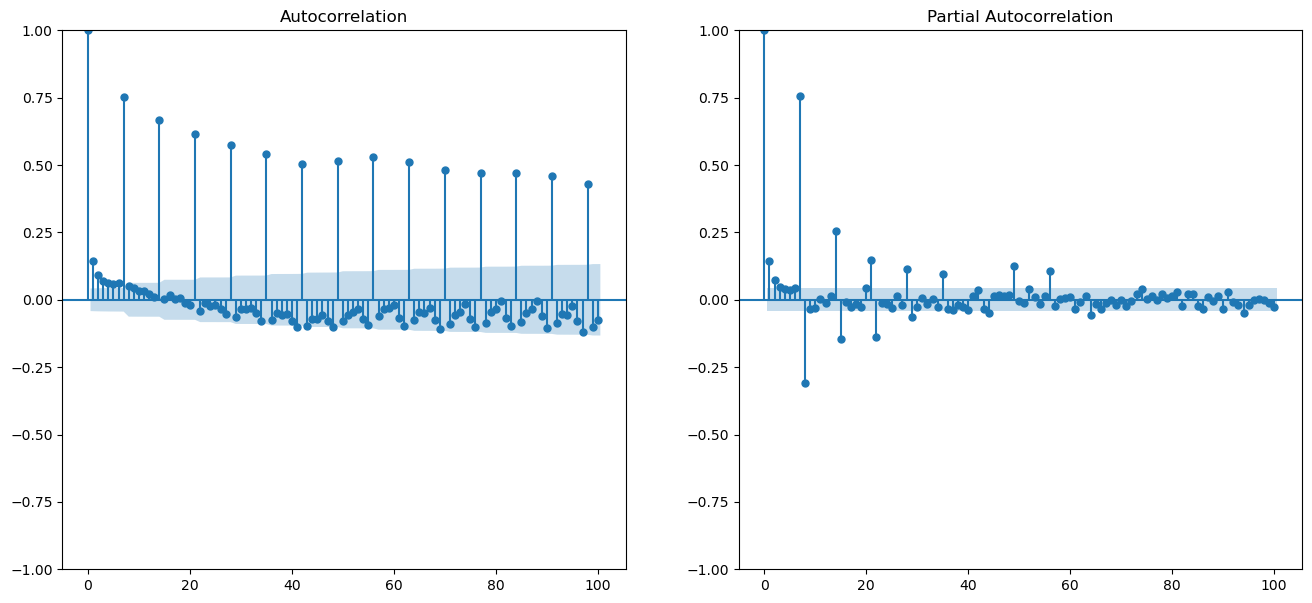

In [ ]:
checkAcfPacf(lagMallDay['InCountTotal'],100)

There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.Geometric decay in ACF plot

# Modelling

In [ ]:
lagMallDay.fillna(0,inplace=True)
d1_model=lagMallDay.copy()
d1_model.head(2)
#d1_model.fillna(0,inplace=True)

Date  InCountTotal  Month  Year  Day  Weekday  Holidays  HolidayName  \
0 2011-01-01         47767      1     0    1        2         1            3   
1 2011-01-02        115685      1     0    2        3         0            2   

   mean_temp  rain  wind_speed  abnormal_rain  high_temp  low_temp  high_wind  \
0   0.094203   0.0    0.000000              0          0         1          0   
1   0.362319   0.0    0.066667              0          0         0          0   

   InCountTotal1  InCountTotal2  InCountTotal3  InCountTotal4  InCountTotal5  \
0            0.0            0.0            0.0            0.0            0.0   
1        47767.0            0.0            0.0            0.0            0.0   

   InCountTotal6  InCountTotal7  
0            0.0            0.0  
1            0.0            0.0

In [ ]:
d1_model.columns

Index(['Date', 'InCountTotal', 'Month', 'Year', 'Day', 'Weekday', 'Holidays',
       'HolidayName', 'mean_temp', 'rain', 'wind_speed', 'abnormal_rain',
       'high_temp', 'low_temp', 'high_wind', 'InCountTotal1', 'InCountTotal2',
       'InCountTotal3', 'InCountTotal4', 'InCountTotal5', 'InCountTotal6',
       'InCountTotal7'],
      dtype='object')

In [ ]:
#SCaling the dataset used for modelling
d1_modelScaled=minMaxScaler(d1_model, ['InCountTotal1', 'InCountTotal2', 'InCountTotal3', 'InCountTotal4','InCountTotal5', 'InCountTotal6', 'InCountTotal7'])
#d2_modelScaled=minMaxScaler(d2_model, ['mean_temp', 'rain', 'wind_speed', 'InCountTotal1', 'InCountTotal2', 'InCountTotal3', 'InCountTotal4','InCountTotal5', 'InCountTotal6', 'InCountTotal7'])

In [ ]:
#d1modelScaled = pd.concat([d1_model.loc[:, ['InCountTotal']], d2_modelScaled], axis=1)
#d1modelScaled['Month'] = d1modelScaled['Month'].astype('str')
#d1modelScaled['Year'] = d1modelScaled['Year'].astype('str')
#d1modelScaled['Day'] = d1modelScaled['Day'].astype('str')
#d1modelScaled['Weekday'] = d1modelScaled['Weekday'].astype('str')

In [ ]:
#Splitting the dataset into train and test sets ( Train 95% data, test 5% data)
X_Train, X_Test, y_Train, y_Test=TrainTestSplit(d1_modelScaled.drop(['Date'],axis=1),'InCountTotal')

In [ ]:
X_Train.shape,X_Test.shape

((2070, 20), (109, 20))

Recursive Feature Engineering (RFE) is a feature selection method that selects the best subset of features by iteratively training a model and removing the least important features until a predetermined number of features is reached. It is a powerful feature selection method that can improve model accuracy, reduce model complexity, and automate the feature selection process.

LGBMRegressor(learning_rate=0.05, objective='regression')
Optimal number of features: 14


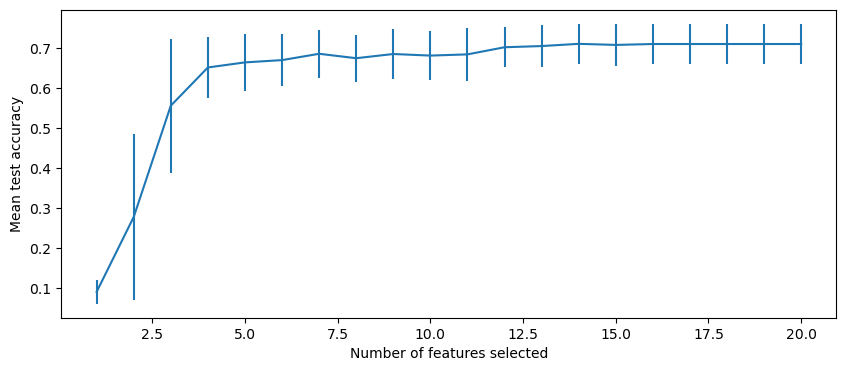

['Month', 'Year', 'Day', 'Weekday', 'mean_temp', 'rain', 'wind_speed', 'InCountTotal1', 'InCountTotal2', 'InCountTotal3', 'InCountTotal4', 'InCountTotal5', 'InCountTotal6', 'InCountTotal7']
      Actual      Predicted       MAPE      sMAPE                 bins
2070  186684  189435.465930   1.473863   1.463081  Less or Equal to 5%
2071  213014  195246.984205   8.340774   8.703754             5 to 10%
2072  202759  197996.006710   2.349091   2.377010  Less or Equal to 5%
2073  261357  246147.050947   5.819607   5.994021             5 to 10%
2074  158844  144861.521527   8.802648   9.207919             5 to 10%
2075  192078  176919.504306   7.891844   8.216042             5 to 10%
2076  212283  190496.232882  10.263077  10.818218            10 to 15%
2077  208018  205942.114690   0.997935   1.002940  Less or Equal to 5%
2078  226027  202365.209617  10.468568  11.046788            10 to 15%
2079  262396  218251.077111  16.823779  18.368955            15 to 20%
2080  331880  276231.277880  

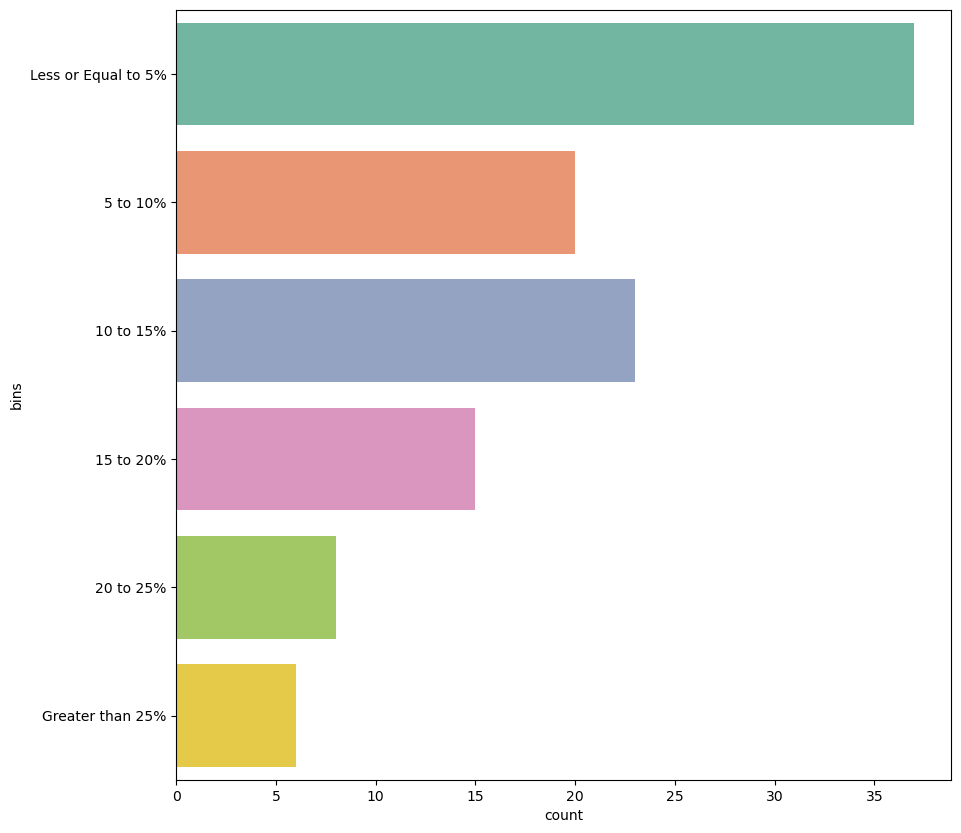

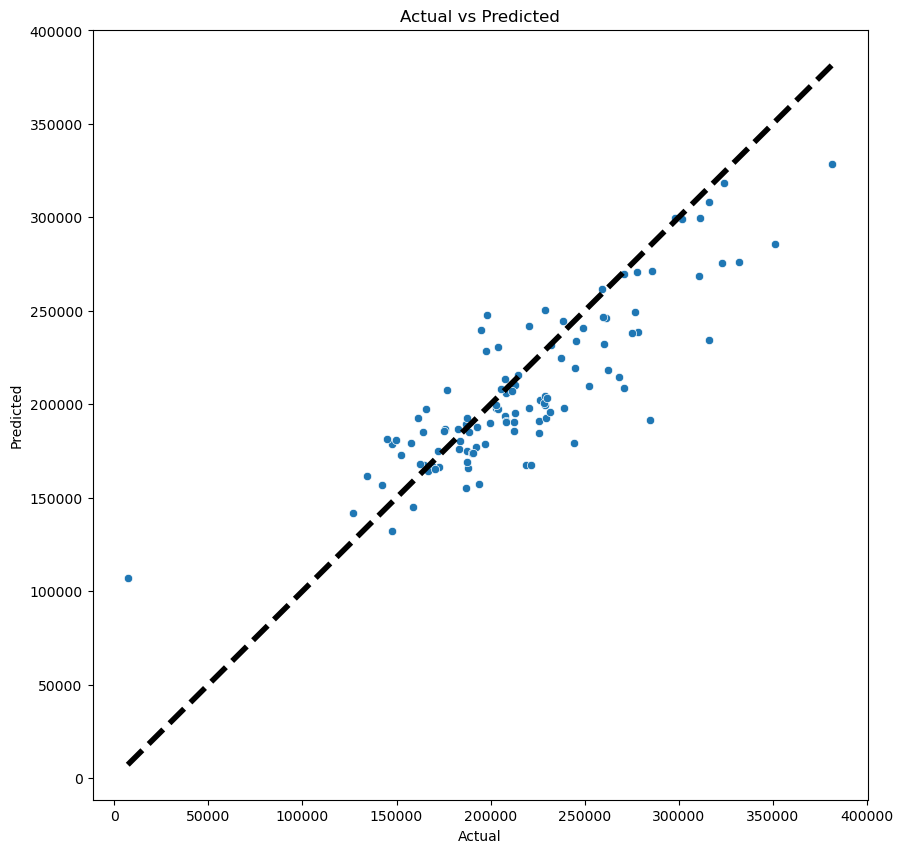

Results of sklearn.metrics:
R-Squared: 0.6867058149817951


In [ ]:
#Recursive Feature engineering model with Light GBM model
RFECVmodel('Light GBM')

LGBMRegressor(learning_rate=0.05, objective='regression')
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.003, max_depth=5, n_estimators=100, num_leaves=28; total time=   0.1s
[CV] END learning_rate=0.003, max_depth=5, n_estimators=100, num_leaves=28; total time=   0.1s
[CV] END learning_rate=0.003, max_depth=5, n_estimators=100, num_leaves=28; total time=   0.1s
[CV] END learning_rate=0.003, max_depth=5, n_estimators=500, num_leaves=28; total time=   0.3s
[CV] END learning_rate=0.003, max_depth=5, n_estimators=500, num_leaves=28; total time=   0.3s
[CV] END learning_rate=0.003, max_depth=5, n_estimators=500, num_leaves=28; total time=   1.2s
[CV] END learning_rate=0.03, max_depth=5, n_estimators=500, num_leaves=7; total time=   0.6s
[CV] END learning_rate=0.03, max_depth=5, n_estimators=500, num_leaves=7; total time=   0.6s
[CV] END learning_rate=0.03, max_depth=5, n_estimators=500, num_leaves=7; total time=   0.9s
[CV] END learning_rate=0.003, m

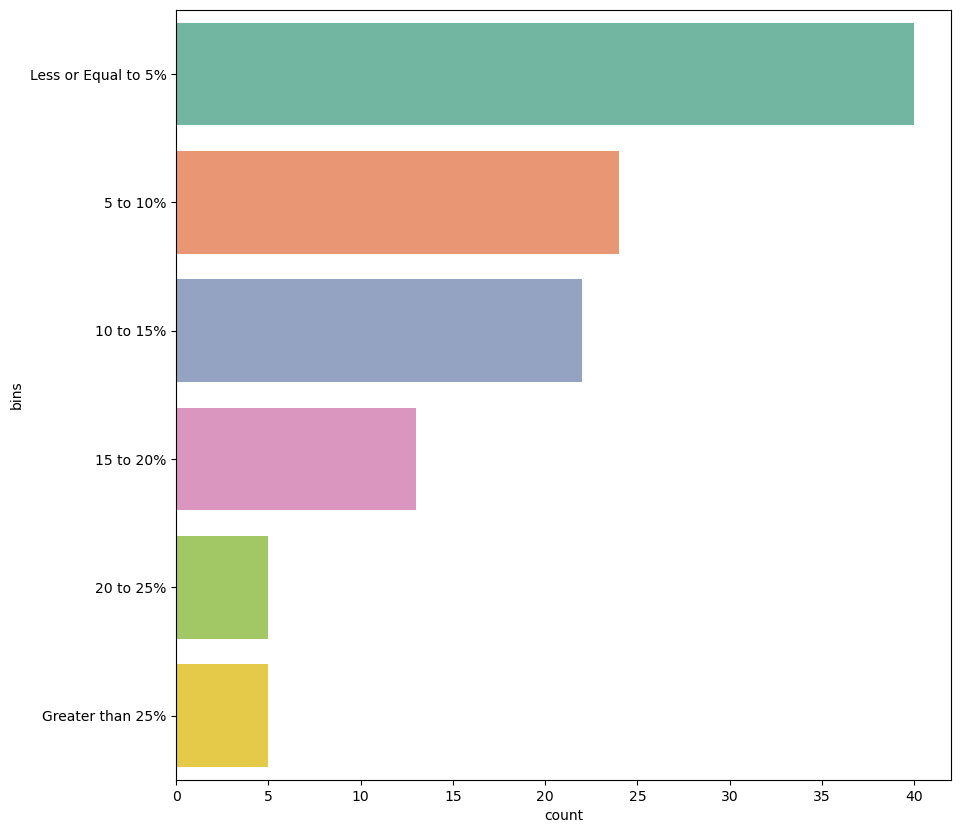

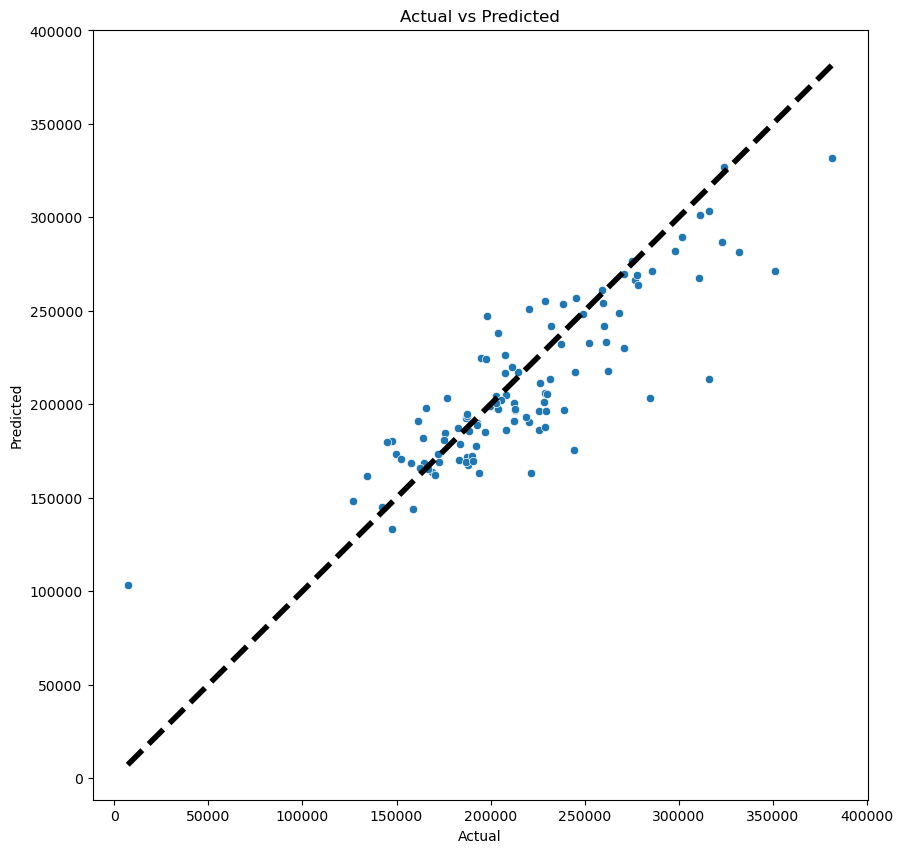

Results of sklearn.metrics:
R-Squared: 0.7242628951821442


In [ ]:
Hyperparameter('Light GBM',lgb_parameters)

GradientBoostingRegressor(random_state=30)
Optimal number of features: 14


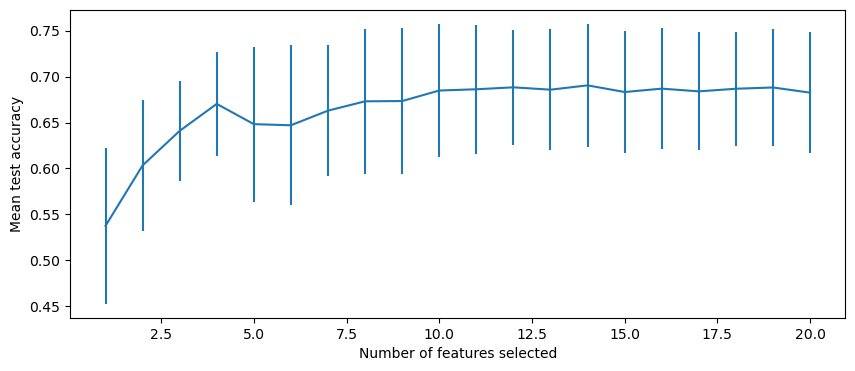

['Month', 'Year', 'Day', 'Weekday', 'HolidayName', 'mean_temp', 'rain', 'InCountTotal1', 'InCountTotal2', 'InCountTotal3', 'InCountTotal4', 'InCountTotal5', 'InCountTotal6', 'InCountTotal7']
      Actual      Predicted       MAPE      sMAPE                 bins
2070  186684  188568.445985   1.009431   1.004362  Less or Equal to 5%
2071  213014  190308.836710  10.659000  11.259052            10 to 15%
2072  202759  204096.156501   0.659481   0.657313  Less or Equal to 5%
2073  261357  251771.032990   3.667767   3.736287  Less or Equal to 5%
2074  158844  143405.326320   9.719394  10.215853             5 to 10%
2075  192078  174022.337071   9.400172   9.863778             5 to 10%
2076  212283  188380.602315  11.259685  11.931405            10 to 15%
2077  208018  190781.406433   8.286107   8.644242             5 to 10%
2078  226027  198822.950000  12.035752  12.806427            10 to 15%
2079  262396  211519.753125  19.389109  21.470587            15 to 20%
2080  331880  299638.639958 

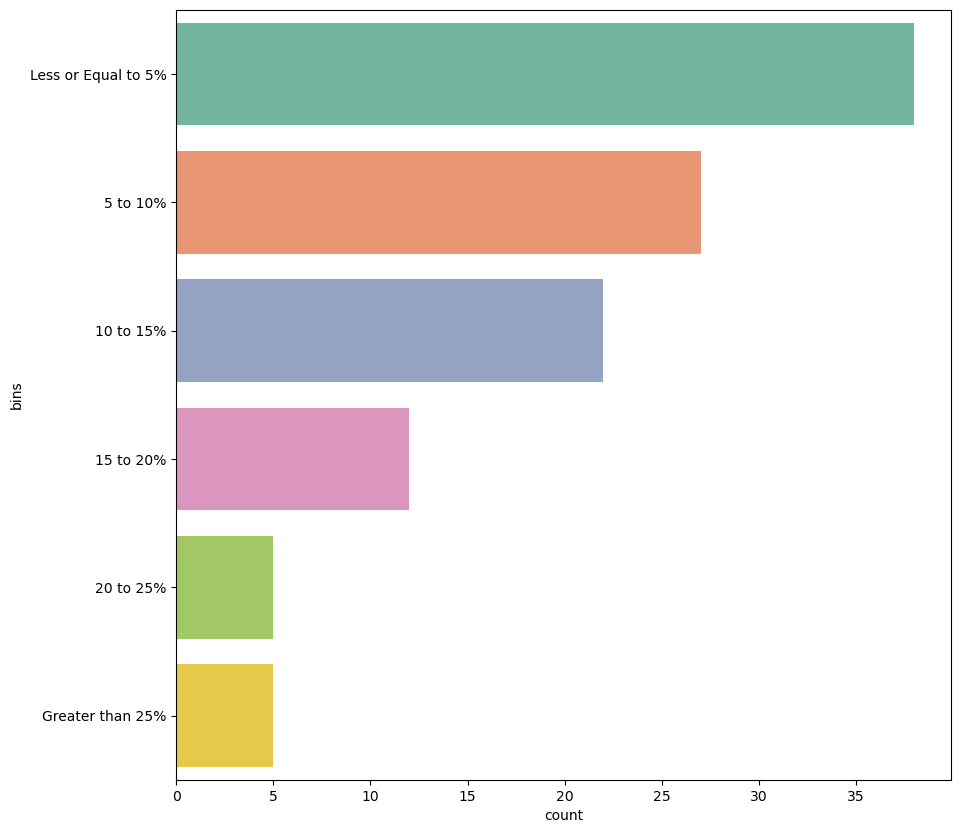

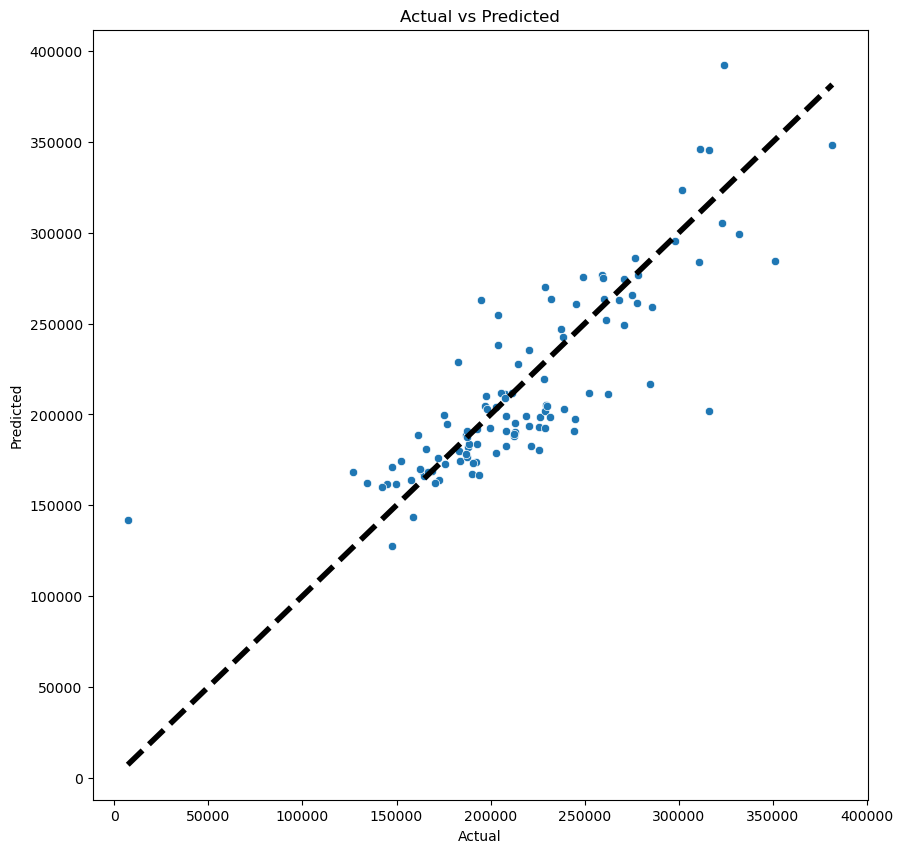

Results of sklearn.metrics:
R-Squared: 0.6826184990012754


In [ ]:
RFECVmodel('gbm')

GradientBoostingRegressor(random_state=30)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.15, max_depth=5, max_features=auto, min_samples_leaf=0.05, min_samples_split=0.01, subsample=1; total time=   0.5s
[CV] END learning_rate=0.15, max_depth=5, max_features=auto, min_samples_leaf=0.05, min_samples_split=0.01, subsample=1; total time=   0.5s
[CV] END learning_rate=0.15, max_depth=5, max_features=auto, min_samples_leaf=0.05, min_samples_split=0.01, subsample=1; total time=   0.5s
[CV] END learning_rate=0.15, max_depth=2, max_features=log2, min_samples_leaf=0.01, min_samples_split=0.005, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.15, max_depth=2, max_features=log2, min_samples_leaf=0.01, min_samples_split=0.005, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.15, max_depth=2, max_features=log2, min_samples_leaf=0.01, min_samples_split=0.005, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, max_

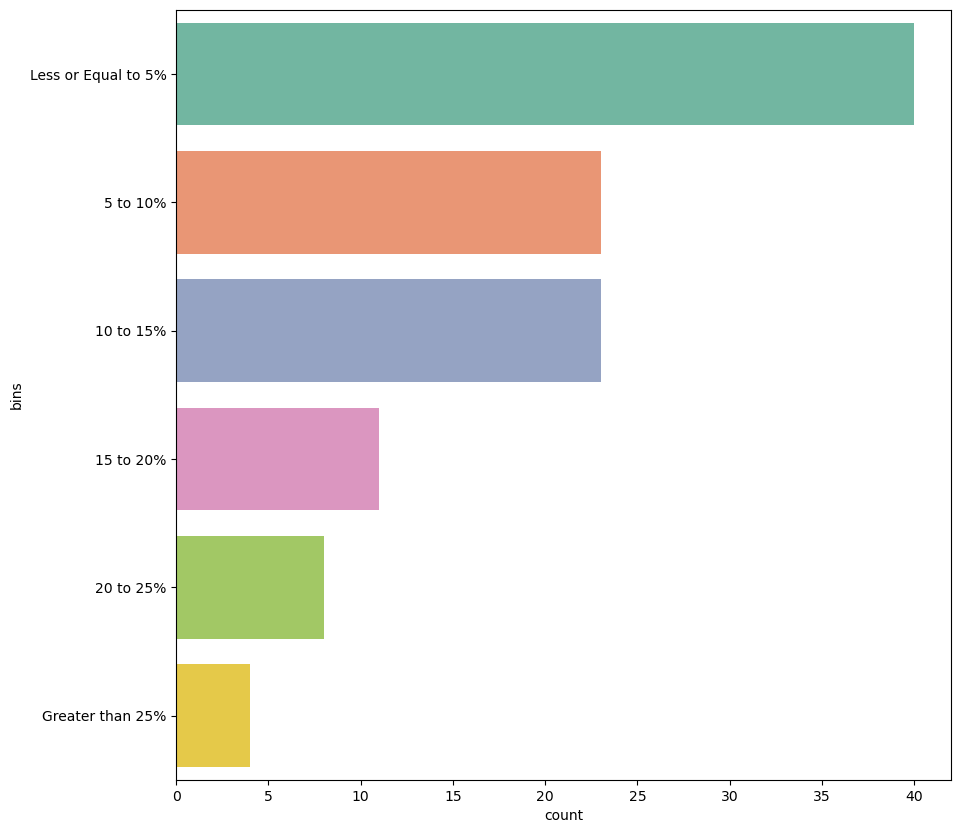

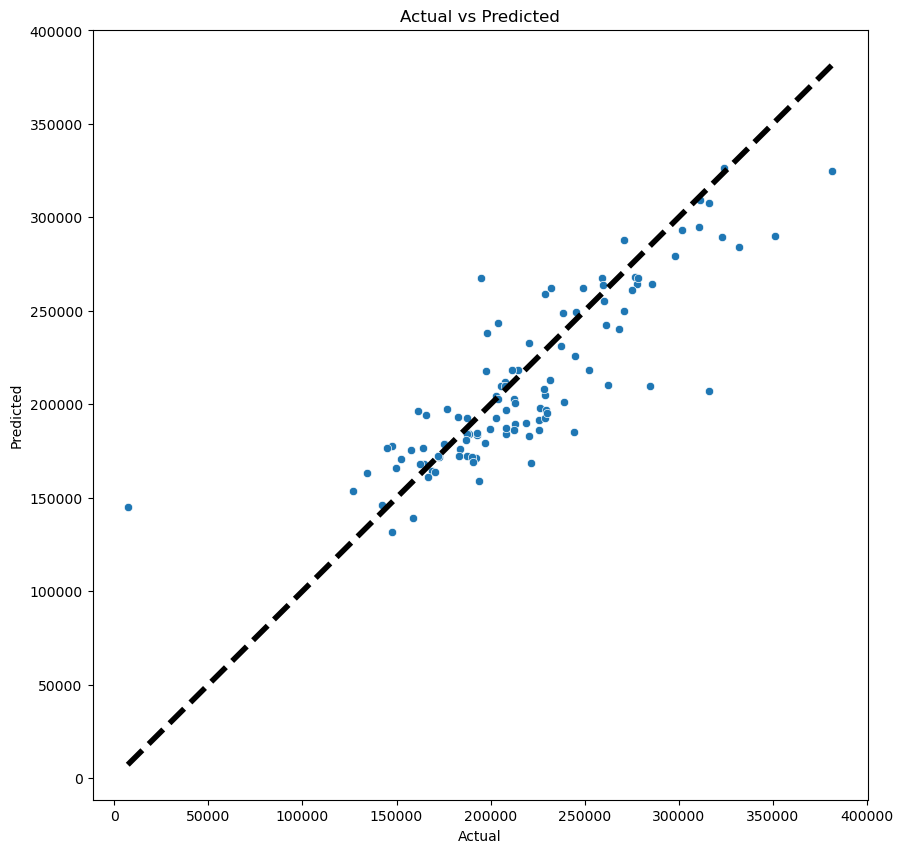

Results of sklearn.metrics:
R-Squared: 0.6940321449688827


In [ ]:
Hyperparameter('gbm',gb_parameters)

RandomForestRegressor(max_depth=5, max_features='auto', max_leaf_nodes=50,
                      min_samples_split=10, n_estimators=500, random_state=30)
Optimal number of features: 4


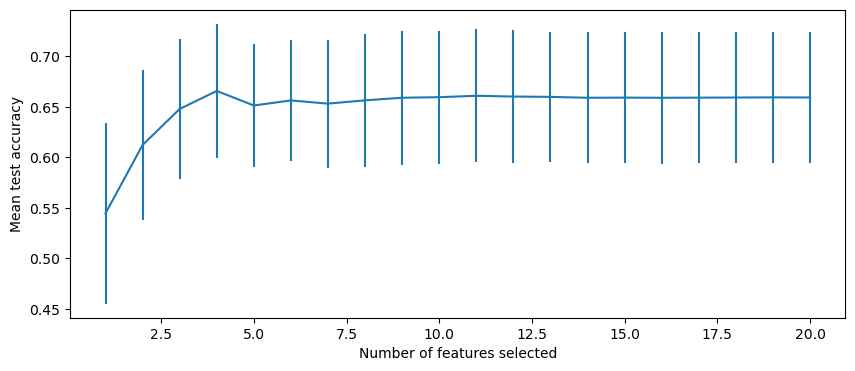

['Weekday', 'InCountTotal1', 'InCountTotal6', 'InCountTotal7']
      Actual      Predicted       MAPE      sMAPE                 bins
2070  186684  184021.757236   1.426069   1.436310  Less or Equal to 5%
2071  213014  183011.357388  14.084822  15.151880            10 to 15%
2072  202759  196049.054200   3.309321   3.365000  Less or Equal to 5%
2073  261357  246686.608452   5.613162   5.775249             5 to 10%
2074  158844  149005.594625   6.193753   6.391696             5 to 10%
2075  192078  167245.456209  12.928364  13.821833            10 to 15%
2076  212283  182833.617268  13.872700  14.906679            10 to 15%
2077  208018  182782.643323  12.131333  12.914696            10 to 15%
2078  226027  199545.802822  11.715944  12.444967            10 to 15%
2079  262396  200912.453067  23.431587  26.541086            20 to 25%
2080  331880  288306.615876  13.129259  14.051701            10 to 15%
2081  157883  157182.112229   0.443929   0.444916  Less or Equal to 5%
2082  175561  

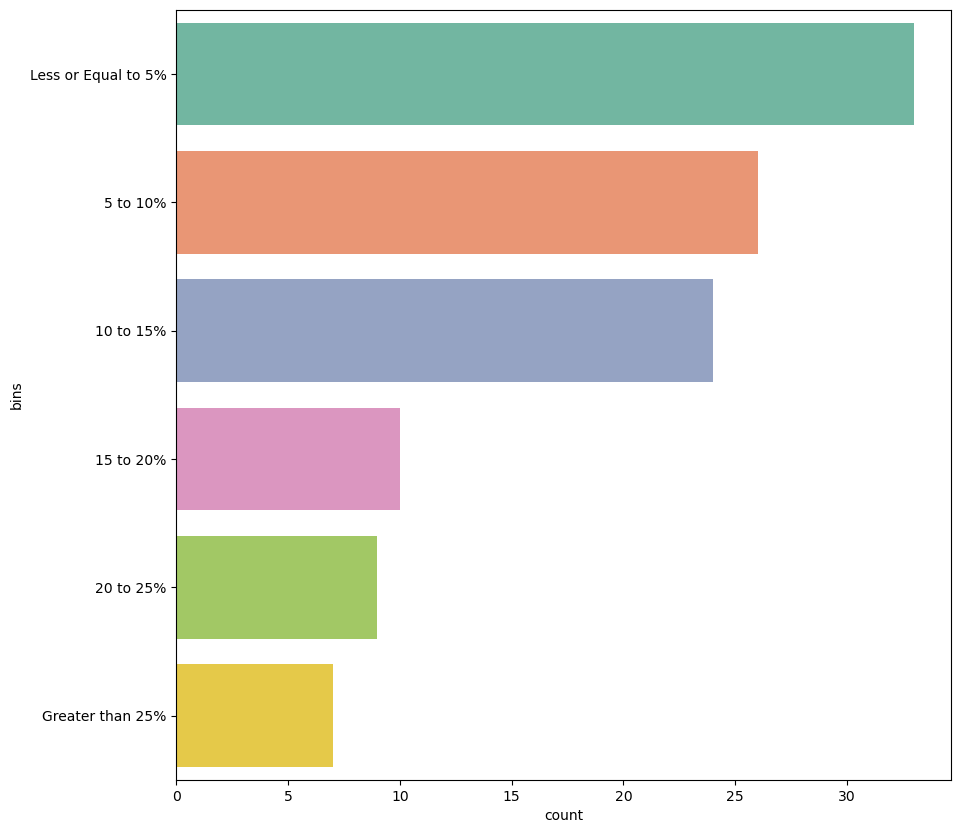

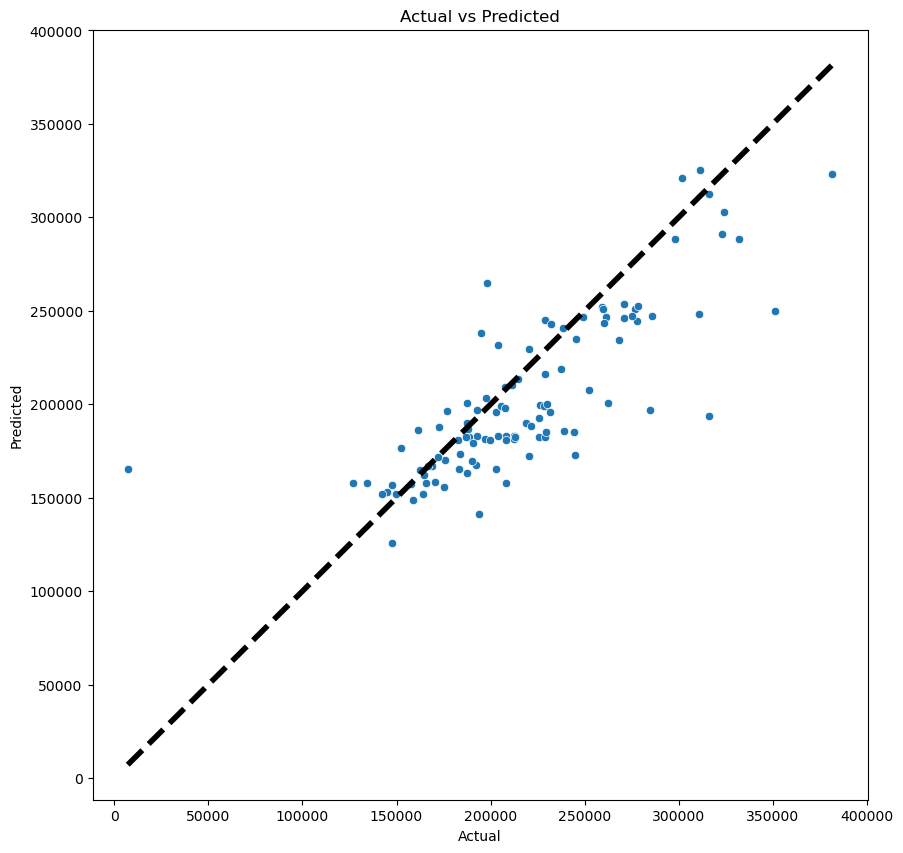

Results of sklearn.metrics:
R-Squared: 0.5742227184577511


In [ ]:
RFECVmodel('random forest')

RandomForestRegressor(max_depth=5, max_features='auto', max_leaf_nodes=50,
                      min_samples_split=10, n_estimators=500, random_state=30)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.05; total time=   0.9s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.05; total time=   0.9s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=0.05, min_samples_split=0.05; total time=   1.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=0.01, min_samples_split=0.05; total time=   1.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=0.01, min_samples_split=0.05; total time=   1.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=0.01, min_samples_split=0.05; total time=

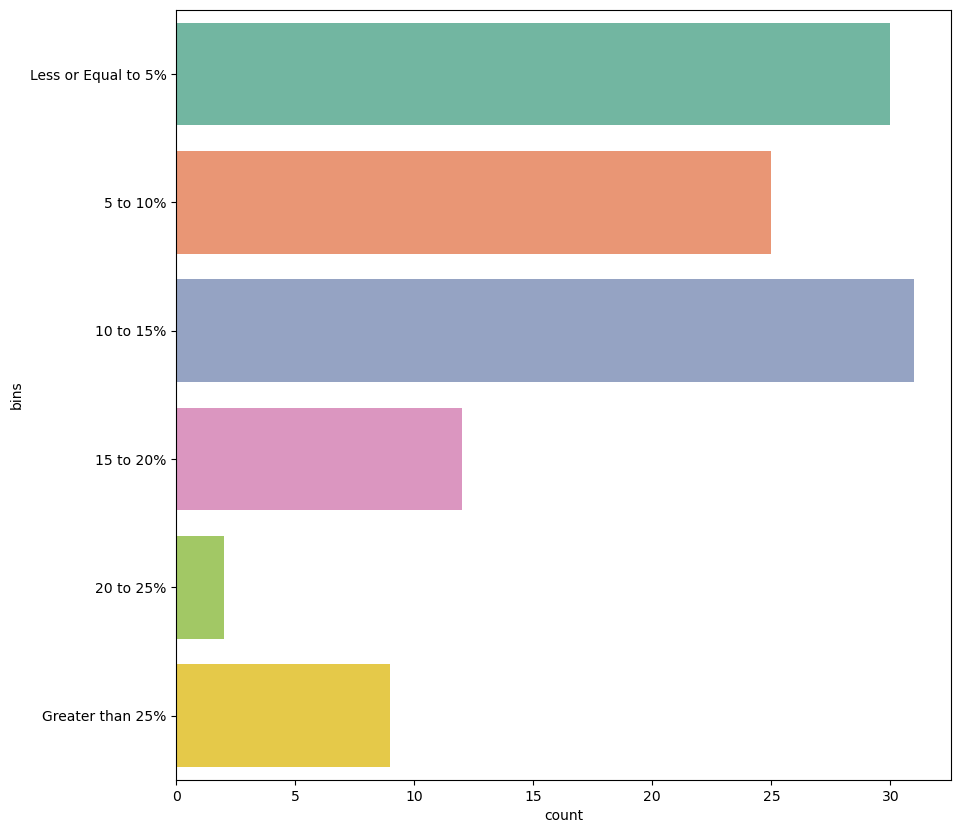

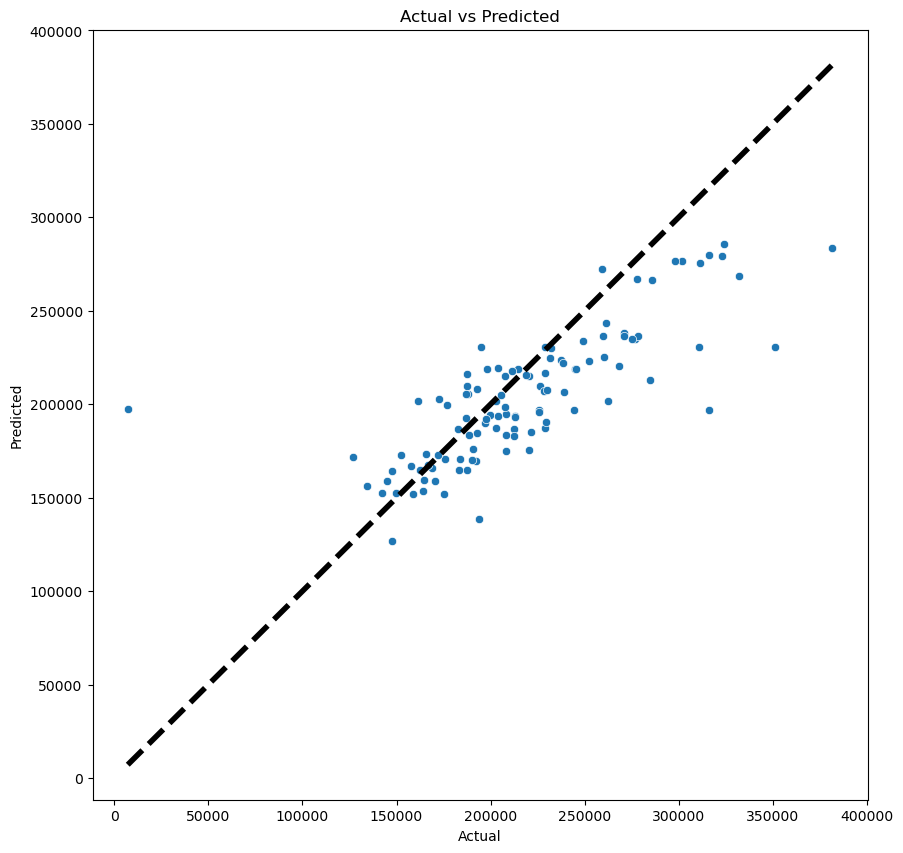

Results of sklearn.metrics:
R-Squared: 0.530350594357747


In [ ]:
Hyperparameter('random forest',rf_parameters)

AdaBoostRegressor()
Optimal number of features: 19


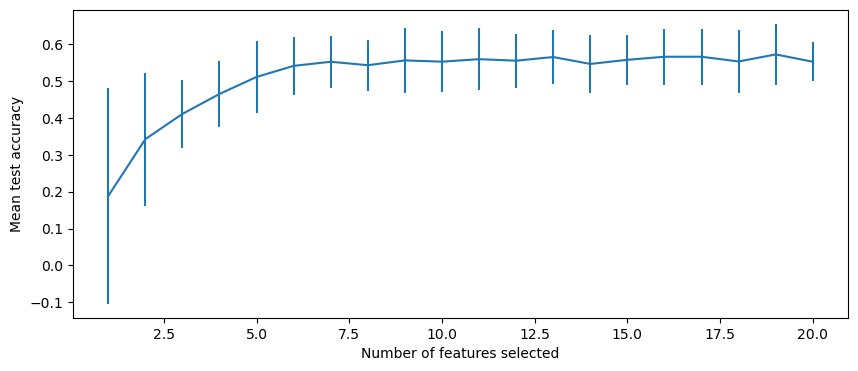

['Month', 'Year', 'Day', 'Weekday', 'Holidays', 'HolidayName', 'mean_temp', 'rain', 'wind_speed', 'abnormal_rain', 'high_temp', 'high_wind', 'InCountTotal1', 'InCountTotal2', 'InCountTotal3', 'InCountTotal4', 'InCountTotal5', 'InCountTotal6', 'InCountTotal7']
      Actual      Predicted       MAPE      sMAPE                 bins
2070  186684  198042.407843   6.084296   5.904668             5 to 10%
2071  213014  186005.741935  12.679100  13.537304            10 to 15%
2072  202759  232353.259218  14.595781  13.603045            10 to 15%
2073  261357  255720.660072   2.156567   2.180075  Less or Equal to 5%
2074  158844  163138.268571   2.703450   2.667394  Less or Equal to 5%
2075  192078  185514.232258   3.417241   3.476643  Less or Equal to 5%
2076  212283  183617.804598  13.503293  14.480999            10 to 15%
2077  208018  180596.051282  13.182488  14.112690            10 to 15%
2078  226027  183617.804598  18.762889  20.705350            15 to 20%
2079  262396  232353.259218  1

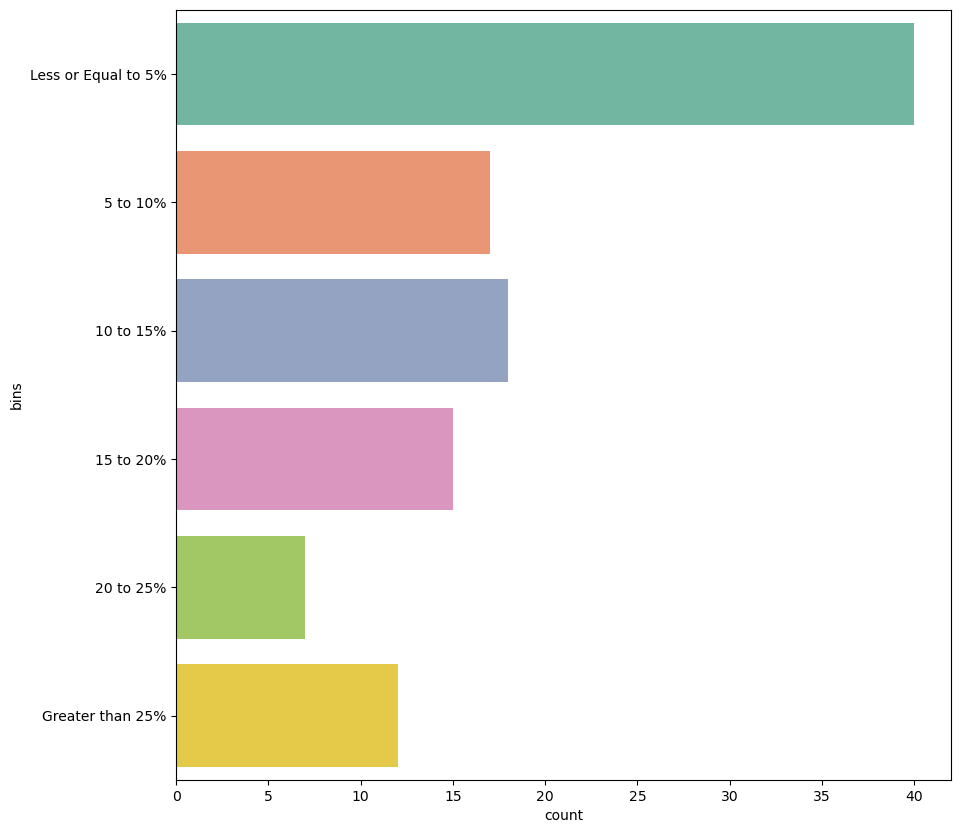

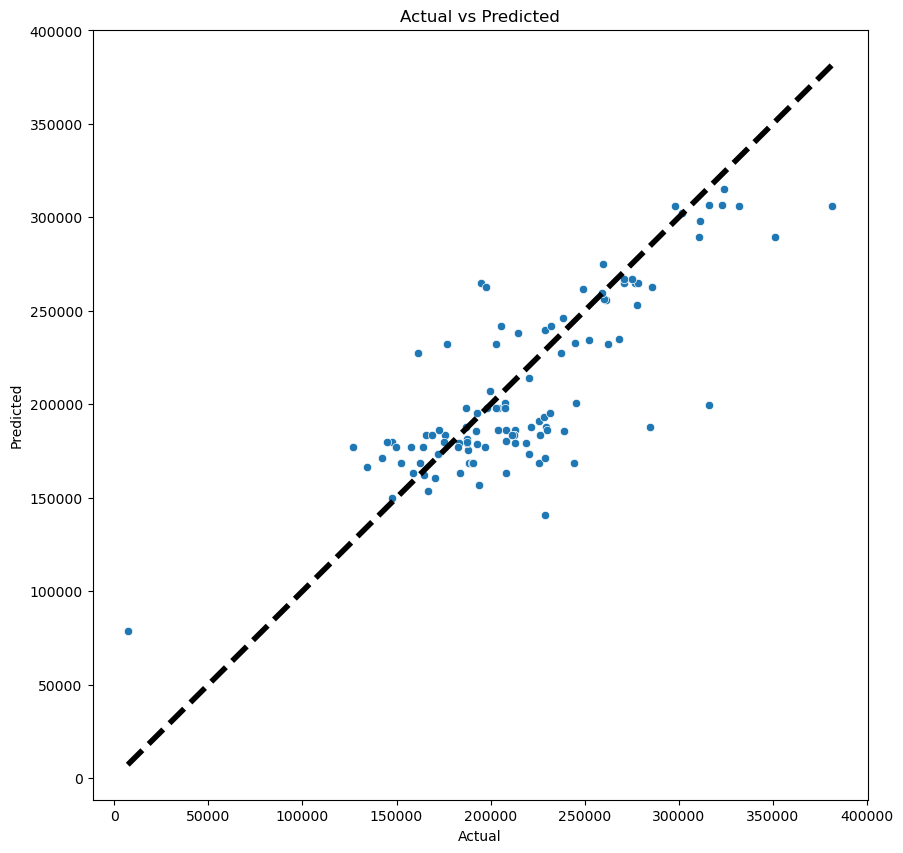

Results of sklearn.metrics:
R-Squared: 0.6148692790451911


In [ ]:
RFECVmodel('ada')

AdaBoostRegressor()
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ................................learning_rate=0.001; total time=   0.2s
[CV] END ................................learning_rate=0.001; total time=   0.3s
[CV] END ................................learning_rate=0.001; total time=   0.2s
[CV] END .................................learning_rate=0.01; total time=   0.2s
[CV] END .................................learning_rate=0.01; total time=   0.2s
[CV] END .................................learning_rate=0.01; total time=   0.2s
[CV] END .................................learning_rate=0.05; total time=   0.2s
[CV] END .................................learning_rate=0.05; total time=   0.2s
[CV] END .................................learning_rate=0.05; total time=   0.2s
[CV] END ..................................learning_rate=0.1; total time=   0.2s
[CV] END ..................................learning_rate=0.1; total time=   0.2s
[CV] END ....................

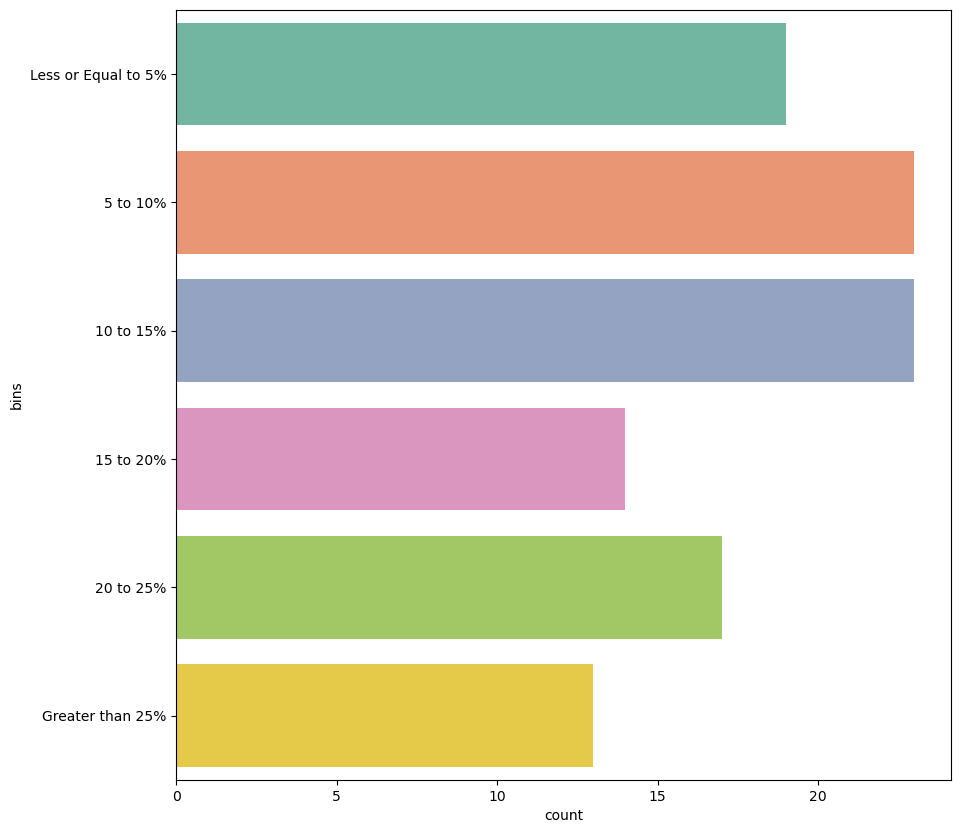

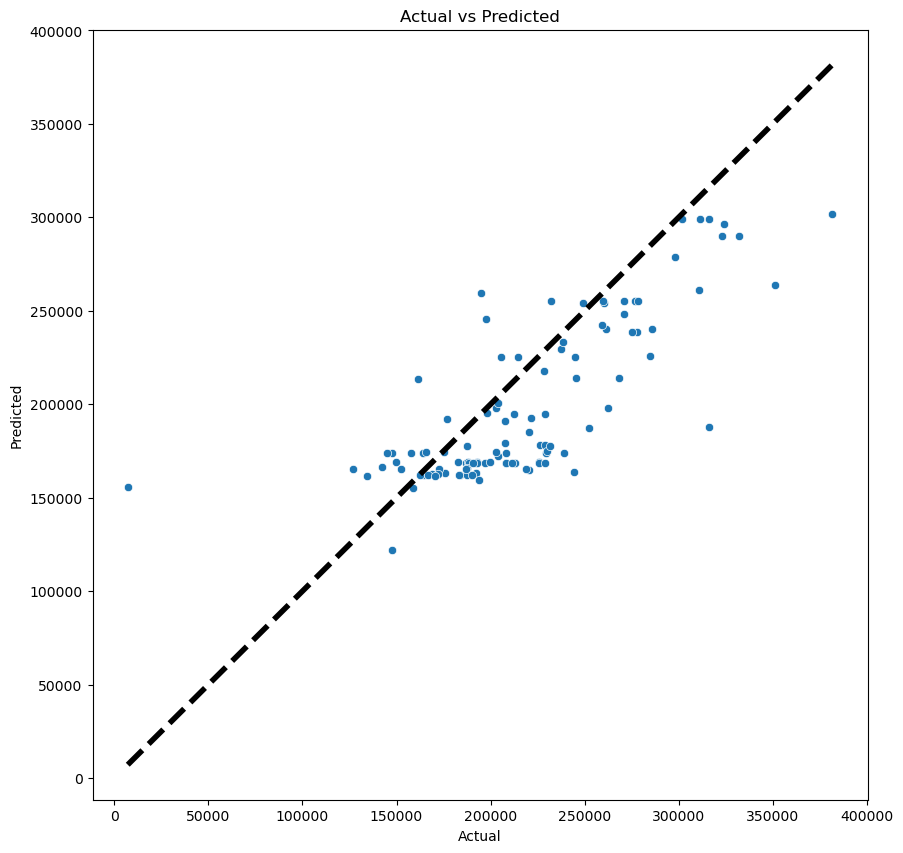

Results of sklearn.metrics:
R-Squared: 0.4763553830321473


In [ ]:
Hyperparameter('ada',ada_parameters)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=5, max_leaves=None, min_child_weight=1, missing=1,
             monotone_constraints=None, n_estimators=150, n_jobs=1,
             nthread=None, num_parallel_tree=None, predictor=None, ...)
Optimal number of features: 13


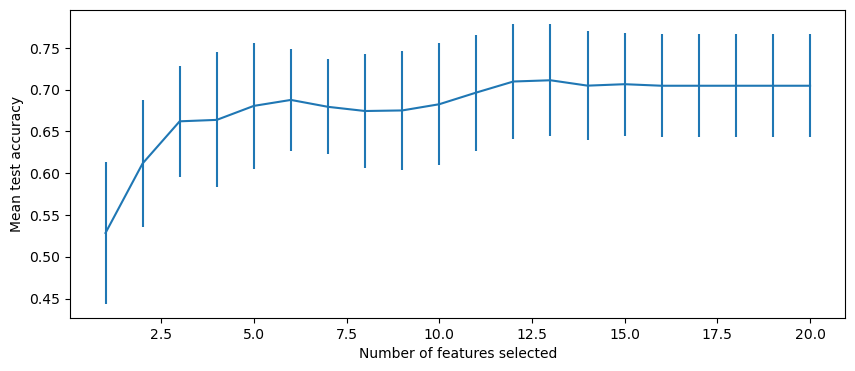

['Month', 'Day', 'Weekday', 'HolidayName', 'mean_temp', 'rain', 'InCountTotal1', 'InCountTotal2', 'InCountTotal3', 'InCountTotal4', 'InCountTotal5', 'InCountTotal6', 'InCountTotal7']
      Actual      Predicted       MAPE      sMAPE                 bins
2070  186684  187653.718750   0.519444   0.518098  Less or Equal to 5%
2071  213014  190175.562500  10.721566  11.328883            10 to 15%
2072  202759  208295.234375   2.730451   2.693676  Less or Equal to 5%
2073  261357  252356.421875   3.443787   3.504124  Less or Equal to 5%
2074  158844  149614.312500   5.810536   5.984399             5 to 10%
2075  192078  168723.500000  12.158863  12.945900            10 to 15%
2076  212283  189218.562500  10.864948  11.489090            10 to 15%
2077  208018  196623.765625   5.477523   5.631764             5 to 10%
2078  226027  215536.312500   4.641343   4.751612  Less or Equal to 5%
2079  262396  225243.390625  14.158985  15.237739            10 to 15%
2080  331880  285885.875000  13.8586

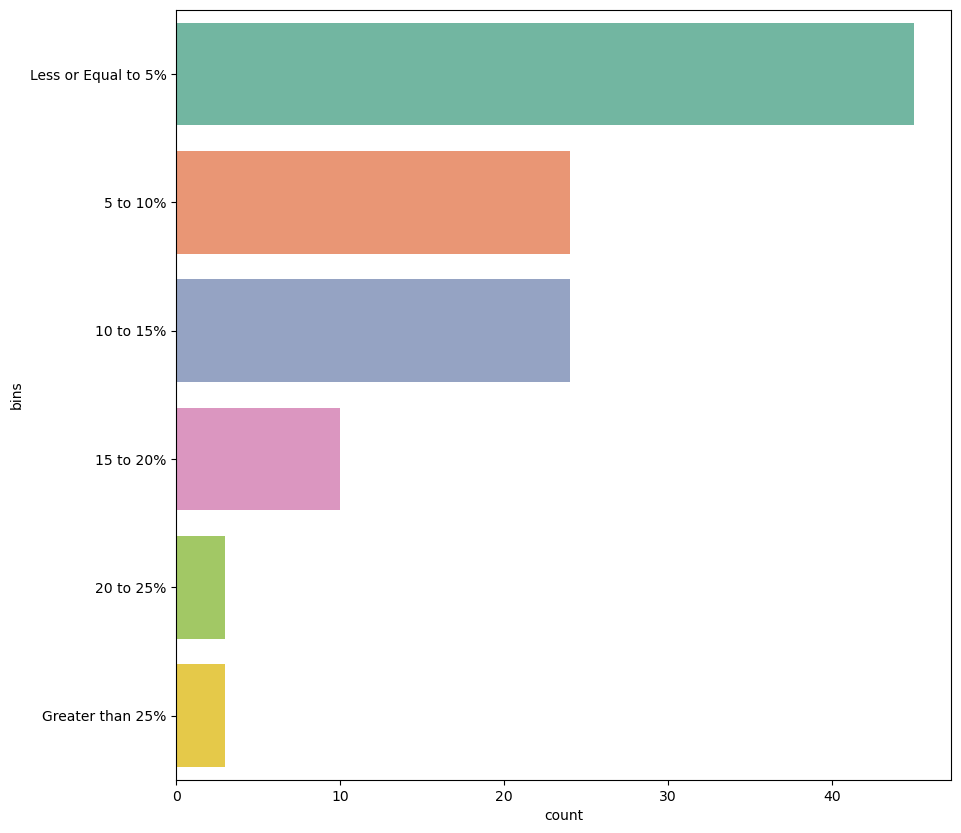

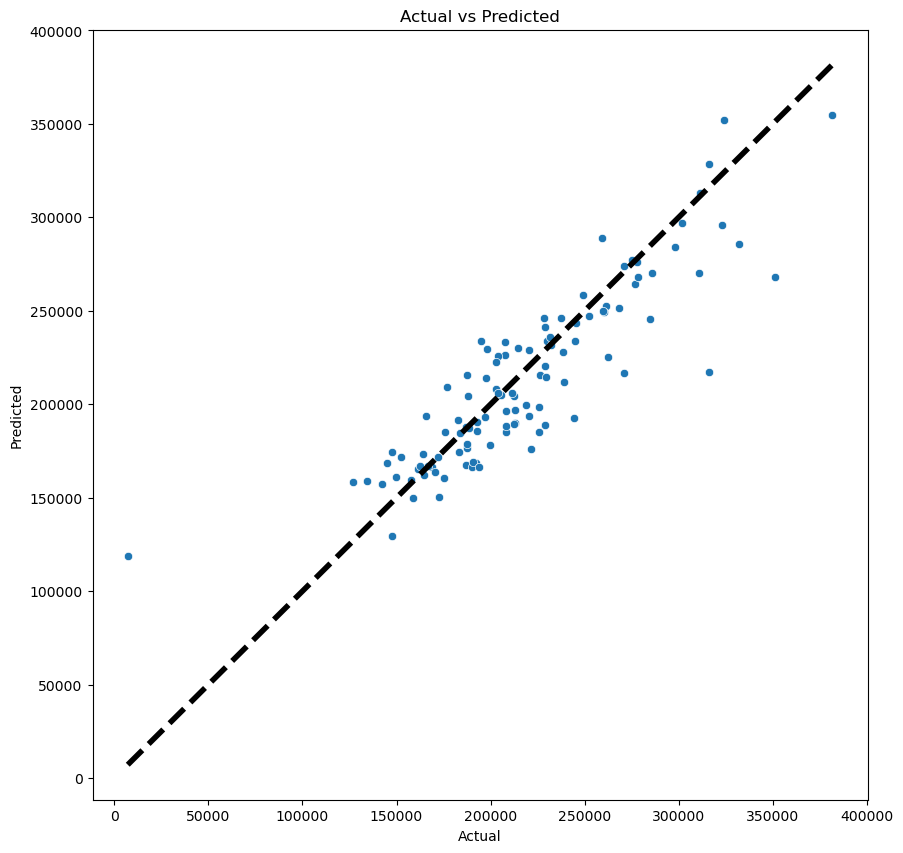

Results of sklearn.metrics:
R-Squared: 0.7706554786653356


In [ ]:
RFECVmodel('xgb')

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=5, max_leaves=None, min_child_weight=1, missing=1,
             monotone_constraints=None, n_estimators=150, n_jobs=1,
             nthread=None, num_parallel_tree=None, predictor=None, ...)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.3, learning_rate=0.001, max_depth=9, min_child_weight=1, reg_alpha=1, subsample=0.9; total time=   0.6s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.3, learning_rate=0.00

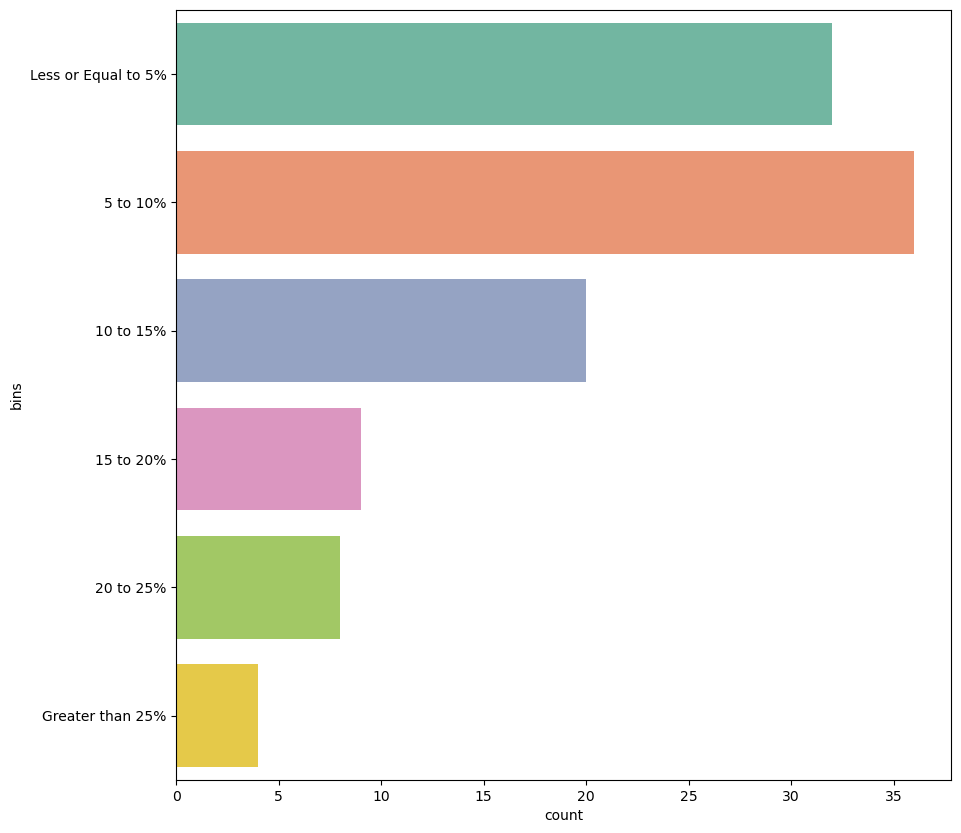

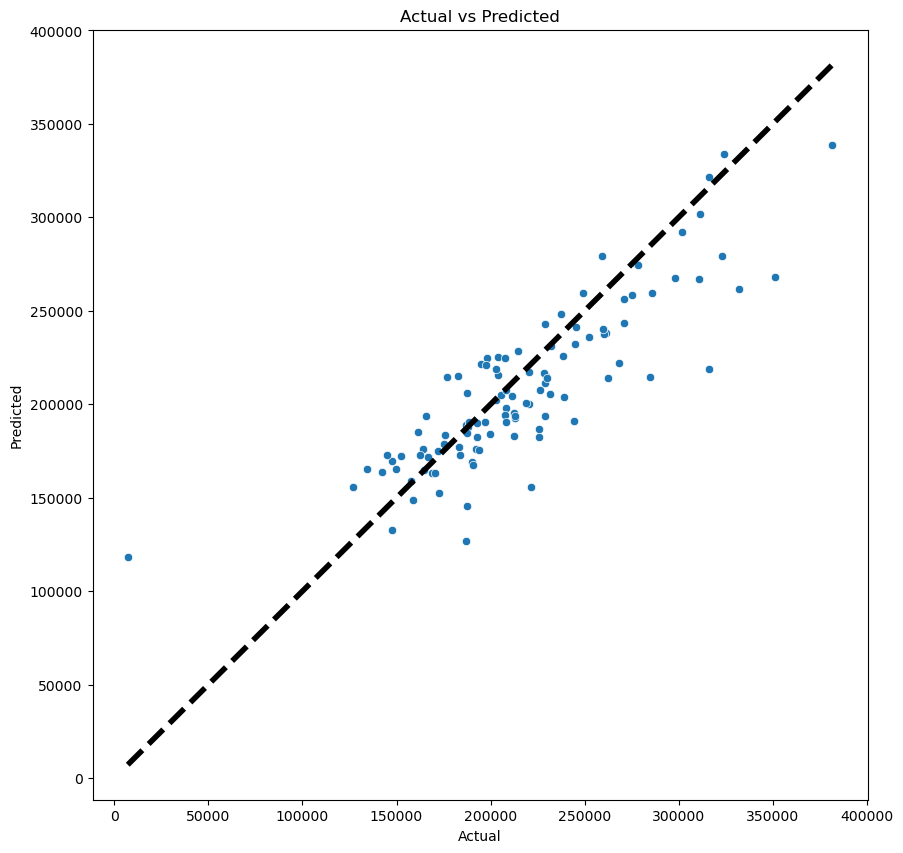

Results of sklearn.metrics:
R-Squared: 0.7115803909994485


In [ ]:
Hyperparameter('xgb',xgb_parameters)

In [ ]:
#RFECVmodel('knn')

KNeighborsRegressor(n_jobs=-1, n_neighbors=3)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END leaf_size=45, metric=manhattan, n_jobs=-1, n_neighbors=5, p=4, weights=uniform; total time=   0.1s
[CV] END leaf_size=45, metric=manhattan, n_jobs=-1, n_neighbors=5, p=4, weights=uniform; total time=   0.0s
[CV] END leaf_size=45, metric=manhattan, n_jobs=-1, n_neighbors=5, p=4, weights=uniform; total time=   0.0s
[CV] END leaf_size=45, metric=euclidean, n_jobs=-1, n_neighbors=11, p=4, weights=distance; total time=   0.1s
[CV] END leaf_size=45, metric=euclidean, n_jobs=-1, n_neighbors=11, p=4, weights=distance; total time=   0.0s
[CV] END leaf_size=45, metric=euclidean, n_jobs=-1, n_neighbors=11, p=4, weights=distance; total time=   0.0s
[CV] END leaf_size=5, metric=manhattan, n_jobs=-1, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END leaf_size=5, metric=manhattan, n_jobs=-1, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END leaf_size=5

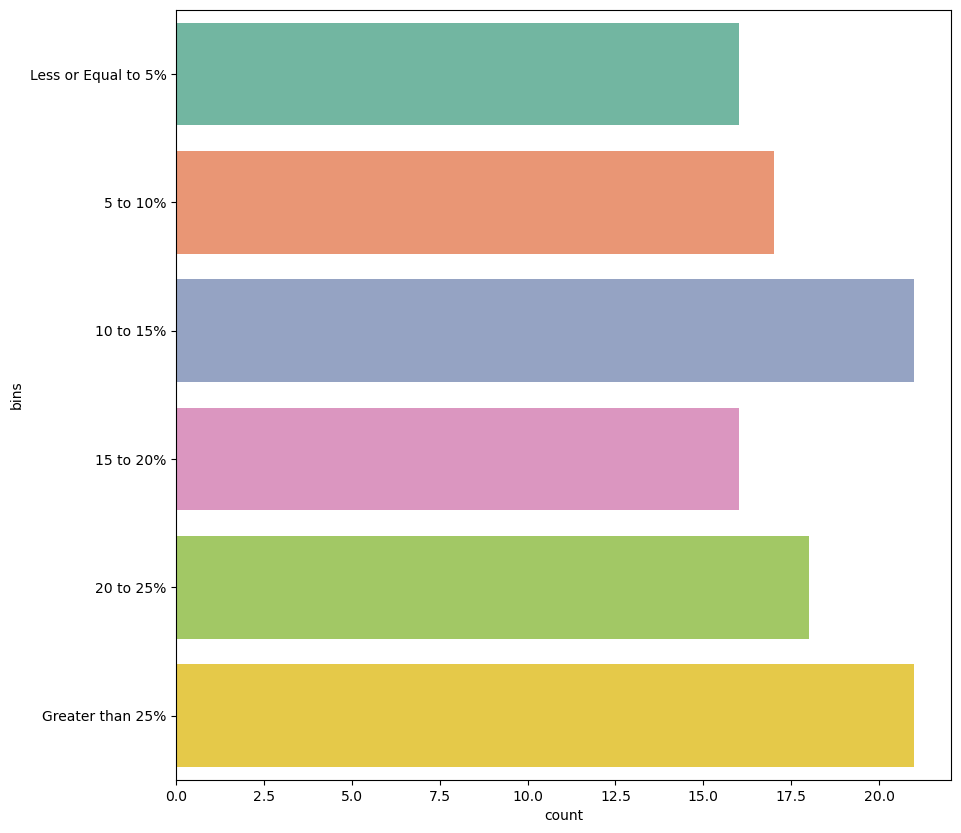

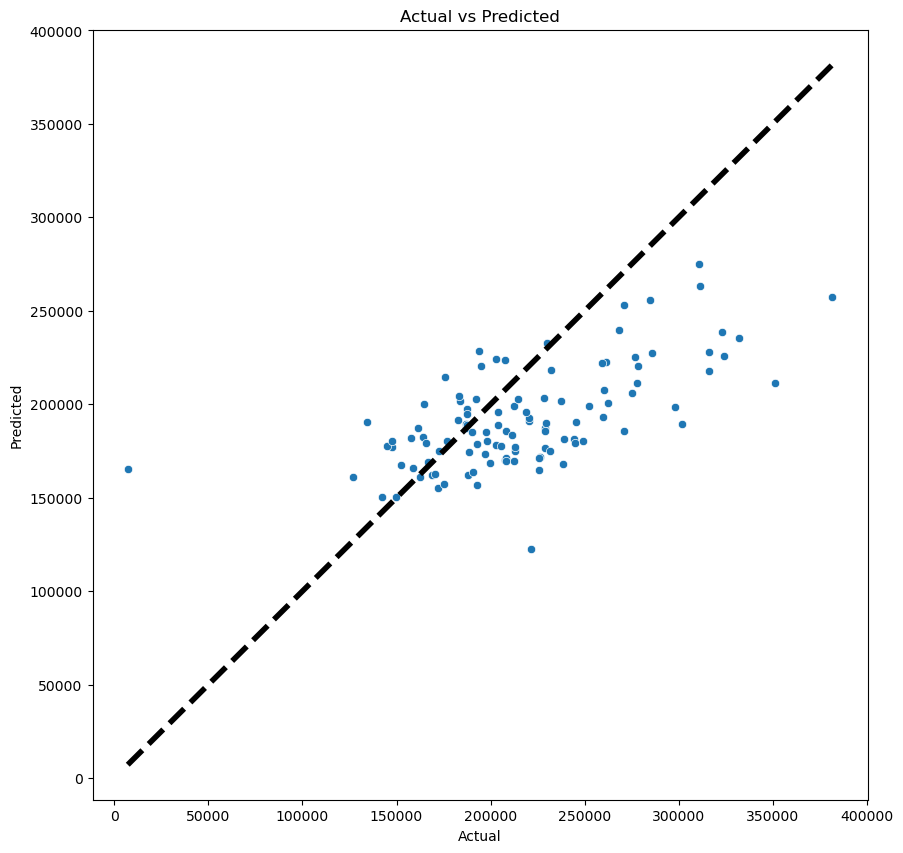

Results of sklearn.metrics:
R-Squared: 0.1731138371112616


In [ ]:
Hyperparameter('knn',knn_parameters)

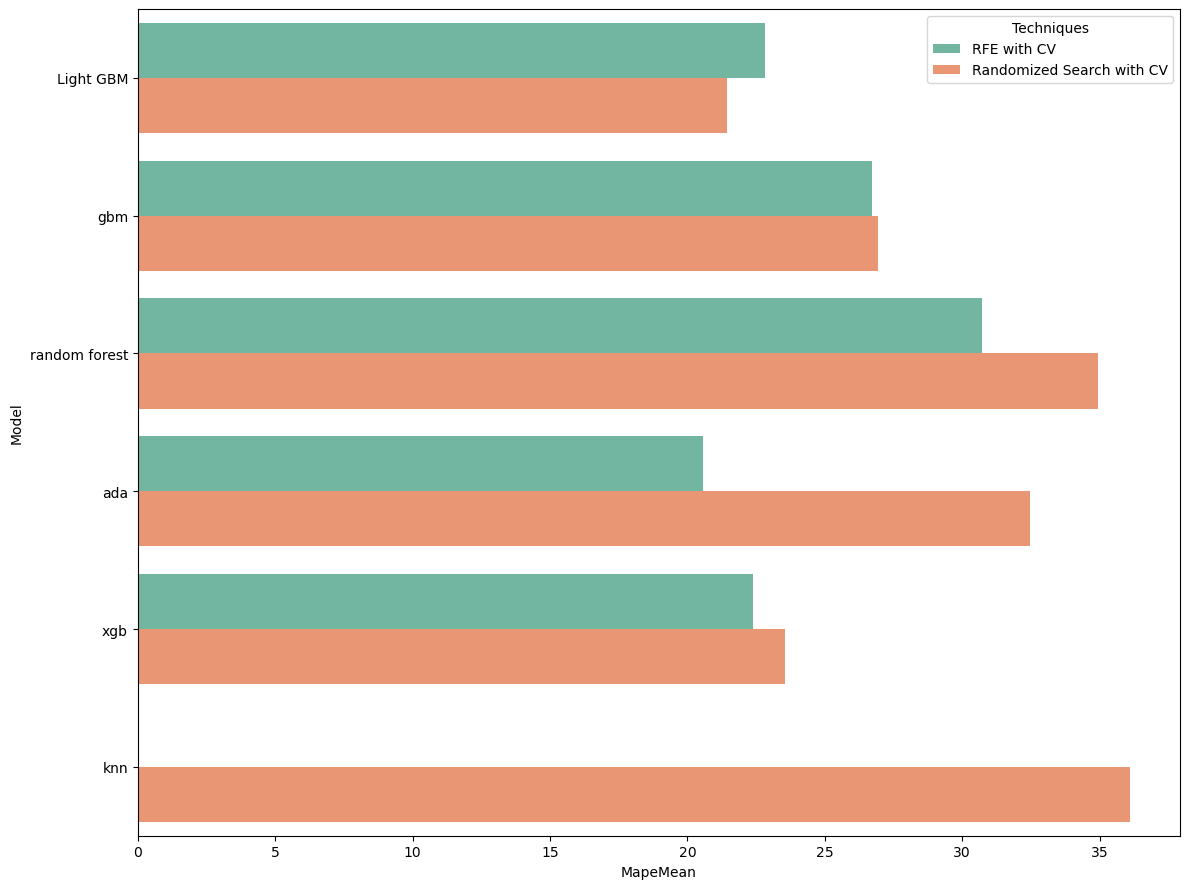

In [ ]:
visualizeScoreComparison(model_results)

In [ ]:
model_results

Model                 Techniques   MapeMean        R2   R2Score  \
0       Light GBM                RFE with CV  22.831267  0.686706  0.686706   
1       Light GBM  Randomized Search with CV  21.438782  0.724263  0.724263   
2             gbm                RFE with CV  26.722849  0.682618  0.682618   
3             gbm  Randomized Search with CV  26.923559  0.694032  0.694032   
4   random forest                RFE with CV  30.706656  0.574223  0.574223   
5   random forest  Randomized Search with CV  34.922275  0.530351  0.530351   
6             ada                RFE with CV  20.554123  0.614869  0.614869   
7             ada  Randomized Search with CV  32.459704  0.476355  0.476355   
8             xgb                RFE with CV  22.402000  0.770655  0.770655   
9             xgb  Randomized Search with CV  23.535840  0.711580  0.711580   
10            knn  Randomized Search with CV  36.117713  0.173114  0.173114   

             MSE           MAE      sMAPE  
0   9.292611e+08  22940.300094  11.885842  
1   8.178632e+08  20914.663930  10.888151  
2   9.413845e+08  22026.775594  11.133318  
3   9.075305e+08  21381.428849  11.025223  
4   1.262897e+09  25125.160822  12.665598  
5   1.393026e+09  25842.312725  12.618811  
6   1.142335e+09  25105.618145  13.227781  
7   1.553181e+09  30938.746635  15.869513  
8   6.802582e+08  18632.567804   9.827623  
9   8.554807e+08  21433.395499  11.194654  
10  2.452625e+09  38480.607402  18.774957

In [ ]:
####### End of code ####